# Student Information

Wangyang He


UIN 625004872


Nickname: heswaggy

Project submission 5



Resource used to implement my model: [Medium Article](https://medium.com/smileinnovation/training-neural-network-with-image-sequence-an-example-with-video-as-input-c3407f7a0b0f)

Imports

In [1]:
import keras
import os
import numpy as np
import csv
from keras.applications import VGG16

Download Kinetics 700 Dataset

In [2]:
!wget https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz


--2021-03-23 22:28:37--  https://storage.googleapis.com/deepmind-media/Datasets/kinetics700_2020.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 173.194.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25320826 (24M) [application/x-gzip]
Saving to: ‘kinetics700_2020.tar.gz’

kinetics700_2020.ta 100%[===================>]  24.15M  36.5MB/s    in 0.7s    

2021-03-23 22:28:38 (36.5 MB/s) - ‘kinetics700_2020.tar.gz’ saved [25320826/25320826]



un-tar the dataset

In [3]:
!tar -xvf  'kinetics700_2020.tar.gz' -C '/content'

kinetics700_2020/
kinetics700_2020/validate.json
kinetics700_2020/validate.csv
kinetics700_2020/train.json
kinetics700_2020/train.csv
kinetics700_2020/test.json
kinetics700_2020/test.csv


In [4]:
import pandas as pd

data = pd.read_csv("/content/kinetics700_2020/train.csv") #make training dataframe
data.head()

label   youtube_id  time_start  time_end  split
0    clay pottery making  ---0dWlqevI          19        29  train
1         news anchoring  ---aQ-tA5_A           9        19  train
2  using bagging machine  ---j12rm3WI          14        24  train
3          javelin throw  --07WQ2iBlw           1        11  train
4        climbing a rope  --0NTAs-fA0          29        39  train

In [5]:
print(data.label)

0           clay pottery making
1                news anchoring
2         using bagging machine
3                 javelin throw
4               climbing a rope
                  ...          
542480           washing dishes
542481            juggling fire
542482             taking photo
542483           brush painting
542484             changing oil
Name: label, Length: 542485, dtype: object


In [6]:
print(data[data.label == ('washing hands')])

                label   youtube_id  time_start  time_end  split
296     washing hands  -1Hub6Ps_cc          47        57  train
1516    washing hands  -BL2GD3GBfE         592       602  train
1668    washing hands  -ChLS3YLStk          94       104  train
2666    washing hands  -LUN6528w3I          28        38  train
3582    washing hands  -TAINJnhrvU           0        10  train
...               ...          ...         ...       ...    ...
522293  washing hands  xZd0YH8C2F8          77        87  train
522625  washing hands  xbDodTSD6zE         114       124  train
526417  washing hands  y3NbJsrCecI          68        78  train
528324  washing hands  yFjrrLoPZ4s           2        12  train
531919  washing hands  yh9aL3dGuBQ           5        15  train

[973 rows x 5 columns]


In [7]:
data_true = data[data.label == ('washing hands')]
data_true = data_true.reset_index() #get the target label information

In [8]:
print(data[data.label != ('washing hands')])

                        label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
542480         washing dishes  zzz_3yWpTXo           0        10  train
542481          juggling fire  zzzkS3amkWE         124       134  train
542482           taking photo  zzzsd1R7H0E           6        16  train
542483         brush painting  zzzxltuPx2Q          84        94  train
542484           changing oil  zzzzE0ncP1Y         232       242  train

[541512 rows x 5 columns]


In [9]:
data_false = data[data.label != ('washing hands')]
data_false = data_false.sample(n=973, random_state=0) # get the same number of un-target label randomly
data_false = data_false.reset_index() 

In [10]:
data_false.shape

(973, 6)

In [11]:
data.describe

<bound method NDFrame.describe of                         label   youtube_id  time_start  time_end  split
0         clay pottery making  ---0dWlqevI          19        29  train
1              news anchoring  ---aQ-tA5_A           9        19  train
2       using bagging machine  ---j12rm3WI          14        24  train
3               javelin throw  --07WQ2iBlw           1        11  train
4             climbing a rope  --0NTAs-fA0          29        39  train
...                       ...          ...         ...       ...    ...
542480         washing dishes  zzz_3yWpTXo           0        10  train
542481          juggling fire  zzzkS3amkWE         124       134  train
542482           taking photo  zzzsd1R7H0E           6        16  train
542483         brush painting  zzzxltuPx2Q          84        94  train
542484           changing oil  zzzzE0ncP1Y         232       242  train

[542485 rows x 5 columns]>

In [12]:
!pip install --upgrade youtube_dl

     |████████████████████████████████| 1.9MB 16.7MB/s 


In [13]:
base_dir = '/content/kinetics700' #create all folders for videos
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

train_true_dir = os.path.join(train_dir, 'true')
os.mkdir(train_true_dir)

train_false_dir = os.path.join(train_dir, 'false')
os.mkdir(train_false_dir)

test_true_dir = os.path.join(test_dir, 'true')
os.mkdir(test_true_dir)

test_false_dir = os.path.join(test_dir, 'false')
os.mkdir(test_false_dir)

In [14]:
import youtube_dl, subprocess

true_label = ['washing hands'] 
for i, id in data_true.iterrows(): #download training video for target action
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"washing hands.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not washing hands.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] -1Hub6Ps_cc: Downloading webpage
[youtube] -BL2GD3GBfE: Downloading webpage
[youtube] -ChLS3YLStk: Downloading webpage
[youtube] -LUN6528w3I: Downloading webpage
[youtube] -TAINJnhrvU: Downloading webpage
[youtube] -Xkdlbnxfc8: Downloading webpage
[youtube] -eia05K09c8: Downloading webpage
[youtube] -eia05K09c8: Downloading player 228f3ac7
[youtube] -fouQuertaE: Downloading webpage
[youtube] -mhWIO9Zy-Y: Downloading webpage
[youtube] -nggrKZxNio: Downloading webpage
[youtube] -ucHY_dvTyY: Downloading webpage
[youtube] 0Ad3dp89NvU: Downloading webpage
[youtube] 0DwP5mOidOg: Downloading webpage
[youtube] 0EbJ64IaKQQ: Downloading webpage
[youtube] 0Fs3UX5y-70: Downloading webpage
[youtube] 0Jmw3bhQ8Eg: Downloading webpage
[youtube] 0Nf3Jw4EzJA: Downloading webpage
[youtube] 0Rd-W4MZQf8: Downloading webpage
[youtube] 0S72sCf_8yE: Downloading webpage
[youtube] 0Tkq3WOEnoM: Downloading webpage
[youtube] 0XcnMt3TGP4: Downloading webpage
[youtube] 0cn0sIdVJdU: Downloading webpage
[yo

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 0vUi3QhaUHU: Downloading webpage
[youtube] 1-xY0TpaAGs: Downloading webpage
[youtube] 128LpOaYA5o: Downloading webpage
[youtube] 12p5mQTw8pY: Downloading webpage
[youtube] 139hDfe8Kbk: Downloading webpage
[youtube] 16gGNdL__aA: Downloading webpage
[youtube] 18qffSbYLeQ: Downloading webpage
[youtube] 1BSs2OPDPWo: Downloading webpage
[youtube] 1CaC8Kvfd_w: Downloading webpage
[youtube] 1DmdX5QwqFI: Downloading webpage
[youtube] 1F81EC1_ZXU: Downloading webpage
[youtube] 1HYjqxZ1c_Y: Downloading webpage
[youtube] 1MtPjU2QKIc: Downloading webpage
[youtube] 1VKeP8xBf_A: Downloading webpage
[youtube] 1YPJT-P3Zo8: Downloading webpage
[youtube] 1gQEngRyims: Downloading webpage
[youtube] 1i9E9d7ngpY: Downloading webpage
[youtube] 1lAnbCyH4Bk: Downloading webpage
[youtube] 1lxCJQ56yWA: Downloading webpage
[youtube] 1ml0qpF91B4: Downloading webpage
[youtube] 1mvG5NP1ZgI: Downloading webpage
[youtube] 1p4KUYv3BT4: Downloading webpage
[youtube] 1p9o-89gWoU: Downloading webpage
[youtube] 1

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 2Gw4HzmT4Q0: Downloading webpage
[youtube] 2Gx5-vEKJ1Y: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 2HN7t9STdv4: Downloading webpage
[youtube] 2ITzMNEB5TM: Downloading webpage
[youtube] 2KYNeKVT6r8: Downloading webpage
[youtube] 2L36UtJbtE4: Downloading webpage
[youtube] 2Qtpb3jAj3Y: Downloading webpage
[youtube] 2TBmaAcf8mM: Downloading webpage
[youtube] 2VU_XoQLoSc: Downloading webpage
[youtube] 2WPS4QEke2U: Downloading webpage
[youtube] 2Y-qJqPd5CE: Downloading webpage
[youtube] 2aXuDZ2_F6I: Downloading webpage
[youtube] 2giBLWDS7Sk: Downloading webpage
[youtube] 2nsMkFhv4Lw: Downloading webpage
[youtube] 2pOWJvYKJnM: Downloading webpage
[youtube] 2rrw8rcC164: Downloading webpage
[youtube] 2u1uPbGssME: Downloading webpage
[youtube] 2u9feiUCbag: Downloading webpage
[youtube] 2vOyBqbtDZ8: Downloading webpage
[youtube] 2vxXAmap6GU: Downloading webpage
[youtube] 326L09XoQyU: Downloading webpage
[youtube] 35HFCWhI-f8: Downloading webpage
[youtube] 3BpwUe_6AEQ: Downloading webpage
[youtube] 3DL3mKvDBnE: Downloading webpage
[youtube] 3FsoJEabz_o: Downloading webpage
[youtube] 3

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 3boxQwSpv-8: Downloading webpage
[youtube] 3gm7DC10Qz0: Downloading webpage
[youtube] 3hNNgQTEZm4: Downloading webpage
[youtube] 3hTieSQI0yE: Downloading webpage
[youtube] 3mipwsEdzQc: Downloading webpage
[youtube] 3spRvc8umjo: Downloading webpage
[youtube] 3tffWlEOPzg: Downloading webpage
[youtube] 42Dlt__p2eo: Downloading webpage
[youtube] 42ECh4hMiH4: Downloading webpage
[youtube] 42TWsySN-jw: Downloading webpage
[youtube] 442ahO-RMjQ: Downloading webpage
[youtube] 46IPC_Q1TzU: Downloading webpage
[youtube] 47Ozw_gxkzo: Downloading webpage
[youtube] 488R6q0Egds: Downloading webpage
[youtube] 4901MZtriZk: Downloading webpage
[youtube] 49kP1fYr9z8: Downloading webpage
[youtube] 4A-Cftt3kEQ: Downloading webpage
[youtube] 4BuDiDOaYjw: Downloading webpage
[youtube] 4EnrQxswWDs: Downloading webpage
[youtube] 4F2lvuXHDzc: Downloading webpage
[youtube] 4FuP03hsGzQ: Downloading webpage
[youtube] 4JeAj6gftvM: Downloading webpage
[youtube] 4L_7YulALlY: Downloading webpage
[youtube] 4

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 4ap0jcZH9RY: Downloading webpage
[youtube] 4bnk1eyVJ4o: Downloading webpage
[youtube] 4d1K4B9qn4A: Downloading webpage
[youtube] 4fsvC6RnEZE: Downloading webpage
[youtube] 4i4K6KBNmlk: Downloading webpage
[youtube] 4k6uLW_faNo: Downloading webpage
[youtube] 4mskdgbW-mA: Downloading webpage
[youtube] 4nILpBpGDPI: Downloading webpage
[youtube] 4s8EpsUGiyU: Downloading webpage
[youtube] 4snjXM10i3s: Downloading webpage
[youtube] 4xbuOuG6nBQ: Downloading webpage
[youtube] 5448XQQ3cFw: Downloading webpage
[youtube] 55asLD18g2Q: Downloading webpage
[youtube] 56qquzlu59s: Downloading webpage
[youtube] 580APXIVFOU: Downloading webpage
[youtube] 58sPeLU4AIw: Downloading webpage
[youtube] 591l15iaX-E: Downloading webpage
[youtube] 5BZ2J3z41EI: Downloading webpage
[youtube] 5CzQYoiDIsQ: Downloading webpage
[youtube] 5E_Y-e3Kik0: Downloading webpage
[youtube] 5FPcj16kVQs: Downloading webpage
[youtube] 5G2boQ52kgg: Downloading webpage
[youtube] 5LyqV0HFj8c: Downloading webpage
[youtube] 5

ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 5k-5vbQj1ao: Downloading webpage
[youtube] 5kGdMYtZT9Q: Downloading webpage
[youtube] 5kMigslFuQY: Downloading webpage
[youtube] 5l9w8iBhKcw: Downloading webpage
[youtube] 5lNHfC4W3-A: Downloading webpage
[youtube] 5lZQmvvaiHY: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 5n6t85pQRs8: Downloading webpage
[youtube] 5nAuKJ241Sc: Downloading webpage
[youtube] 5oid7p6VV58: Downloading webpage
[youtube] 5u2oLFFI070: Downloading webpage
[youtube] 5v0GOf3Af3s: Downloading webpage
[youtube] 6019-YPrXZE: Downloading webpage
[youtube] 61DhaE9kdOc: Downloading webpage
[youtube] 633prnX1YHA: Downloading webpage
[youtube] 63rUZEOrHSQ: Downloading webpage
[youtube] 63s6EkOcLvo: Downloading webpage
[youtube] 64ZQzOR1SCI: Downloading webpage
[youtube] 65O2GrpJ7oE: Downloading webpage
[youtube] 68ziHNo4lk8: Downloading webpage
[youtube] 6CAan23806E: Downloading webpage
[youtube] 6D0bRCQr_4Y: Downloading webpage
[youtube] 6FabYox-WRY: Downloading webpage
[youtube] 6G5RK7SA4n8: Downloading webpage
[youtube] 6KOpcbWQCIY: Downloading webpage
[youtube] 6MdJA8iOk5Q: Downloading webpage
[youtube] 6QYLUzI49u8: Downloading webpage
[youtube] 6RcrFPuxukY: Downloading webpage
[youtube] 6TITxAee1CI: Downloading webpage
[youtube] 6ViW4rOiiao: Downloading webpage
[youtube] 6

ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 73UpUqVAPSM: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] 75f_k5ynUVw: Downloading webpage
[youtube] 7GL2ChqKeM8: Downloading webpage
[youtube] 7Kq4jbL1dbA: Downloading webpage
[youtube] 7Kv5ghv97Qo: Downloading webpage
[youtube] 7T2meA4w7_s: Downloading webpage
[youtube] 7ZPn-7-t3ZY: Downloading webpage
[youtube] 7_Az7bSPkas: Downloading webpage
[youtube] 7b9Nq-ScEdQ: Downloading webpage
[youtube] 7bo9WQ1XAXk: Downloading webpage
[youtube] 7fEZVaSgahE: Downloading webpage
[youtube] 7s0ixX-mfgg: Downloading webpage
[youtube] 7sIYP7BAVLs: Downloading webpage
[youtube] 7u8PvkgXjzw: Downloading webpage
[youtube] 7wrPzWuctq0: Downloading webpage
[youtube] 7xCbBoEBfYk: Downloading webpage
[youtube] 825gGELjB98: Downloading webpage
[youtube] 834rPAlCp54: Downloading webpage
[youtube] 88cOcUuiNyY: Downloading webpage
[youtube] 89SXXUKrgCw: Downloading webpage
[youtube] 8Bq8lLy9Obk: Downloading webpage
[youtube] 8D1-6D2Ho04: Downloading webpage
[youtube] 8DX6zxnA_tE: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 8J3R_Rfk7E4: Downloading webpage
[youtube] 8NG-E_ZoXZs: Downloading webpage
[youtube] 8WOhYFNyTec: Downloading webpage
[youtube] 8YFEV4mRy70: Downloading webpage
[youtube] 8aFScwLub1o: Downloading webpage
[youtube] 8b1Z5fBDHds: Downloading webpage
[youtube] 8bKEsPKS8i8: Downloading webpage
[youtube] 8by_RJVcvS0: Downloading webpage
[youtube] 8cY1d9Bl_1o: Downloading webpage
[youtube] 8ch7ES7sXfk: Downloading webpage
[youtube] 8euyPLqKYBM: Downloading webpage
[youtube] 8gZPUTTmyE4: Downloading webpage
[youtube] 8k6h7n8h5sI: Downloading webpage
[youtube] 8lh0f9t6JIc: Downloading webpage
[youtube] 8paxL6kbvQ8: Downloading webpage
[youtube] 8sV85OQSFDc: Downloading webpage
[youtube] 8se9xuvZvYI: Downloading webpage
[youtube] 8tqbL3t-Wcc: Downloading webpage
[youtube] 8xDT8rzezkM: Downloading webpage


ERROR: Video unavailable
This video is no longer available due to a copyright claim by Howdini / Touchstorm.


[youtube] 94OULp9TW0s: Downloading webpage
[youtube] 94SygI2_iD8: Downloading webpage
[youtube] 94cyt5pl7jQ: Downloading webpage
[youtube] 96ADEnJy4GU: Downloading webpage
[youtube] 99u4Iwy1caE: Downloading webpage
[youtube] 9DgBBl7-YVo: Downloading webpage
[youtube] 9E7nO2eh2TM: Downloading webpage
[youtube] 9F7MH87VwxE: Downloading webpage
[youtube] 9GURKdQWdBo: Downloading webpage
[youtube] 9KIIOTvKcY4: Downloading webpage
[youtube] 9KweVDK5mdQ: Downloading webpage
[youtube] 9OqYdScg6b4: Downloading webpage
[youtube] 9OwQ7_mvHQA: Downloading webpage
[youtube] 9QL156Jiojs: Downloading webpage
[youtube] 9QL156Jiojs: Downloading player 38c5f870
[youtube] 9Um47CU5yF0: Downloading webpage
[youtube] 9YUfsw3q_BI: Downloading webpage
[youtube] 9_Q47OZcI6I: Downloading webpage
[youtube] 9a-rp1phPwU: Downloading webpage
[youtube] 9arJ0UVKffw: Downloading webpage
[youtube] 9aygfFqe23A: Downloading webpage
[youtube] 9d0b_8fmSkc: Downloading webpage
[youtube] 9hZkOXu8KMw: Downloading webpage
[yo

ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] Aeqi1oT-4X8: Downloading webpage


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] Ax75yAW9zFo: Downloading webpage
[youtube] B-kFKc8sHFg: Downloading webpage
[youtube] B6-o9wfsVuE: Downloading webpage
[youtube] B8TZ1dplVkA: Downloading webpage
[youtube] B8Ttif3qjSI: Downloading webpage
[youtube] BB3vXKKN-0U: Downloading webpage


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] BEjf-gpo2ZQ: Downloading webpage
[youtube] BGsN198GVjA: Downloading webpage
[youtube] BLamvR0GIE8: Downloading webpage
[youtube] BQ4dqlqZpXY: Downloading webpage
[youtube] Ba2MACmbKDA: Downloading webpage
[youtube] BdT_kiExlNo: Downloading webpage
[youtube] BkO92yU1oqY: Downloading webpage
[youtube] BmUd2XFya_A: Downloading webpage
[youtube] Bqh9jjqEWAo: Downloading webpage
[youtube] C08oVeRkZ-U: Downloading webpage
[youtube] C4875srn6kY: Downloading webpage
[youtube] C5I0t980OGk: Downloading webpage
[youtube] C5WtSXjnPvk: Downloading webpage
[youtube] C6SPwbLCtc0: Downloading webpage
[youtube] CFZu7jusPvk: Downloading webpage
[youtube] CHdo9jgp5jc: Downloading webpage
[youtube] CI4thzdXJF4: Downloading webpage
[youtube] CSC8Nm3VqrI: Downloading webpage


[youtube] CSC8Nm3VqrI: Downloading API JSON
[youtube] CSC8Nm3VqrI: Downloading API JSON
[youtube] CSuzuJsqeRo: Downloading webpage


[youtube] CSuzuJsqeRo: Downloading API JSON
[youtube] CSuzuJsqeRo: Downloading API JSON
[youtube] CX3-wDV8BdE: Downloading webpage


[youtube] CX3-wDV8BdE: Downloading API JSON
[youtube] CX3-wDV8BdE: Downloading API JSON
[youtube] CaRS8f3hYUg: Downloading webpage


[youtube] CaRS8f3hYUg: Downloading API JSON
[youtube] CaRS8f3hYUg: Downloading API JSON
[youtube] CcK_vQRbmUA: Downloading webpage


[youtube] CcK_vQRbmUA: Downloading API JSON
[youtube] CcK_vQRbmUA: Downloading API JSON
[youtube] CftucBvNy0A: Downloading webpage


[youtube] CftucBvNy0A: Downloading API JSON
[youtube] CftucBvNy0A: Downloading API JSON
[youtube] Ch1ArGaTy44: Downloading webpage


[youtube] Ch1ArGaTy44: Downloading API JSON
[youtube] Ch1ArGaTy44: Downloading API JSON
[youtube] Ciu5OlrbbYI: Downloading webpage


[youtube] Ciu5OlrbbYI: Downloading API JSON
[youtube] Ciu5OlrbbYI: Downloading API JSON
[youtube] CntH3-MK1Lo: Downloading webpage


[youtube] CntH3-MK1Lo: Downloading API JSON
[youtube] CntH3-MK1Lo: Downloading API JSON
[youtube] CoPktawvFyw: Downloading webpage


[youtube] CoPktawvFyw: Downloading API JSON


ERROR: Video unavailable
This video is not available


[youtube] Cq8VZQTJ1io: Downloading webpage


[youtube] Cq8VZQTJ1io: Downloading API JSON
[youtube] Cq8VZQTJ1io: Downloading API JSON
[youtube] CqqDP4vfdtE: Downloading webpage


[youtube] CqqDP4vfdtE: Downloading API JSON
[youtube] CqqDP4vfdtE: Downloading API JSON
[youtube] CvxQFE4QCKc: Downloading webpage


[youtube] CvxQFE4QCKc: Downloading API JSON
[youtube] CvxQFE4QCKc: Downloading API JSON
[youtube] Cwmphwgr7k0: Downloading webpage


[youtube] Cwmphwgr7k0: Downloading API JSON
[youtube] Cwmphwgr7k0: Downloading API JSON
[youtube] D2X1xUku5WU: Downloading webpage


[youtube] D2X1xUku5WU: Downloading API JSON
[youtube] D2X1xUku5WU: Downloading API JSON
[youtube] D6CxC_8-xTQ: Downloading webpage


[youtube] D6CxC_8-xTQ: Downloading API JSON
[youtube] D6CxC_8-xTQ: Downloading API JSON
[youtube] D7tSpFiMXYM: Downloading webpage


[youtube] D7tSpFiMXYM: Downloading API JSON
[youtube] D7tSpFiMXYM: Downloading API JSON
[youtube] D91ghm6eWkM: Downloading webpage


[youtube] D91ghm6eWkM: Downloading API JSON
[youtube] D91ghm6eWkM: Downloading API JSON
[youtube] DBIUDDnLgBs: Downloading webpage


[youtube] DBIUDDnLgBs: Downloading API JSON
[youtube] DBIUDDnLgBs: Downloading API JSON
[youtube] DJi5Lt9eji4: Downloading webpage


[youtube] DJi5Lt9eji4: Downloading API JSON
[youtube] DJi5Lt9eji4: Downloading API JSON
[youtube] DOVzrocR2fM: Downloading webpage


[youtube] DOVzrocR2fM: Downloading API JSON
[youtube] DOVzrocR2fM: Downloading API JSON
[youtube] DSwKQdZO_rs: Downloading webpage


[youtube] DSwKQdZO_rs: Downloading API JSON
[youtube] DSwKQdZO_rs: Downloading API JSON
[youtube] DfD9qoK6z1E: Downloading webpage


[youtube] DfD9qoK6z1E: Downloading API JSON
[youtube] DfD9qoK6z1E: Downloading API JSON
[youtube] DjtnOeXyowg: Downloading webpage


[youtube] DjtnOeXyowg: Downloading API JSON
[youtube] DjtnOeXyowg: Downloading API JSON
[youtube] Do6oWO-WAYI: Downloading webpage


[youtube] Do6oWO-WAYI: Downloading API JSON
[youtube] Do6oWO-WAYI: Downloading API JSON
[youtube] DoTPcOGe9EA: Downloading webpage


[youtube] DoTPcOGe9EA: Downloading API JSON
[youtube] DoTPcOGe9EA: Downloading API JSON
[youtube] DsuIItsmRpQ: Downloading webpage


[youtube] DsuIItsmRpQ: Downloading API JSON
[youtube] DsuIItsmRpQ: Downloading API JSON
[youtube] DuziaCsKw9g: Downloading webpage


[youtube] DuziaCsKw9g: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] E1GPAVPMnoE: Downloading webpage


[youtube] E1GPAVPMnoE: Downloading API JSON
[youtube] E1GPAVPMnoE: Downloading API JSON
[youtube] E2nIbbq07JE: Downloading webpage


[youtube] E2nIbbq07JE: Downloading API JSON
[youtube] E2nIbbq07JE: Downloading API JSON
[youtube] E3JnPNX_CNk: Downloading webpage


[youtube] E3JnPNX_CNk: Downloading API JSON
[youtube] E3JnPNX_CNk: Downloading API JSON
[youtube] E3yce2R_yNE: Downloading webpage


[youtube] E3yce2R_yNE: Downloading API JSON
[youtube] E3yce2R_yNE: Downloading API JSON
[youtube] E6CLQgiImBc: Downloading webpage


[youtube] E6CLQgiImBc: Downloading API JSON
[youtube] E6CLQgiImBc: Downloading API JSON
[youtube] EAjKAz8ZG3A: Downloading webpage


[youtube] EAjKAz8ZG3A: Downloading API JSON
[youtube] EAjKAz8ZG3A: Downloading API JSON
[youtube] EDxDsKONX3M: Downloading webpage


[youtube] EDxDsKONX3M: Downloading API JSON
[youtube] EDxDsKONX3M: Downloading API JSON
[youtube] EF8kEq-kgWE: Downloading webpage


[youtube] EF8kEq-kgWE: Downloading API JSON
[youtube] EF8kEq-kgWE: Downloading API JSON
[youtube] EOkHwmOLCxE: Downloading webpage


[youtube] EOkHwmOLCxE: Downloading API JSON
[youtube] EOkHwmOLCxE: Downloading API JSON
[youtube] EYBJkhptFFA: Downloading webpage


[youtube] EYBJkhptFFA: Downloading API JSON
[youtube] EYBJkhptFFA: Downloading API JSON
[youtube] EdfOxH5-Cas: Downloading webpage


[youtube] EdfOxH5-Cas: Downloading API JSON
[youtube] EdfOxH5-Cas: Downloading API JSON
[youtube] Ee4ghOJmfRg: Downloading webpage


[youtube] Ee4ghOJmfRg: Downloading API JSON
[youtube] Ee4ghOJmfRg: Downloading API JSON
[youtube] EjdywKpdwCY: Downloading webpage


[youtube] EjdywKpdwCY: Downloading API JSON
[youtube] EjdywKpdwCY: Downloading API JSON
[youtube] En6MY5iQNuk: Downloading webpage


[youtube] En6MY5iQNuk: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Er1WBno1u-k: Downloading webpage


[youtube] Er1WBno1u-k: Downloading API JSON
[youtube] Er1WBno1u-k: Downloading API JSON
[youtube] EwWcH4nVD_A: Downloading webpage


[youtube] EwWcH4nVD_A: Downloading API JSON
[youtube] EwWcH4nVD_A: Downloading API JSON
[youtube] F5b3MTiO_hc: Downloading webpage


[youtube] F5b3MTiO_hc: Downloading API JSON
[youtube] F5b3MTiO_hc: Downloading API JSON
[youtube] F6RKD-bAIXA: Downloading webpage


[youtube] F6RKD-bAIXA: Downloading API JSON
[youtube] F6RKD-bAIXA: Downloading API JSON
[youtube] F8ha4FDY9q8: Downloading webpage


[youtube] F8ha4FDY9q8: Downloading API JSON
[youtube] F8ha4FDY9q8: Downloading API JSON
[youtube] FF5bixBz7Q0: Downloading webpage


[youtube] FF5bixBz7Q0: Downloading API JSON
[youtube] FF5bixBz7Q0: Downloading API JSON
[youtube] FRe93u5KZQE: Downloading webpage


[youtube] FRe93u5KZQE: Downloading API JSON
[youtube] FRe93u5KZQE: Downloading API JSON
[youtube] F_jhH7dSq5k: Downloading webpage


[youtube] F_jhH7dSq5k: Downloading API JSON
[youtube] F_jhH7dSq5k: Downloading API JSON
[youtube] FcLG7pqhRhw: Downloading webpage


[youtube] FcLG7pqhRhw: Downloading API JSON
[youtube] FcLG7pqhRhw: Downloading API JSON
[youtube] FeDmoacaVTc: Downloading webpage


[youtube] FeDmoacaVTc: Downloading API JSON
[youtube] FeDmoacaVTc: Downloading API JSON
[youtube] FeTQ8466Ftc: Downloading webpage


[youtube] FeTQ8466Ftc: Downloading API JSON
[youtube] FeTQ8466Ftc: Downloading API JSON
[youtube] FmxE2CGV6jg: Downloading webpage


[youtube] FmxE2CGV6jg: Downloading API JSON
[youtube] FmxE2CGV6jg: Downloading API JSON
[youtube] FndGT6_4VXA: Downloading webpage


[youtube] FndGT6_4VXA: Downloading API JSON
[youtube] FndGT6_4VXA: Downloading API JSON
[youtube] G-H7etokttU: Downloading webpage


[youtube] G-H7etokttU: Downloading API JSON
[youtube] G-H7etokttU: Downloading API JSON
[youtube] G1OGtuGz1EQ: Downloading webpage


[youtube] G1OGtuGz1EQ: Downloading API JSON
[youtube] G1OGtuGz1EQ: Downloading API JSON
[youtube] G406WAW1T44: Downloading webpage


[youtube] G406WAW1T44: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] G4Ubp0Qc0b8: Downloading webpage


[youtube] G4Ubp0Qc0b8: Downloading API JSON
[youtube] G4Ubp0Qc0b8: Downloading API JSON
[youtube] G7Y-bZ14j_k: Downloading webpage


[youtube] G7Y-bZ14j_k: Downloading API JSON
[youtube] G7Y-bZ14j_k: Downloading API JSON
[youtube] GA-QmZ-Ve-0: Downloading webpage


[youtube] GA-QmZ-Ve-0: Downloading API JSON
[youtube] GA-QmZ-Ve-0: Downloading API JSON
[youtube] GA2r1p3E3CM: Downloading webpage


[youtube] GA2r1p3E3CM: Downloading API JSON
[youtube] GA2r1p3E3CM: Downloading API JSON
[youtube] GBNK1aMSwoE: Downloading webpage


[youtube] GBNK1aMSwoE: Downloading API JSON
[youtube] GBNK1aMSwoE: Downloading API JSON
[youtube] GD8-hOE5ZgI: Downloading webpage


[youtube] GD8-hOE5ZgI: Downloading API JSON
[youtube] GD8-hOE5ZgI: Downloading API JSON
[youtube] GE887C7DsPk: Downloading webpage


[youtube] GE887C7DsPk: Downloading API JSON
[youtube] GE887C7DsPk: Downloading API JSON
[youtube] GEhjxUqsjFs: Downloading webpage


[youtube] GEhjxUqsjFs: Downloading API JSON
[youtube] GEhjxUqsjFs: Downloading API JSON
[youtube] GF2uPMaBFOA: Downloading webpage


[youtube] GF2uPMaBFOA: Downloading API JSON
[youtube] GF2uPMaBFOA: Downloading API JSON
[youtube] GFd9FjUSnfw: Downloading webpage


[youtube] GFd9FjUSnfw: Downloading API JSON
[youtube] GFd9FjUSnfw: Downloading API JSON
[youtube] GJ9XNCH6Bsg: Downloading webpage


[youtube] GJ9XNCH6Bsg: Downloading API JSON
[youtube] GJ9XNCH6Bsg: Downloading API JSON
[youtube] GRPW6_UVwsw: Downloading webpage


[youtube] GRPW6_UVwsw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] GT0_DEQEe90: Downloading webpage


[youtube] GT0_DEQEe90: Downloading API JSON
[youtube] GT0_DEQEe90: Downloading API JSON
[youtube] GYAa73HvHw8: Downloading webpage


[youtube] GYAa73HvHw8: Downloading API JSON
[youtube] GYAa73HvHw8: Downloading API JSON
[youtube] GacjGW9ke1o: Downloading webpage


[youtube] GacjGW9ke1o: Downloading API JSON
[youtube] GacjGW9ke1o: Downloading API JSON
[youtube] Gagz1C6F-V4: Downloading webpage


[youtube] Gagz1C6F-V4: Downloading API JSON
[youtube] Gagz1C6F-V4: Downloading API JSON
[youtube] Gp6J8HHzCFU: Downloading webpage


[youtube] Gp6J8HHzCFU: Downloading API JSON
[youtube] Gp6J8HHzCFU: Downloading API JSON
[youtube] Gubnt_17iS0: Downloading webpage


[youtube] Gubnt_17iS0: Downloading API JSON
[youtube] Gubnt_17iS0: Downloading API JSON
[youtube] GwlyMceGF6M: Downloading webpage


[youtube] GwlyMceGF6M: Downloading API JSON
[youtube] GwlyMceGF6M: Downloading API JSON
[youtube] H94db9uBYrE: Downloading webpage


[youtube] H94db9uBYrE: Downloading API JSON
[youtube] H94db9uBYrE: Downloading API JSON
[youtube] HDwv-Lsr5fo: Downloading webpage


[youtube] HDwv-Lsr5fo: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] HRpdPWk6UXM: Downloading webpage


[youtube] HRpdPWk6UXM: Downloading API JSON
[youtube] HRpdPWk6UXM: Downloading API JSON
[youtube] HUpOlwwt0j0: Downloading webpage


[youtube] HUpOlwwt0j0: Downloading API JSON
[youtube] HUpOlwwt0j0: Downloading API JSON
[youtube] HVPzjKkK15k: Downloading webpage


[youtube] HVPzjKkK15k: Downloading API JSON
[youtube] HVPzjKkK15k: Downloading API JSON
[youtube] HZu4gagXndM: Downloading webpage


[youtube] HZu4gagXndM: Downloading API JSON
[youtube] HZu4gagXndM: Downloading API JSON
[youtube] HdYthJ_b59E: Downloading webpage


[youtube] HdYthJ_b59E: Downloading API JSON
[youtube] HdYthJ_b59E: Downloading API JSON
[youtube] Hfnx--r05qE: Downloading webpage


[youtube] Hfnx--r05qE: Downloading API JSON
[youtube] Hfnx--r05qE: Downloading API JSON
[youtube] HgjMMp11oxs: Downloading webpage


[youtube] HgjMMp11oxs: Downloading API JSON
[youtube] HgjMMp11oxs: Downloading API JSON
[youtube] HrsDgFa0bqU: Downloading webpage


[youtube] HrsDgFa0bqU: Downloading API JSON
[youtube] HrsDgFa0bqU: Downloading API JSON
[youtube] HsyFOkeoowI: Downloading webpage


[youtube] HsyFOkeoowI: Downloading API JSON
[youtube] HsyFOkeoowI: Downloading API JSON
[youtube] Ht0RceffnTU: Downloading webpage


[youtube] Ht0RceffnTU: Downloading API JSON
[youtube] Ht0RceffnTU: Downloading API JSON
[youtube] HwsRYCWm0oU: Downloading webpage


[youtube] HwsRYCWm0oU: Downloading API JSON
[youtube] HwsRYCWm0oU: Downloading API JSON
[youtube] Hwx_8FhcqY4: Downloading webpage


[youtube] Hwx_8FhcqY4: Downloading API JSON
[youtube] Hwx_8FhcqY4: Downloading API JSON
[youtube] I-5tkSV7AEw: Downloading webpage


[youtube] I-5tkSV7AEw: Downloading API JSON
[youtube] I-5tkSV7AEw: Downloading API JSON
[youtube] I0LzKC1YpT4: Downloading webpage


[youtube] I0LzKC1YpT4: Downloading API JSON
[youtube] I0LzKC1YpT4: Downloading API JSON
[youtube] I34WWn_09RY: Downloading webpage


[youtube] I34WWn_09RY: Downloading API JSON
[youtube] I34WWn_09RY: Downloading API JSON
[youtube] I4w5oa3jlwg: Downloading webpage


[youtube] I4w5oa3jlwg: Downloading API JSON
[youtube] I4w5oa3jlwg: Downloading API JSON
[youtube] I9doVR2_0zU: Downloading webpage


[youtube] I9doVR2_0zU: Downloading API JSON
[youtube] I9doVR2_0zU: Downloading API JSON
[youtube] IDLf3OjOi6M: Downloading webpage


[youtube] IDLf3OjOi6M: Downloading API JSON
[youtube] IDLf3OjOi6M: Downloading API JSON
[youtube] IFY-vNMLcRQ: Downloading webpage


[youtube] IFY-vNMLcRQ: Downloading API JSON
[youtube] IFY-vNMLcRQ: Downloading API JSON
[youtube] IPwLuTK63Wk: Downloading webpage


[youtube] IPwLuTK63Wk: Downloading API JSON
[youtube] IPwLuTK63Wk: Downloading API JSON
[youtube] IQoWPwSEiFA: Downloading webpage


[youtube] IQoWPwSEiFA: Downloading API JSON
[youtube] IQoWPwSEiFA: Downloading API JSON
[youtube] IRx3TifvIJM: Downloading webpage


[youtube] IRx3TifvIJM: Downloading API JSON
[youtube] IRx3TifvIJM: Downloading API JSON
[youtube] IaP66IvgopY: Downloading webpage


[youtube] IaP66IvgopY: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] IacgyMI5vzs: Downloading webpage


[youtube] IacgyMI5vzs: Downloading API JSON
[youtube] IacgyMI5vzs: Downloading API JSON
[youtube] Ibgve9cRBpA: Downloading webpage


[youtube] Ibgve9cRBpA: Downloading API JSON
[youtube] Ibgve9cRBpA: Downloading API JSON
[youtube] Ih-btxalAzo: Downloading webpage


[youtube] Ih-btxalAzo: Downloading API JSON
[youtube] Ih-btxalAzo: Downloading API JSON
[youtube] Iit-EYJhy6M: Downloading webpage


[youtube] Iit-EYJhy6M: Downloading API JSON
[youtube] Iit-EYJhy6M: Downloading API JSON
[youtube] Ij5AKkpyoPI: Downloading webpage


[youtube] Ij5AKkpyoPI: Downloading API JSON
[youtube] Ij5AKkpyoPI: Downloading API JSON
[youtube] IkGldRmQP8g: Downloading webpage


[youtube] IkGldRmQP8g: Downloading API JSON
[youtube] IkGldRmQP8g: Downloading API JSON
[youtube] ImofeWZNdMA: Downloading webpage


[youtube] ImofeWZNdMA: Downloading API JSON
[youtube] ImofeWZNdMA: Downloading API JSON
[youtube] InvLcEXHS8g: Downloading webpage


[youtube] InvLcEXHS8g: Downloading API JSON
[youtube] InvLcEXHS8g: Downloading API JSON
[youtube] IpfgXctLow8: Downloading webpage


[youtube] IpfgXctLow8: Downloading API JSON
[youtube] IpfgXctLow8: Downloading API JSON
[youtube] IwExyiI2Fqo: Downloading webpage


[youtube] IwExyiI2Fqo: Downloading API JSON
[youtube] IwExyiI2Fqo: Downloading API JSON
[youtube] J-T3QaYET5I: Downloading webpage


[youtube] J-T3QaYET5I: Downloading API JSON
[youtube] J-T3QaYET5I: Downloading API JSON
[youtube] J1gPiG6u3EI: Downloading webpage


[youtube] J1gPiG6u3EI: Downloading API JSON
[youtube] J1gPiG6u3EI: Downloading API JSON
[youtube] J5uAnT7PWEc: Downloading webpage


[youtube] J5uAnT7PWEc: Downloading API JSON
[youtube] J5uAnT7PWEc: Downloading API JSON
[youtube] J67PzUcOfG0: Downloading webpage


[youtube] J67PzUcOfG0: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] J6Ih9kH4vfk: Downloading webpage


[youtube] J6Ih9kH4vfk: Downloading API JSON
[youtube] J6Ih9kH4vfk: Downloading API JSON
[youtube] J7hHPIQ_LOw: Downloading webpage


[youtube] J7hHPIQ_LOw: Downloading API JSON
[youtube] J7hHPIQ_LOw: Downloading API JSON
[youtube] J9NQXOm64gE: Downloading webpage


[youtube] J9NQXOm64gE: Downloading API JSON
[youtube] J9NQXOm64gE: Downloading API JSON
[youtube] JEPqvTVdqVc: Downloading webpage


[youtube] JEPqvTVdqVc: Downloading API JSON
[youtube] JEPqvTVdqVc: Downloading API JSON
[youtube] JMNQGOhrnlI: Downloading webpage


[youtube] JMNQGOhrnlI: Downloading API JSON
[youtube] JMNQGOhrnlI: Downloading API JSON
[youtube] JZ3UQyqQKBY: Downloading webpage


[youtube] JZ3UQyqQKBY: Downloading API JSON
[youtube] JZ3UQyqQKBY: Downloading API JSON
[youtube] JbqhWN9aw5A: Downloading webpage


[youtube] JbqhWN9aw5A: Downloading API JSON
[youtube] JbqhWN9aw5A: Downloading API JSON
[youtube] JeGNdcgdL0c: Downloading webpage


[youtube] JeGNdcgdL0c: Downloading API JSON
[youtube] JeGNdcgdL0c: Downloading API JSON
[youtube] JeRbrTG3kA4: Downloading webpage


[youtube] JeRbrTG3kA4: Downloading API JSON
[youtube] JeRbrTG3kA4: Downloading API JSON
[youtube] JpbbjL2uYv4: Downloading webpage


[youtube] JpbbjL2uYv4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] K-qO1MuFQ5E: Downloading webpage


[youtube] K-qO1MuFQ5E: Downloading API JSON
[youtube] K-qO1MuFQ5E: Downloading API JSON
[youtube] KAKGQafRDfo: Downloading webpage


[youtube] KAKGQafRDfo: Downloading API JSON
[youtube] KAKGQafRDfo: Downloading API JSON
[youtube] KEU0BiPPHM4: Downloading webpage


[youtube] KEU0BiPPHM4: Downloading API JSON
[youtube] KEU0BiPPHM4: Downloading API JSON
[youtube] KFWyyvIKsSs: Downloading webpage


[youtube] KFWyyvIKsSs: Downloading API JSON
[youtube] KFWyyvIKsSs: Downloading API JSON
[youtube] KGdw6WbyTas: Downloading webpage


[youtube] KGdw6WbyTas: Downloading API JSON
[youtube] KGdw6WbyTas: Downloading API JSON
[youtube] KKb0OcbgJPA: Downloading webpage


[youtube] KKb0OcbgJPA: Downloading API JSON
[youtube] KKb0OcbgJPA: Downloading API JSON
[youtube] KMfzsyMCIFw: Downloading webpage


[youtube] KMfzsyMCIFw: Downloading API JSON
[youtube] KMfzsyMCIFw: Downloading API JSON
[youtube] KQNFpTMLsas: Downloading webpage


[youtube] KQNFpTMLsas: Downloading API JSON
[youtube] KQNFpTMLsas: Downloading API JSON
[youtube] KVtpO_uMEG4: Downloading webpage


[youtube] KVtpO_uMEG4: Downloading API JSON
[youtube] KVtpO_uMEG4: Downloading API JSON
[youtube] KaJHBiadCC8: Downloading webpage


[youtube] KaJHBiadCC8: Downloading API JSON
[youtube] KaJHBiadCC8: Downloading API JSON
[youtube] KfEzt2iN-fc: Downloading webpage


[youtube] KfEzt2iN-fc: Downloading API JSON
[youtube] KfEzt2iN-fc: Downloading API JSON
[youtube] KqCA7fxOoTM: Downloading webpage


[youtube] KqCA7fxOoTM: Downloading API JSON
[youtube] KqCA7fxOoTM: Downloading API JSON
[youtube] KqgDjgbLYRo: Downloading webpage


[youtube] KqgDjgbLYRo: Downloading API JSON
[youtube] KqgDjgbLYRo: Downloading API JSON
[youtube] KrO6-JGsf8U: Downloading webpage


[youtube] KrO6-JGsf8U: Downloading API JSON
[youtube] KrO6-JGsf8U: Downloading API JSON
[youtube] L1Y-hPlg1W4: Downloading webpage


[youtube] L1Y-hPlg1W4: Downloading API JSON
[youtube] L1Y-hPlg1W4: Downloading API JSON
[youtube] LALyZrfFsgk: Downloading webpage


[youtube] LALyZrfFsgk: Downloading API JSON
[youtube] LALyZrfFsgk: Downloading API JSON
[youtube] LMGv3jQsPy4: Downloading webpage


[youtube] LMGv3jQsPy4: Downloading API JSON
[youtube] LMGv3jQsPy4: Downloading API JSON
[youtube] LPr_6nQPRI0: Downloading webpage


[youtube] LPr_6nQPRI0: Downloading API JSON
[youtube] LPr_6nQPRI0: Downloading API JSON
[youtube] LRjTtcri-Yo: Downloading webpage


[youtube] LRjTtcri-Yo: Downloading API JSON
[youtube] LRjTtcri-Yo: Downloading API JSON
[youtube] LRulLU0rJM4: Downloading webpage


[youtube] LRulLU0rJM4: Downloading API JSON
[youtube] LRulLU0rJM4: Downloading API JSON
[youtube] LUcPpveaP-k: Downloading webpage


[youtube] LUcPpveaP-k: Downloading API JSON
[youtube] LUcPpveaP-k: Downloading API JSON
[youtube] LX3Wl2K-2UE: Downloading webpage


[youtube] LX3Wl2K-2UE: Downloading API JSON
[youtube] LX3Wl2K-2UE: Downloading API JSON
[youtube] LYm44KQ5yEw: Downloading webpage


[youtube] LYm44KQ5yEw: Downloading API JSON
[youtube] LYm44KQ5yEw: Downloading API JSON
[youtube] LaUDRIawBXE: Downloading webpage


[youtube] LaUDRIawBXE: Downloading API JSON
[youtube] LaUDRIawBXE: Downloading API JSON
[youtube] Lijtj1_5cwk: Downloading webpage


[youtube] Lijtj1_5cwk: Downloading API JSON
[youtube] Lijtj1_5cwk: Downloading API JSON
[youtube] LjdiGdmi8DA: Downloading webpage


[youtube] LjdiGdmi8DA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Lk1LigIMRh8: Downloading webpage


[youtube] Lk1LigIMRh8: Downloading API JSON
[youtube] Lk1LigIMRh8: Downloading API JSON
[youtube] LkzC7pOJmeo: Downloading webpage


[youtube] LkzC7pOJmeo: Downloading API JSON
[youtube] LkzC7pOJmeo: Downloading API JSON
[youtube] Lq5gsDLpr1U: Downloading webpage


[youtube] Lq5gsDLpr1U: Downloading API JSON
[youtube] Lq5gsDLpr1U: Downloading API JSON
[youtube] LrXGhOZe5S8: Downloading webpage


[youtube] LrXGhOZe5S8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Ltf8vgWMuUg: Downloading webpage


[youtube] Ltf8vgWMuUg: Downloading API JSON
[youtube] Ltf8vgWMuUg: Downloading API JSON
[youtube] LvRP3c5n3P8: Downloading webpage


[youtube] LvRP3c5n3P8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Ly9zxh8f8z8: Downloading webpage


[youtube] Ly9zxh8f8z8: Downloading API JSON
[youtube] Ly9zxh8f8z8: Downloading API JSON
[youtube] M1h8a6dL7HY: Downloading webpage


[youtube] M1h8a6dL7HY: Downloading API JSON
[youtube] M1h8a6dL7HY: Downloading API JSON
[youtube] M9VdgCFI-Lo: Downloading webpage


[youtube] M9VdgCFI-Lo: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] MHi6hKQCmDQ: Downloading webpage


[youtube] MHi6hKQCmDQ: Downloading API JSON
[youtube] MHi6hKQCmDQ: Downloading API JSON
[youtube] MKrCh3CzRj8: Downloading webpage


[youtube] MKrCh3CzRj8: Downloading API JSON
[youtube] MKrCh3CzRj8: Downloading API JSON
[youtube] MW4xaVSaDqU: Downloading webpage


[youtube] MW4xaVSaDqU: Downloading API JSON
[youtube] MW4xaVSaDqU: Downloading API JSON
[youtube] MX2o61p-dPk: Downloading webpage


[youtube] MX2o61p-dPk: Downloading API JSON
[youtube] MX2o61p-dPk: Downloading API JSON
[youtube] MXyYE_p9jE0: Downloading webpage


[youtube] MXyYE_p9jE0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Me7S2HHqkug: Downloading webpage


[youtube] Me7S2HHqkug: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] MhkjjGjmChQ: Downloading webpage


[youtube] MhkjjGjmChQ: Downloading API JSON
[youtube] MhkjjGjmChQ: Downloading API JSON
[youtube] MrTl0ENbE-4: Downloading webpage


[youtube] MrTl0ENbE-4: Downloading API JSON
[youtube] MrTl0ENbE-4: Downloading API JSON
[youtube] MxKvJSCdId0: Downloading webpage


[youtube] MxKvJSCdId0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] N5NWdsdSbrE: Downloading webpage


[youtube] N5NWdsdSbrE: Downloading API JSON
[youtube] N5NWdsdSbrE: Downloading API JSON
[youtube] N63bj3Mg1Ng: Downloading webpage


[youtube] N63bj3Mg1Ng: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] NH8Aq-9wwCU: Downloading webpage


[youtube] NH8Aq-9wwCU: Downloading API JSON
[youtube] NH8Aq-9wwCU: Downloading API JSON
[youtube] NJd31YWEaCw: Downloading webpage


[youtube] NJd31YWEaCw: Downloading API JSON
[youtube] NJd31YWEaCw: Downloading API JSON
[youtube] NPf7JHnsviM: Downloading webpage


[youtube] NPf7JHnsviM: Downloading API JSON
[youtube] NPf7JHnsviM: Downloading API JSON
[youtube] NV-1hM0Qh_s: Downloading webpage


[youtube] NV-1hM0Qh_s: Downloading API JSON
[youtube] NV-1hM0Qh_s: Downloading API JSON
[youtube] Na3Wa6-gaTo: Downloading webpage


[youtube] Na3Wa6-gaTo: Downloading API JSON
[youtube] Na3Wa6-gaTo: Downloading API JSON
[youtube] Nc-TGuhs24E: Downloading webpage


[youtube] Nc-TGuhs24E: Downloading API JSON
[youtube] Nc-TGuhs24E: Downloading API JSON
[youtube] Ne1ADwbnZok: Downloading webpage


[youtube] Ne1ADwbnZok: Downloading API JSON
[youtube] Ne1ADwbnZok: Downloading API JSON
[youtube] NgOU23wV6Qw: Downloading webpage


[youtube] NgOU23wV6Qw: Downloading API JSON
[youtube] NgOU23wV6Qw: Downloading API JSON
[youtube] Nge_wevDlbk: Downloading webpage


[youtube] Nge_wevDlbk: Downloading API JSON
[youtube] Nge_wevDlbk: Downloading API JSON
[youtube] Nq4y56AWs48: Downloading webpage


[youtube] Nq4y56AWs48: Downloading API JSON
[youtube] Nq4y56AWs48: Downloading API JSON
[youtube] NytkmRZpwV8: Downloading webpage


[youtube] NytkmRZpwV8: Downloading API JSON
[youtube] NytkmRZpwV8: Downloading API JSON
[youtube] NyueuCjDY30: Downloading webpage


[youtube] NyueuCjDY30: Downloading API JSON
[youtube] NyueuCjDY30: Downloading API JSON
[youtube] O-AjFczaRfc: Downloading webpage


[youtube] O-AjFczaRfc: Downloading API JSON
[youtube] O-AjFczaRfc: Downloading API JSON
[youtube] O-YCf0eacho: Downloading webpage


[youtube] O-YCf0eacho: Downloading API JSON
[youtube] O-YCf0eacho: Downloading API JSON
[youtube] O3HlgD8YZLs: Downloading webpage


[youtube] O3HlgD8YZLs: Downloading API JSON
[youtube] O3HlgD8YZLs: Downloading API JSON
[youtube] O3irSuuAACg: Downloading webpage


[youtube] O3irSuuAACg: Downloading API JSON
[youtube] O3irSuuAACg: Downloading API JSON
[youtube] OA9AEYcTc70: Downloading webpage


[youtube] OA9AEYcTc70: Downloading API JSON
[youtube] OA9AEYcTc70: Downloading API JSON
[youtube] OGyMXFdECyo: Downloading webpage


[youtube] OGyMXFdECyo: Downloading API JSON
[youtube] OGyMXFdECyo: Downloading API JSON
[youtube] OIPxwfrCruw: Downloading webpage


[youtube] OIPxwfrCruw: Downloading API JSON
[youtube] OIPxwfrCruw: Downloading API JSON
[youtube] OOpHeTV55eY: Downloading webpage


[youtube] OOpHeTV55eY: Downloading API JSON
[youtube] OOpHeTV55eY: Downloading API JSON
[youtube] OP5WAoHuFdM: Downloading webpage


[youtube] OP5WAoHuFdM: Downloading API JSON
[youtube] OP5WAoHuFdM: Downloading API JSON
[youtube] ORFucnReEek: Downloading webpage


[youtube] ORFucnReEek: Downloading API JSON
[youtube] ORFucnReEek: Downloading API JSON
[youtube] Ohqcsm9_NCg: Downloading webpage


[youtube] Ohqcsm9_NCg: Downloading API JSON
[youtube] Ohqcsm9_NCg: Downloading API JSON
[youtube] OlBpiUv4cQM: Downloading webpage


[youtube] OlBpiUv4cQM: Downloading API JSON
[youtube] OlBpiUv4cQM: Refetching age-gated info webpage
[youtube] OlBpiUv4cQM: Downloading API JSON
[youtube] OrbnjydIMJ0: Downloading webpage


[youtube] OrbnjydIMJ0: Downloading API JSON
[youtube] OrbnjydIMJ0: Downloading API JSON
[youtube] P0GKTxF7nJw: Downloading webpage


[youtube] P0GKTxF7nJw: Downloading API JSON
[youtube] P0GKTxF7nJw: Downloading API JSON
[youtube] P1YiKstlLW4: Downloading webpage


[youtube] P1YiKstlLW4: Downloading API JSON
[youtube] P1YiKstlLW4: Downloading API JSON
[youtube] P2jKzdv4Lhw: Downloading webpage


[youtube] P2jKzdv4Lhw: Downloading API JSON
[youtube] P2jKzdv4Lhw: Downloading API JSON
[youtube] P3OuRbG3beg: Downloading webpage


[youtube] P3OuRbG3beg: Downloading API JSON
[youtube] P3OuRbG3beg: Downloading API JSON
[youtube] P92DCb0RM88: Downloading webpage


[youtube] P92DCb0RM88: Downloading API JSON
[youtube] P92DCb0RM88: Downloading API JSON
[youtube] PCi2TWK79Ho: Downloading webpage


[youtube] PCi2TWK79Ho: Downloading API JSON
[youtube] PCi2TWK79Ho: Downloading API JSON
[youtube] PD4JyX_R8jc: Downloading webpage


[youtube] PD4JyX_R8jc: Downloading API JSON
[youtube] PD4JyX_R8jc: Downloading API JSON
[youtube] PErRb4G7R6s: Downloading webpage


[youtube] PErRb4G7R6s: Downloading API JSON
[youtube] PErRb4G7R6s: Downloading API JSON
[youtube] PJPXxYsgFZQ: Downloading webpage


[youtube] PJPXxYsgFZQ: Downloading API JSON
[youtube] PJPXxYsgFZQ: Downloading API JSON
[youtube] PL74khszw58: Downloading webpage


[youtube] PL74khszw58: Downloading API JSON
[youtube] PL74khszw58: Downloading API JSON
[youtube] PUruv5uIMqc: Downloading webpage


[youtube] PUruv5uIMqc: Downloading API JSON
[youtube] PUruv5uIMqc: Downloading API JSON
[youtube] Pd-7vzrQeU8: Downloading webpage


[youtube] Pd-7vzrQeU8: Downloading API JSON
[youtube] Pd-7vzrQeU8: Downloading API JSON
[youtube] Pd3fUQse75I: Downloading webpage


[youtube] Pd3fUQse75I: Downloading API JSON
[youtube] Pd3fUQse75I: Downloading API JSON
[youtube] Ph7k6xSc6Cw: Downloading webpage


[youtube] Ph7k6xSc6Cw: Downloading API JSON
[youtube] Ph7k6xSc6Cw: Downloading API JSON
[youtube] PipIbnBHVmc: Downloading webpage


[youtube] PipIbnBHVmc: Downloading API JSON
[youtube] PipIbnBHVmc: Downloading API JSON
[youtube] PpIb1mrm1C0: Downloading webpage


[youtube] PpIb1mrm1C0: Downloading API JSON
[youtube] PpIb1mrm1C0: Downloading API JSON
[youtube] Pq5RDoUDlEw: Downloading webpage


[youtube] Pq5RDoUDlEw: Downloading API JSON
[youtube] Pq5RDoUDlEw: Downloading API JSON
[youtube] Py89ZmWpc-o: Downloading webpage


[youtube] Py89ZmWpc-o: Downloading API JSON
[youtube] Py89ZmWpc-o: Downloading API JSON
[youtube] PzERiygIpkg: Downloading webpage


[youtube] PzERiygIpkg: Downloading API JSON
[youtube] PzERiygIpkg: Downloading API JSON
[youtube] Q6b4zDc05NE: Downloading webpage


[youtube] Q6b4zDc05NE: Downloading API JSON
[youtube] Q6b4zDc05NE: Downloading API JSON
[youtube] Q6mklpfu1a4: Downloading webpage


[youtube] Q6mklpfu1a4: Downloading API JSON
[youtube] Q6mklpfu1a4: Downloading API JSON
[youtube] Q8U22Nr2doE: Downloading webpage


[youtube] Q8U22Nr2doE: Downloading API JSON
[youtube] Q8U22Nr2doE: Downloading API JSON
[youtube] QAGce6e_xoE: Downloading webpage


[youtube] QAGce6e_xoE: Downloading API JSON
[youtube] QAGce6e_xoE: Downloading API JSON
[youtube] QBNj44Ij41E: Downloading webpage


[youtube] QBNj44Ij41E: Downloading API JSON
[youtube] QBNj44Ij41E: Downloading API JSON
[youtube] QBQ5acCtphw: Downloading webpage


[youtube] QBQ5acCtphw: Downloading API JSON
[youtube] QBQ5acCtphw: Downloading API JSON
[youtube] QFSoCBiTc5g: Downloading webpage


[youtube] QFSoCBiTc5g: Downloading API JSON
[youtube] QFSoCBiTc5g: Downloading API JSON
[youtube] QI-ZYSPtWSQ: Downloading webpage


[youtube] QI-ZYSPtWSQ: Downloading API JSON
[youtube] QI-ZYSPtWSQ: Downloading API JSON
[youtube] QOHR-SSSru0: Downloading webpage


[youtube] QOHR-SSSru0: Downloading API JSON
[youtube] QOHR-SSSru0: Downloading API JSON
[youtube] QWkaGI2Lpjg: Downloading webpage


[youtube] QWkaGI2Lpjg: Downloading API JSON
[youtube] QWkaGI2Lpjg: Downloading API JSON
[youtube] QaoTcwYoiWE: Downloading webpage


[youtube] QaoTcwYoiWE: Downloading API JSON
[youtube] QaoTcwYoiWE: Downloading API JSON
[youtube] QjXlGqqPqJw: Downloading webpage


[youtube] QjXlGqqPqJw: Downloading API JSON
[youtube] QjXlGqqPqJw: Downloading API JSON
[youtube] QoIxKRKKKzA: Downloading webpage


[youtube] QoIxKRKKKzA: Downloading API JSON
[youtube] QoIxKRKKKzA: Downloading API JSON
[youtube] QwSUL37O66I: Downloading webpage


[youtube] QwSUL37O66I: Downloading API JSON
[youtube] QwSUL37O66I: Downloading API JSON
[youtube] Qxquum8p8S8: Downloading webpage


[youtube] Qxquum8p8S8: Downloading API JSON
[youtube] Qxquum8p8S8: Downloading API JSON
[youtube] QybWwa5pxw8: Downloading webpage


[youtube] QybWwa5pxw8: Downloading API JSON
[youtube] QybWwa5pxw8: Downloading API JSON
[youtube] R2FX3GvJvVw: Downloading webpage


[youtube] R2FX3GvJvVw: Downloading API JSON
[youtube] R2FX3GvJvVw: Downloading API JSON
[youtube] R3NQDcXnxXk: Downloading webpage


[youtube] R3NQDcXnxXk: Downloading API JSON
[youtube] R3NQDcXnxXk: Downloading API JSON
[youtube] R6CNm0NZGzk: Downloading webpage


[youtube] R6CNm0NZGzk: Downloading API JSON
[youtube] R6CNm0NZGzk: Downloading API JSON
[youtube] R7DMldM1yi0: Downloading webpage


[youtube] R7DMldM1yi0: Downloading API JSON
[youtube] R7DMldM1yi0: Downloading API JSON
[youtube] R7X3Kg8ZQXY: Downloading webpage


[youtube] R7X3Kg8ZQXY: Downloading API JSON
[youtube] R7X3Kg8ZQXY: Downloading API JSON
[youtube] R8uXbkemnC0: Downloading webpage


[youtube] R8uXbkemnC0: Downloading API JSON
[youtube] R8uXbkemnC0: Downloading API JSON
[youtube] RF75zZ5Ih9A: Downloading webpage


[youtube] RF75zZ5Ih9A: Downloading API JSON
[youtube] RF75zZ5Ih9A: Downloading API JSON
[youtube] RGwLG-0bhRc: Downloading webpage


[youtube] RGwLG-0bhRc: Downloading API JSON
[youtube] RGwLG-0bhRc: Downloading API JSON
[youtube] RZv9KDKZR3w: Downloading webpage


[youtube] RZv9KDKZR3w: Downloading API JSON
[youtube] RZv9KDKZR3w: Downloading API JSON
[youtube] RchurF1SMr8: Downloading webpage


[youtube] RchurF1SMr8: Downloading API JSON
[youtube] RchurF1SMr8: Downloading API JSON
[youtube] RdDC-3X2QqQ: Downloading webpage


[youtube] RdDC-3X2QqQ: Downloading API JSON
[youtube] RdDC-3X2QqQ: Downloading API JSON
[youtube] Re6W9I_DDtg: Downloading webpage


[youtube] Re6W9I_DDtg: Downloading API JSON
[youtube] Re6W9I_DDtg: Downloading API JSON
[youtube] RkOArxYZmz4: Downloading webpage


[youtube] RkOArxYZmz4: Downloading API JSON
[youtube] RkOArxYZmz4: Downloading API JSON
[youtube] RpAsHk3b6Z8: Downloading webpage


[youtube] RpAsHk3b6Z8: Downloading API JSON
[youtube] RpAsHk3b6Z8: Downloading API JSON
[youtube] S0gWMZaf0gM: Downloading webpage


[youtube] S0gWMZaf0gM: Downloading API JSON
[youtube] S0gWMZaf0gM: Downloading API JSON
[youtube] S1aeFcDqmJQ: Downloading webpage


[youtube] S1aeFcDqmJQ: Downloading API JSON
[youtube] S1aeFcDqmJQ: Downloading API JSON
[youtube] S6qrRN567tQ: Downloading webpage


[youtube] S6qrRN567tQ: Downloading API JSON
[youtube] S6qrRN567tQ: Downloading API JSON
[youtube] S8zmf6r2P1o: Downloading webpage


[youtube] S8zmf6r2P1o: Downloading API JSON
[youtube] S8zmf6r2P1o: Downloading API JSON
[youtube] SAQozwA42HE: Downloading webpage


[youtube] SAQozwA42HE: Downloading API JSON
[youtube] SAQozwA42HE: Downloading API JSON
[youtube] SBDM8mt_m-M: Downloading webpage


[youtube] SBDM8mt_m-M: Downloading API JSON
[youtube] SBDM8mt_m-M: Downloading API JSON
[youtube] SCY_teBsCSU: Downloading webpage


[youtube] SCY_teBsCSU: Downloading API JSON
[youtube] SCY_teBsCSU: Downloading API JSON
[youtube] SFTVA53EUa8: Downloading webpage


[youtube] SFTVA53EUa8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] SITb-PTTkCo: Downloading webpage


[youtube] SITb-PTTkCo: Downloading API JSON
[youtube] SITb-PTTkCo: Downloading API JSON
[youtube] SNXNAy8oTks: Downloading webpage


[youtube] SNXNAy8oTks: Downloading API JSON
[youtube] SNXNAy8oTks: Downloading API JSON
[youtube] SPbbf8XqP8s: Downloading webpage


[youtube] SPbbf8XqP8s: Downloading API JSON
[youtube] SPbbf8XqP8s: Downloading API JSON
[youtube] SSanhV0PrsE: Downloading webpage


[youtube] SSanhV0PrsE: Downloading API JSON
[youtube] SSanhV0PrsE: Downloading API JSON
[youtube] SWqSHMk6dIM: Downloading webpage


[youtube] SWqSHMk6dIM: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] SYAIvKuJ2QY: Downloading webpage


[youtube] SYAIvKuJ2QY: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] SjIQdCZn4RY: Downloading webpage


[youtube] SjIQdCZn4RY: Downloading API JSON
[youtube] SjIQdCZn4RY: Downloading API JSON
[youtube] SsOiUHuiVKo: Downloading webpage


[youtube] SsOiUHuiVKo: Downloading API JSON
[youtube] SsOiUHuiVKo: Downloading API JSON
[youtube] SvYoTA-SAxo: Downloading webpage


[youtube] SvYoTA-SAxo: Downloading API JSON
[youtube] SvYoTA-SAxo: Downloading API JSON
[youtube] SvydX6TCEzA: Downloading webpage


[youtube] SvydX6TCEzA: Downloading API JSON
[youtube] SvydX6TCEzA: Downloading API JSON
[youtube] SxJAlry1VXM: Downloading webpage


[youtube] SxJAlry1VXM: Downloading API JSON
[youtube] SxJAlry1VXM: Downloading API JSON
[youtube] T-5Jr93Q63s: Downloading webpage


[youtube] T-5Jr93Q63s: Downloading API JSON
[youtube] T-5Jr93Q63s: Downloading API JSON
[youtube] T0RTWYPMZAM: Downloading webpage


[youtube] T0RTWYPMZAM: Downloading API JSON
[youtube] T0RTWYPMZAM: Downloading API JSON
[youtube] T2_sXGK3ZJA: Downloading webpage


[youtube] T2_sXGK3ZJA: Downloading API JSON
[youtube] T2_sXGK3ZJA: Downloading API JSON
[youtube] T552oci4urM: Downloading webpage


[youtube] T552oci4urM: Downloading API JSON
[youtube] T552oci4urM: Downloading API JSON
[youtube] T5d7HyItM7s: Downloading webpage


[youtube] T5d7HyItM7s: Downloading API JSON
[youtube] T5d7HyItM7s: Downloading API JSON
[youtube] T7dmW7EbORI: Downloading webpage


[youtube] T7dmW7EbORI: Downloading API JSON
[youtube] T7dmW7EbORI: Downloading API JSON
[youtube] T98gqC-yanU: Downloading webpage


[youtube] T98gqC-yanU: Downloading API JSON
[youtube] T98gqC-yanU: Downloading API JSON
[youtube] TDbf6JycI3Q: Downloading webpage


[youtube] TDbf6JycI3Q: Downloading API JSON
[youtube] TDbf6JycI3Q: Downloading API JSON
[youtube] TFzt4yevHYc: Downloading webpage


[youtube] TFzt4yevHYc: Downloading API JSON
[youtube] TFzt4yevHYc: Downloading API JSON
[youtube] TIKBaa5QpZw: Downloading webpage


[youtube] TIKBaa5QpZw: Downloading API JSON
[youtube] TIKBaa5QpZw: Downloading API JSON
[youtube] TXhInquBZdQ: Downloading webpage


[youtube] TXhInquBZdQ: Downloading API JSON
[youtube] TXhInquBZdQ: Downloading API JSON
[youtube] Tc0nHNkf0KM: Downloading webpage


[youtube] Tc0nHNkf0KM: Downloading API JSON
[youtube] Tc0nHNkf0KM: Downloading API JSON
[youtube] Td356nsIMhs: Downloading webpage


[youtube] Td356nsIMhs: Downloading API JSON
[youtube] Td356nsIMhs: Downloading API JSON
[youtube] Tj5bBwQAvX4: Downloading webpage


[youtube] Tj5bBwQAvX4: Downloading API JSON
[youtube] Tj5bBwQAvX4: Downloading API JSON
[youtube] TkPs3Po9tLI: Downloading webpage


[youtube] TkPs3Po9tLI: Downloading API JSON
[youtube] TkPs3Po9tLI: Downloading API JSON
[youtube] TpksQ_wy-tc: Downloading webpage


[youtube] TpksQ_wy-tc: Downloading API JSON
[youtube] TpksQ_wy-tc: Downloading API JSON
[youtube] TqIavfWqBuQ: Downloading webpage


[youtube] TqIavfWqBuQ: Downloading API JSON
[youtube] TqIavfWqBuQ: Downloading API JSON
[youtube] TuwYfnf2j5Y: Downloading webpage


[youtube] TuwYfnf2j5Y: Downloading API JSON
[youtube] TuwYfnf2j5Y: Downloading API JSON
[youtube] U-xIj68PWtM: Downloading webpage


[youtube] U-xIj68PWtM: Downloading API JSON
[youtube] U-xIj68PWtM: Downloading API JSON
[youtube] U1yBoxQMS4s: Downloading webpage


[youtube] U1yBoxQMS4s: Downloading API JSON
[youtube] U1yBoxQMS4s: Downloading API JSON
[youtube] U53GAF8hSS8: Downloading webpage


[youtube] U53GAF8hSS8: Downloading API JSON
[youtube] U53GAF8hSS8: Downloading API JSON
[youtube] U5e7KZegHtQ: Downloading webpage


[youtube] U5e7KZegHtQ: Downloading API JSON
[youtube] U5e7KZegHtQ: Downloading API JSON
[youtube] U9ADoMTAMjI: Downloading webpage


[youtube] U9ADoMTAMjI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] UCuK32_AdUk: Downloading webpage


[youtube] UCuK32_AdUk: Downloading API JSON
[youtube] UCuK32_AdUk: Downloading API JSON
[youtube] UEfeZIXuXeY: Downloading webpage


[youtube] UEfeZIXuXeY: Downloading API JSON
[youtube] UEfeZIXuXeY: Downloading API JSON
[youtube] UNygfuERfbs: Downloading webpage


[youtube] UNygfuERfbs: Downloading API JSON
[youtube] UNygfuERfbs: Downloading API JSON
[youtube] UaCA_WIfAXE: Downloading webpage


[youtube] UaCA_WIfAXE: Downloading API JSON
[youtube] UaCA_WIfAXE: Downloading API JSON
[youtube] UbW210wc7fA: Downloading webpage


[youtube] UbW210wc7fA: Downloading API JSON
[youtube] UbW210wc7fA: Downloading API JSON
[youtube] UbpHw9TH6fg: Downloading webpage


[youtube] UbpHw9TH6fg: Downloading API JSON
[youtube] UbpHw9TH6fg: Downloading API JSON
[youtube] UddVCYHDKtA: Downloading webpage


[youtube] UddVCYHDKtA: Downloading API JSON
[youtube] UddVCYHDKtA: Downloading API JSON
[youtube] Udoc80wJa-A: Downloading webpage


[youtube] Udoc80wJa-A: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Ug84_wBpjyo: Downloading webpage


[youtube] Ug84_wBpjyo: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] Ut_UTHVPXOw: Downloading webpage


[youtube] Ut_UTHVPXOw: Downloading API JSON
[youtube] Ut_UTHVPXOw: Downloading API JSON
[youtube] UyzwqFRV3No: Downloading webpage


[youtube] UyzwqFRV3No: Downloading API JSON
[youtube] UyzwqFRV3No: Downloading API JSON
[youtube] V-Wwo_HKO_w: Downloading webpage


[youtube] V-Wwo_HKO_w: Downloading API JSON
[youtube] V-Wwo_HKO_w: Downloading API JSON
[youtube] VAhIiIDTilI: Downloading webpage


[youtube] VAhIiIDTilI: Downloading API JSON
[youtube] VAhIiIDTilI: Downloading API JSON
[youtube] VBJnhdKMJnk: Downloading webpage


[youtube] VBJnhdKMJnk: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] VB_T9PVHxzE: Downloading webpage


[youtube] VB_T9PVHxzE: Downloading API JSON
[youtube] VB_T9PVHxzE: Downloading API JSON
[youtube] VDSqrEWEZUo: Downloading webpage


[youtube] VDSqrEWEZUo: Downloading API JSON
[youtube] VDSqrEWEZUo: Downloading API JSON
[youtube] VEOGwXH8Iog: Downloading webpage


[youtube] VEOGwXH8Iog: Downloading API JSON
[youtube] VEOGwXH8Iog: Downloading API JSON
[youtube] VYWgIS4K2Sw: Downloading webpage


[youtube] VYWgIS4K2Sw: Downloading API JSON
[youtube] VYWgIS4K2Sw: Downloading API JSON
[youtube] Vcr2jlwF4a0: Downloading webpage


[youtube] Vcr2jlwF4a0: Downloading API JSON
[youtube] Vcr2jlwF4a0: Downloading API JSON
[youtube] Vgx-VbPFKpw: Downloading webpage


[youtube] Vgx-VbPFKpw: Downloading API JSON
[youtube] Vgx-VbPFKpw: Downloading API JSON
[youtube] VjJ4kiaPdNY: Downloading webpage


[youtube] VjJ4kiaPdNY: Downloading API JSON
[youtube] VjJ4kiaPdNY: Downloading API JSON
[youtube] W1QKhcOTtDI: Downloading webpage


[youtube] W1QKhcOTtDI: Downloading API JSON
[youtube] W1QKhcOTtDI: Downloading API JSON
[youtube] W3ynUkrk_Bg: Downloading webpage


[youtube] W3ynUkrk_Bg: Downloading API JSON
[youtube] W3ynUkrk_Bg: Downloading API JSON
[youtube] W8Q4KA9m-k8: Downloading webpage


[youtube] W8Q4KA9m-k8: Downloading API JSON
[youtube] W8Q4KA9m-k8: Downloading API JSON
[youtube] W8jr8h-7VRc: Downloading webpage


[youtube] W8jr8h-7VRc: Downloading API JSON
[youtube] W8jr8h-7VRc: Downloading API JSON
[youtube] Wb6W7bfHJsA: Downloading webpage


[youtube] Wb6W7bfHJsA: Downloading API JSON
[youtube] Wb6W7bfHJsA: Downloading API JSON
[youtube] XKWlAXYBje8: Downloading webpage


[youtube] XKWlAXYBje8: Downloading API JSON
[youtube] XKWlAXYBje8: Downloading API JSON
[youtube] XhYDB1yr-WU: Downloading webpage


[youtube] XhYDB1yr-WU: Downloading API JSON
[youtube] XhYDB1yr-WU: Downloading API JSON
[youtube] XhtGcsSM0lA: Downloading webpage


[youtube] XhtGcsSM0lA: Downloading API JSON
[youtube] XhtGcsSM0lA: Downloading API JSON
[youtube] YGf3-SsxFqo: Downloading webpage


[youtube] YGf3-SsxFqo: Downloading API JSON
[youtube] YGf3-SsxFqo: Downloading API JSON
[youtube] Yjlsr2ooyLU: Downloading webpage


[youtube] Yjlsr2ooyLU: Downloading API JSON
[youtube] Yjlsr2ooyLU: Downloading API JSON
[youtube] YqEfPpG-akk: Downloading webpage


[youtube] YqEfPpG-akk: Downloading API JSON
[youtube] YqEfPpG-akk: Downloading API JSON
[youtube] ZnfNCkfWvys: Downloading webpage


[youtube] ZnfNCkfWvys: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] _0IiOrqY8wQ: Downloading webpage


[youtube] _0IiOrqY8wQ: Downloading API JSON
[youtube] _0IiOrqY8wQ: Downloading API JSON
[youtube] _94bJHfw-Kg: Downloading webpage


[youtube] _94bJHfw-Kg: Downloading API JSON
[youtube] _94bJHfw-Kg: Downloading API JSON
[youtube] _Bi5TxHNqB4: Downloading webpage


[youtube] _Bi5TxHNqB4: Downloading API JSON
[youtube] _Bi5TxHNqB4: Downloading API JSON
[youtube] _EQPGdi6NBA: Downloading webpage


[youtube] _EQPGdi6NBA: Downloading API JSON
[youtube] _EQPGdi6NBA: Downloading API JSON
[youtube] _I4tF-Bm758: Downloading webpage


[youtube] _I4tF-Bm758: Downloading API JSON
[youtube] _I4tF-Bm758: Downloading API JSON
[youtube] _TNd-7FIjMY: Downloading webpage


[youtube] _TNd-7FIjMY: Downloading API JSON
[youtube] _TNd-7FIjMY: Downloading API JSON
[youtube] _nVNE2Bnj2g: Downloading webpage


[youtube] _nVNE2Bnj2g: Downloading API JSON
[youtube] _nVNE2Bnj2g: Downloading API JSON
[youtube] _wmuPXQIeas: Downloading webpage


[youtube] _wmuPXQIeas: Downloading API JSON
[youtube] _wmuPXQIeas: Downloading API JSON
[youtube] a-4kpiRqgYo: Downloading webpage


[youtube] a-4kpiRqgYo: Downloading API JSON
[youtube] a-4kpiRqgYo: Downloading API JSON
[youtube] a31oaX7SHZA: Downloading webpage


[youtube] a31oaX7SHZA: Downloading API JSON
[youtube] a31oaX7SHZA: Downloading API JSON
[youtube] a58tBGuDIg0: Downloading webpage


[youtube] a58tBGuDIg0: Downloading API JSON
[youtube] a58tBGuDIg0: Downloading API JSON
[youtube] a9CMtzymZTg: Downloading webpage


[youtube] a9CMtzymZTg: Downloading API JSON
[youtube] a9CMtzymZTg: Downloading API JSON
[youtube] aDnco6mP1D4: Downloading webpage


[youtube] aDnco6mP1D4: Downloading API JSON
[youtube] aDnco6mP1D4: Downloading API JSON
[youtube] aK8XP5qYvwc: Downloading webpage


[youtube] aK8XP5qYvwc: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] aY51KdA3tdc: Downloading webpage


[youtube] aY51KdA3tdc: Downloading API JSON
[youtube] aY51KdA3tdc: Downloading API JSON
[youtube] aaXUda-pDi8: Downloading webpage


[youtube] aaXUda-pDi8: Downloading API JSON
[youtube] aaXUda-pDi8: Downloading API JSON
[youtube] actz1cy6Uy4: Downloading webpage


[youtube] actz1cy6Uy4: Downloading API JSON
[youtube] actz1cy6Uy4: Downloading API JSON
[youtube] ahoHyCo1-rI: Downloading webpage


[youtube] ahoHyCo1-rI: Downloading API JSON
[youtube] ahoHyCo1-rI: Downloading API JSON
[youtube] anBLwnWHhfc: Downloading webpage


[youtube] anBLwnWHhfc: Downloading API JSON
[youtube] anBLwnWHhfc: Downloading API JSON
[youtube] anEI3UUECKw: Downloading webpage


[youtube] anEI3UUECKw: Downloading API JSON
[youtube] anEI3UUECKw: Downloading API JSON
[youtube] auemCMM7AA8: Downloading webpage


[youtube] auemCMM7AA8: Downloading API JSON
[youtube] auemCMM7AA8: Downloading API JSON
[youtube] ay4oamtb_Bo: Downloading webpage


[youtube] ay4oamtb_Bo: Downloading API JSON
[youtube] ay4oamtb_Bo: Downloading API JSON
[youtube] b0WUZCmsmzc: Downloading webpage


[youtube] b0WUZCmsmzc: Downloading API JSON
[youtube] b0WUZCmsmzc: Downloading API JSON
[youtube] b7bcjGR9qxo: Downloading webpage


[youtube] b7bcjGR9qxo: Downloading API JSON
[youtube] b7bcjGR9qxo: Downloading API JSON
[youtube] b87XWcnvpdc: Downloading webpage


[youtube] b87XWcnvpdc: Downloading API JSON
[youtube] b87XWcnvpdc: Downloading API JSON
[youtube] bAwS0UslEDs: Downloading webpage


[youtube] bAwS0UslEDs: Downloading API JSON
[youtube] bAwS0UslEDs: Downloading API JSON
[youtube] bM7O8Y6yLuw: Downloading webpage


[youtube] bM7O8Y6yLuw: Downloading API JSON
[youtube] bM7O8Y6yLuw: Downloading API JSON
[youtube] bQyL4tMetxU: Downloading webpage


[youtube] bQyL4tMetxU: Downloading API JSON
[youtube] bQyL4tMetxU: Downloading API JSON
[youtube] bXRkPK2zt5M: Downloading webpage


[youtube] bXRkPK2zt5M: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] bfUFHxaAUuQ: Downloading webpage


[youtube] bfUFHxaAUuQ: Downloading API JSON
[youtube] bfUFHxaAUuQ: Downloading API JSON
[youtube] bkrtuCdVQaI: Downloading webpage


[youtube] bkrtuCdVQaI: Downloading API JSON
[youtube] bkrtuCdVQaI: Downloading API JSON
[youtube] bxUZJzgkJ8k: Downloading webpage


[youtube] bxUZJzgkJ8k: Downloading API JSON
[youtube] bxUZJzgkJ8k: Downloading API JSON
[youtube] c0XaymN97Io: Downloading webpage


[youtube] c0XaymN97Io: Downloading API JSON
[youtube] c0XaymN97Io: Downloading API JSON
[youtube] c3ppjxFFeaU: Downloading webpage


[youtube] c3ppjxFFeaU: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] c4Xm2O3TdlM: Downloading webpage


[youtube] c4Xm2O3TdlM: Downloading API JSON
[youtube] c4Xm2O3TdlM: Downloading API JSON
[youtube] c5zuOcwRUnQ: Downloading webpage


[youtube] c5zuOcwRUnQ: Downloading API JSON
[youtube] c5zuOcwRUnQ: Downloading API JSON
[youtube] c7gejA-s_vk: Downloading webpage


[youtube] c7gejA-s_vk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] cAIYOcBdH_8: Downloading webpage


[youtube] cAIYOcBdH_8: Downloading API JSON
[youtube] cAIYOcBdH_8: Downloading API JSON
[youtube] cCpr11OuYKI: Downloading webpage


[youtube] cCpr11OuYKI: Downloading API JSON
[youtube] cCpr11OuYKI: Downloading API JSON
[youtube] cE5YlvyK3CI: Downloading webpage


[youtube] cE5YlvyK3CI: Downloading API JSON
[youtube] cE5YlvyK3CI: Downloading API JSON
[youtube] cEVmS5LIzns: Downloading webpage


[youtube] cEVmS5LIzns: Downloading API JSON
[youtube] cEVmS5LIzns: Downloading API JSON
[youtube] cEZBowv4Z9E: Downloading webpage


[youtube] cEZBowv4Z9E: Downloading API JSON
[youtube] cEZBowv4Z9E: Downloading API JSON
[youtube] cF2s0A2tL5c: Downloading webpage


[youtube] cF2s0A2tL5c: Downloading API JSON
[youtube] cF2s0A2tL5c: Downloading API JSON
[youtube] cFehCEt8cq0: Downloading webpage


[youtube] cFehCEt8cq0: Downloading API JSON
[youtube] cFehCEt8cq0: Downloading API JSON
[youtube] cFl8Ejoof2E: Downloading webpage


[youtube] cFl8Ejoof2E: Downloading API JSON
[youtube] cFl8Ejoof2E: Downloading API JSON
[youtube] cHC4XBrmDJ8: Downloading webpage


[youtube] cHC4XBrmDJ8: Downloading API JSON
[youtube] cHC4XBrmDJ8: Downloading API JSON
[youtube] cJbteWYHozo: Downloading webpage


[youtube] cJbteWYHozo: Downloading API JSON
[youtube] cJbteWYHozo: Downloading API JSON
[youtube] cO4p-b_-_Gw: Downloading webpage


[youtube] cO4p-b_-_Gw: Downloading API JSON
[youtube] cO4p-b_-_Gw: Downloading API JSON
[youtube] cQcNK0LzAAQ: Downloading webpage


[youtube] cQcNK0LzAAQ: Downloading API JSON
[youtube] cQcNK0LzAAQ: Downloading API JSON
[youtube] cTltH9hZaY0: Downloading webpage


[youtube] cTltH9hZaY0: Downloading API JSON
[youtube] cTltH9hZaY0: Downloading API JSON
[youtube] cVZh_WvCXM8: Downloading webpage


[youtube] cVZh_WvCXM8: Downloading API JSON
[youtube] cVZh_WvCXM8: Downloading API JSON
[youtube] cWK_XCFQ8e8: Downloading webpage


[youtube] cWK_XCFQ8e8: Downloading API JSON
[youtube] cWK_XCFQ8e8: Downloading API JSON
[youtube] ccupCO_LJSM: Downloading webpage


[youtube] ccupCO_LJSM: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ch9clMHdYvE: Downloading webpage


[youtube] ch9clMHdYvE: Downloading API JSON
[youtube] ch9clMHdYvE: Downloading API JSON
[youtube] chmI5TU7F7E: Downloading webpage


[youtube] chmI5TU7F7E: Downloading API JSON
[youtube] chmI5TU7F7E: Downloading API JSON
[youtube] cpGZjzGYFSY: Downloading webpage


[youtube] cpGZjzGYFSY: Downloading API JSON
[youtube] cpGZjzGYFSY: Downloading API JSON
[youtube] cr6fGWIVytA: Downloading webpage


[youtube] cr6fGWIVytA: Downloading API JSON
[youtube] cr6fGWIVytA: Downloading API JSON
[youtube] crreZcM2USU: Downloading webpage


[youtube] crreZcM2USU: Downloading API JSON
[youtube] crreZcM2USU: Downloading API JSON
[youtube] cs5roPx_izo: Downloading webpage


[youtube] cs5roPx_izo: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] csvKH6nmf3Q: Downloading webpage


[youtube] csvKH6nmf3Q: Downloading API JSON
[youtube] csvKH6nmf3Q: Downloading API JSON
[youtube] czOQT7V8zxw: Downloading webpage


[youtube] czOQT7V8zxw: Downloading API JSON
[youtube] czOQT7V8zxw: Downloading API JSON
[youtube] d-Fsu914yB0: Downloading webpage


[youtube] d-Fsu914yB0: Downloading API JSON
[youtube] d-Fsu914yB0: Downloading API JSON
[youtube] d0ZYq2AwyJc: Downloading webpage


[youtube] d0ZYq2AwyJc: Downloading API JSON
[youtube] d0ZYq2AwyJc: Downloading API JSON
[youtube] d43wu7ja7pk: Downloading webpage


[youtube] d43wu7ja7pk: Downloading API JSON
[youtube] d43wu7ja7pk: Downloading API JSON
[youtube] d7prDyooNz4: Downloading webpage


[youtube] d7prDyooNz4: Downloading API JSON
[youtube] d7prDyooNz4: Downloading API JSON
[youtube] dBkcUlkevpk: Downloading webpage


[youtube] dBkcUlkevpk: Downloading API JSON
[youtube] dBkcUlkevpk: Downloading API JSON
[youtube] dCZKGk4Q4sk: Downloading webpage


[youtube] dCZKGk4Q4sk: Downloading API JSON
[youtube] dCZKGk4Q4sk: Downloading API JSON
[youtube] dD1viOjD8c4: Downloading webpage


[youtube] dD1viOjD8c4: Downloading API JSON
[youtube] dD1viOjD8c4: Downloading API JSON
[youtube] dD4nxZMqM38: Downloading webpage


[youtube] dD4nxZMqM38: Downloading API JSON
[youtube] dD4nxZMqM38: Downloading API JSON
[youtube] dDQyl958M6Q: Downloading webpage


[youtube] dDQyl958M6Q: Downloading API JSON
[youtube] dDQyl958M6Q: Downloading API JSON
[youtube] dDdU130NVw0: Downloading webpage


[youtube] dDdU130NVw0: Downloading API JSON
[youtube] dDdU130NVw0: Downloading API JSON
[youtube] dOt0KfRRKzk: Downloading webpage


[youtube] dOt0KfRRKzk: Downloading API JSON
[youtube] dOt0KfRRKzk: Downloading API JSON
[youtube] dayEwF6lVH4: Downloading webpage


[youtube] dayEwF6lVH4: Downloading API JSON
[youtube] dayEwF6lVH4: Downloading API JSON
[youtube] dfK1QFeMVt0: Downloading webpage


[youtube] dfK1QFeMVt0: Downloading API JSON
[youtube] dfK1QFeMVt0: Downloading API JSON
[youtube] dkBX8cugTDU: Downloading webpage


[youtube] dkBX8cugTDU: Downloading API JSON
[youtube] dkBX8cugTDU: Downloading API JSON
[youtube] e1GtBSWd_GA: Downloading webpage


[youtube] e1GtBSWd_GA: Downloading API JSON
[youtube] e1GtBSWd_GA: Downloading API JSON
[youtube] e1lEofwdU8Q: Downloading webpage


[youtube] e1lEofwdU8Q: Downloading API JSON
[youtube] e1lEofwdU8Q: Downloading API JSON
[youtube] e6Za728IeG0: Downloading webpage


[youtube] e6Za728IeG0: Downloading API JSON
[youtube] e6Za728IeG0: Downloading API JSON
[youtube] eBIv9p-BbrA: Downloading webpage


[youtube] eBIv9p-BbrA: Downloading API JSON
[youtube] eBIv9p-BbrA: Downloading API JSON
[youtube] eJv4IWuznIg: Downloading webpage


[youtube] eJv4IWuznIg: Downloading API JSON
[youtube] eJv4IWuznIg: Downloading API JSON
[youtube] eRRytma38w4: Downloading webpage


[youtube] eRRytma38w4: Downloading API JSON
[youtube] eRRytma38w4: Downloading API JSON
[youtube] eT1Oiajx0xo: Downloading webpage


[youtube] eT1Oiajx0xo: Downloading API JSON
[youtube] eT1Oiajx0xo: Downloading API JSON
[youtube] eWK9ZfcDvyM: Downloading webpage


[youtube] eWK9ZfcDvyM: Downloading API JSON
[youtube] eWK9ZfcDvyM: Downloading API JSON
[youtube] e_ILdHRz9vA: Downloading webpage


[youtube] e_ILdHRz9vA: Downloading API JSON
[youtube] e_ILdHRz9vA: Downloading API JSON
[youtube] ebOVzGtf8Gg: Downloading webpage


[youtube] ebOVzGtf8Gg: Downloading API JSON
[youtube] ebOVzGtf8Gg: Downloading API JSON
[youtube] efOBOnXiUhw: Downloading webpage


[youtube] efOBOnXiUhw: Downloading API JSON
[youtube] efOBOnXiUhw: Downloading API JSON
[youtube] elEgkJmP7dI: Downloading webpage


[youtube] elEgkJmP7dI: Downloading API JSON
[youtube] elEgkJmP7dI: Downloading API JSON
[youtube] emMP2A84z_8: Downloading webpage


[youtube] emMP2A84z_8: Downloading API JSON
[youtube] emMP2A84z_8: Downloading API JSON
[youtube] eygLpAUmbD4: Downloading webpage


[youtube] eygLpAUmbD4: Downloading API JSON
[youtube] eygLpAUmbD4: Downloading API JSON
[youtube] f0ZPplSpjOg: Downloading webpage


[youtube] f0ZPplSpjOg: Downloading API JSON
[youtube] f0ZPplSpjOg: Downloading API JSON
[youtube] f1aQarAJ0sM: Downloading webpage


[youtube] f1aQarAJ0sM: Downloading API JSON
[youtube] f1aQarAJ0sM: Downloading API JSON
[youtube] f6Nhpyq1XdU: Downloading webpage


[youtube] f6Nhpyq1XdU: Downloading API JSON
[youtube] f6Nhpyq1XdU: Downloading API JSON
[youtube] fAZ5oBq2IIA: Downloading webpage


[youtube] fAZ5oBq2IIA: Downloading API JSON
[youtube] fAZ5oBq2IIA: Downloading API JSON
[youtube] fFk1QM7D4DE: Downloading webpage


[youtube] fFk1QM7D4DE: Downloading API JSON
[youtube] fFk1QM7D4DE: Downloading API JSON
[youtube] fJvZr6ZUteU: Downloading webpage


[youtube] fJvZr6ZUteU: Downloading API JSON
[youtube] fJvZr6ZUteU: Downloading API JSON
[youtube] fLdhgu_Y_1c: Downloading webpage


[youtube] fLdhgu_Y_1c: Downloading API JSON
[youtube] fLdhgu_Y_1c: Downloading API JSON
[youtube] fMf2OEDNjcY: Downloading webpage


[youtube] fMf2OEDNjcY: Downloading API JSON
[youtube] fMf2OEDNjcY: Downloading API JSON
[youtube] fPGSh8CqepQ: Downloading webpage


[youtube] fPGSh8CqepQ: Downloading API JSON
[youtube] fPGSh8CqepQ: Downloading API JSON
[youtube] fbJicLgfX4g: Downloading webpage


[youtube] fbJicLgfX4g: Downloading API JSON
[youtube] fbJicLgfX4g: Downloading API JSON
[youtube] fc-iINGtiBU: Downloading webpage


[youtube] fc-iINGtiBU: Downloading API JSON
[youtube] fc-iINGtiBU: Downloading API JSON
[youtube] fimQqTEK3uo: Downloading webpage


[youtube] fimQqTEK3uo: Downloading API JSON
[youtube] fimQqTEK3uo: Downloading API JSON
[youtube] fulOEXArijI: Downloading webpage


[youtube] fulOEXArijI: Downloading API JSON
[youtube] fulOEXArijI: Downloading API JSON
[youtube] fvebcWz4WWk: Downloading webpage


[youtube] fvebcWz4WWk: Downloading API JSON
[youtube] fvebcWz4WWk: Downloading API JSON
[youtube] fxdiGVJzbzM: Downloading webpage


[youtube] fxdiGVJzbzM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] fyijWH1xxkw: Downloading webpage


[youtube] fyijWH1xxkw: Downloading API JSON
[youtube] fyijWH1xxkw: Downloading API JSON
[youtube] g4uXoWCRLZ8: Downloading webpage


[youtube] g4uXoWCRLZ8: Downloading API JSON
[youtube] g4uXoWCRLZ8: Downloading API JSON
[youtube] g7Hf_lO2hhs: Downloading webpage


[youtube] g7Hf_lO2hhs: Downloading API JSON
[youtube] g7Hf_lO2hhs: Downloading API JSON
[youtube] g7UsRyDXGEY: Downloading webpage


[youtube] g7UsRyDXGEY: Downloading API JSON
[youtube] g7UsRyDXGEY: Downloading API JSON
[youtube] g7gL2bR4saw: Downloading webpage


[youtube] g7gL2bR4saw: Downloading API JSON
[youtube] g7gL2bR4saw: Downloading API JSON
[youtube] g9kB-HQwUCc: Downloading webpage


[youtube] g9kB-HQwUCc: Downloading API JSON
[youtube] g9kB-HQwUCc: Downloading API JSON
[youtube] gKHSMWWNJqU: Downloading webpage


[youtube] gKHSMWWNJqU: Downloading API JSON
[youtube] gKHSMWWNJqU: Downloading API JSON
[youtube] gKHyD7aBo5M: Downloading webpage


[youtube] gKHyD7aBo5M: Downloading API JSON
[youtube] gKHyD7aBo5M: Downloading API JSON
[youtube] gZElLYtn3Cw: Downloading webpage


[youtube] gZElLYtn3Cw: Downloading API JSON
[youtube] gZElLYtn3Cw: Downloading API JSON
[youtube] gahPbmxCqI0: Downloading webpage


[youtube] gahPbmxCqI0: Downloading API JSON
[youtube] gahPbmxCqI0: Downloading API JSON
[youtube] gdbDXJEtECE: Downloading webpage


[youtube] gdbDXJEtECE: Downloading API JSON
[youtube] gdbDXJEtECE: Downloading API JSON
[youtube] geb2468Bxz0: Downloading webpage


[youtube] geb2468Bxz0: Downloading API JSON
[youtube] geb2468Bxz0: Downloading API JSON
[youtube] h-9f8YeR7Tw: Downloading webpage


[youtube] h-9f8YeR7Tw: Downloading API JSON
[youtube] h-9f8YeR7Tw: Downloading API JSON
[youtube] h7C-FlNGSnY: Downloading webpage


[youtube] h7C-FlNGSnY: Downloading API JSON
[youtube] h7C-FlNGSnY: Downloading API JSON
[youtube] hD5NchP-B8I: Downloading webpage


[youtube] hD5NchP-B8I: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] hD5i3l99mac: Downloading webpage


[youtube] hD5i3l99mac: Downloading API JSON
[youtube] hD5i3l99mac: Downloading API JSON
[youtube] hFon0YFIAgc: Downloading webpage


[youtube] hFon0YFIAgc: Downloading API JSON
[youtube] hFon0YFIAgc: Downloading API JSON
[youtube] hGuqCjhsFn4: Downloading webpage


[youtube] hGuqCjhsFn4: Downloading API JSON
[youtube] hGuqCjhsFn4: Downloading API JSON
[youtube] hIS3ZKT-18A: Downloading webpage


[youtube] hIS3ZKT-18A: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] hVW_DUN9MOI: Downloading webpage


[youtube] hVW_DUN9MOI: Downloading API JSON
[youtube] hVW_DUN9MOI: Downloading API JSON
[youtube] hZJdQ7vLW04: Downloading webpage


[youtube] hZJdQ7vLW04: Downloading API JSON
[youtube] hZJdQ7vLW04: Downloading API JSON
[youtube] h_bYuWe80UA: Downloading webpage


[youtube] h_bYuWe80UA: Downloading API JSON
[youtube] h_bYuWe80UA: Downloading API JSON
[youtube] i1MGW93HCGk: Downloading webpage


[youtube] i1MGW93HCGk: Downloading API JSON
[youtube] i1MGW93HCGk: Downloading API JSON
[youtube] i35iaaPLYx8: Downloading webpage


[youtube] i35iaaPLYx8: Downloading API JSON
[youtube] i35iaaPLYx8: Downloading API JSON
[youtube] i690dCqtVg4: Downloading webpage


[youtube] i690dCqtVg4: Downloading API JSON
[youtube] i690dCqtVg4: Downloading API JSON
[youtube] i8ogQG0dNuo: Downloading webpage


[youtube] i8ogQG0dNuo: Downloading API JSON
[youtube] i8ogQG0dNuo: Downloading API JSON
[youtube] iARbehaksFA: Downloading webpage


[youtube] iARbehaksFA: Downloading API JSON
[youtube] iARbehaksFA: Downloading API JSON
[youtube] iEkkklULjbo: Downloading webpage


[youtube] iEkkklULjbo: Downloading API JSON
[youtube] iEkkklULjbo: Downloading API JSON
[youtube] iGZKYyWM7A8: Downloading webpage


[youtube] iGZKYyWM7A8: Downloading API JSON
[youtube] iGZKYyWM7A8: Downloading API JSON
[youtube] iHL1IzFhxP8: Downloading webpage


[youtube] iHL1IzFhxP8: Downloading API JSON
[youtube] iHL1IzFhxP8: Downloading API JSON
[youtube] iHWDX8dqVRs: Downloading webpage


[youtube] iHWDX8dqVRs: Downloading API JSON
[youtube] iHWDX8dqVRs: Downloading API JSON
[youtube] iJmyp4nyT3U: Downloading webpage


[youtube] iJmyp4nyT3U: Downloading API JSON
[youtube] iJmyp4nyT3U: Downloading API JSON
[youtube] iU60MI8X8I4: Downloading webpage


[youtube] iU60MI8X8I4: Downloading API JSON
[youtube] iU60MI8X8I4: Downloading API JSON
[youtube] iVk6HlkxBpo: Downloading webpage


[youtube] iVk6HlkxBpo: Downloading API JSON
[youtube] iVk6HlkxBpo: Downloading API JSON
[youtube] iYg7Mmpt0LE: Downloading webpage


[youtube] iYg7Mmpt0LE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] iatZ-lybSbY: Downloading webpage


[youtube] iatZ-lybSbY: Downloading API JSON
[youtube] iatZ-lybSbY: Downloading API JSON
[youtube] ibCsakoUTlA: Downloading webpage


[youtube] ibCsakoUTlA: Downloading API JSON
[youtube] ibCsakoUTlA: Downloading API JSON
[youtube] icbIqhFUdJY: Downloading webpage


[youtube] icbIqhFUdJY: Downloading API JSON


ERROR: This video has been removed for violating YouTube's Terms of Service.


[youtube] idm9KtehX_Q: Downloading webpage


[youtube] idm9KtehX_Q: Downloading API JSON
[youtube] idm9KtehX_Q: Downloading API JSON
[youtube] iezqbKVAWgc: Downloading webpage


[youtube] iezqbKVAWgc: Downloading API JSON
[youtube] iezqbKVAWgc: Downloading API JSON
[youtube] ifghYY_6-fs: Downloading webpage


[youtube] ifghYY_6-fs: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ik0clRwDipY: Downloading webpage


[youtube] ik0clRwDipY: Downloading API JSON
[youtube] ik0clRwDipY: Downloading API JSON
[youtube] ipBVD13e-tE: Downloading webpage


[youtube] ipBVD13e-tE: Downloading API JSON
[youtube] ipBVD13e-tE: Downloading API JSON
[youtube] itYgHyIqUzo: Downloading webpage


[youtube] itYgHyIqUzo: Downloading API JSON
[youtube] itYgHyIqUzo: Downloading API JSON
[youtube] iut26wdZbuQ: Downloading webpage


[youtube] iut26wdZbuQ: Downloading API JSON
[youtube] iut26wdZbuQ: Downloading API JSON
[youtube] iuxRPcFy4D0: Downloading webpage


[youtube] iuxRPcFy4D0: Downloading API JSON
[youtube] iuxRPcFy4D0: Downloading API JSON
[youtube] j-rX65T0aBo: Downloading webpage


[youtube] j-rX65T0aBo: Downloading API JSON
[youtube] j-rX65T0aBo: Downloading API JSON
[youtube] j8xbHiydST8: Downloading webpage


[youtube] j8xbHiydST8: Downloading API JSON
[youtube] j8xbHiydST8: Downloading API JSON
[youtube] jGRpmNqPhyA: Downloading webpage


[youtube] jGRpmNqPhyA: Downloading API JSON
[youtube] jGRpmNqPhyA: Downloading API JSON
[youtube] jW4h4gdHRbM: Downloading webpage


[youtube] jW4h4gdHRbM: Downloading API JSON
[youtube] jW4h4gdHRbM: Downloading API JSON
[youtube] jarMCtA_w-U: Downloading webpage


[youtube] jarMCtA_w-U: Downloading API JSON
[youtube] jarMCtA_w-U: Downloading API JSON
[youtube] jjocz4TGk-w: Downloading webpage


[youtube] jjocz4TGk-w: Downloading API JSON
[youtube] jjocz4TGk-w: Downloading API JSON
[youtube] jka24ePK8zQ: Downloading webpage


[youtube] jka24ePK8zQ: Downloading API JSON
[youtube] jka24ePK8zQ: Downloading API JSON
[youtube] jqymuKw8Uhw: Downloading webpage


[youtube] jqymuKw8Uhw: Downloading API JSON
[youtube] jqymuKw8Uhw: Downloading API JSON
[youtube] ju8060F1d0w: Downloading webpage


[youtube] ju8060F1d0w: Downloading API JSON
[youtube] ju8060F1d0w: Downloading API JSON
[youtube] k-psS55m4GU: Downloading webpage


[youtube] k-psS55m4GU: Downloading API JSON
[youtube] k-psS55m4GU: Downloading API JSON
[youtube] k0W-cH95j8o: Downloading webpage


[youtube] k0W-cH95j8o: Downloading API JSON
[youtube] k0W-cH95j8o: Downloading API JSON
[youtube] k2Sq5XhIVkw: Downloading webpage


[youtube] k2Sq5XhIVkw: Downloading API JSON
[youtube] k2Sq5XhIVkw: Downloading API JSON
[youtube] k3TyPyVvCTw: Downloading webpage


[youtube] k3TyPyVvCTw: Downloading API JSON
[youtube] k3TyPyVvCTw: Downloading API JSON
[youtube] k7b3COC_1ow: Downloading webpage


[youtube] k7b3COC_1ow: Downloading API JSON
[youtube] k7b3COC_1ow: Downloading API JSON
[youtube] kD4PhDFPh-8: Downloading webpage


[youtube] kD4PhDFPh-8: Downloading API JSON
[youtube] kD4PhDFPh-8: Downloading API JSON
[youtube] kEMveCfW0CM: Downloading webpage


[youtube] kEMveCfW0CM: Downloading API JSON
[youtube] kEMveCfW0CM: Downloading API JSON
[youtube] kIjuREga5b0: Downloading webpage


[youtube] kIjuREga5b0: Downloading API JSON
[youtube] kIjuREga5b0: Downloading API JSON
[youtube] kKa8QV2GAu0: Downloading webpage


[youtube] kKa8QV2GAu0: Downloading API JSON
[youtube] kKa8QV2GAu0: Downloading API JSON
[youtube] kLX5C7Qkqkw: Downloading webpage


[youtube] kLX5C7Qkqkw: Downloading API JSON
[youtube] kLX5C7Qkqkw: Downloading API JSON
[youtube] kMR2rsMHpsw: Downloading webpage


[youtube] kMR2rsMHpsw: Downloading API JSON
[youtube] kMR2rsMHpsw: Downloading API JSON
[youtube] kPMQRzW1qSc: Downloading webpage


[youtube] kPMQRzW1qSc: Downloading API JSON
[youtube] kPMQRzW1qSc: Downloading API JSON
[youtube] kQZ_uPANKcU: Downloading webpage


[youtube] kQZ_uPANKcU: Downloading API JSON
[youtube] kQZ_uPANKcU: Downloading API JSON
[youtube] kWcDWi79nik: Downloading webpage


[youtube] kWcDWi79nik: Downloading API JSON
[youtube] kWcDWi79nik: Downloading API JSON
[youtube] kZ37GKL4UYI: Downloading webpage


[youtube] kZ37GKL4UYI: Downloading API JSON
[youtube] kZ37GKL4UYI: Downloading API JSON
[youtube] k_LrobnjLt4: Downloading webpage


[youtube] k_LrobnjLt4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] kgIuWK-IMto: Downloading webpage


[youtube] kgIuWK-IMto: Downloading API JSON
[youtube] kgIuWK-IMto: Downloading API JSON
[youtube] kijQVFKLoag: Downloading webpage


[youtube] kijQVFKLoag: Downloading API JSON
[youtube] kijQVFKLoag: Downloading API JSON
[youtube] kjhh60kliDI: Downloading webpage


[youtube] kjhh60kliDI: Downloading API JSON
[youtube] kjhh60kliDI: Downloading API JSON
[youtube] kng-VAcdynA: Downloading webpage


[youtube] kng-VAcdynA: Downloading API JSON
[youtube] kng-VAcdynA: Downloading API JSON
[youtube] ksp-2ZgddZo: Downloading webpage


[youtube] ksp-2ZgddZo: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] kxfPjugCNMo: Downloading webpage


[youtube] kxfPjugCNMo: Downloading API JSON
[youtube] kxfPjugCNMo: Downloading API JSON
[youtube] l-qN4vumzNI: Downloading webpage


[youtube] l-qN4vumzNI: Downloading API JSON
[youtube] l-qN4vumzNI: Downloading API JSON
[youtube] l3bTDpHeeCM: Downloading webpage


[youtube] l3bTDpHeeCM: Downloading API JSON
[youtube] l3bTDpHeeCM: Downloading API JSON
[youtube] l3jcDuU_5sc: Downloading webpage


[youtube] l3jcDuU_5sc: Downloading API JSON
[youtube] l3jcDuU_5sc: Downloading API JSON
[youtube] l4kRkZwKMAU: Downloading webpage


[youtube] l4kRkZwKMAU: Downloading API JSON
[youtube] l4kRkZwKMAU: Downloading API JSON
[youtube] lJFjjhgPuek: Downloading webpage


[youtube] lJFjjhgPuek: Downloading API JSON
[youtube] lJFjjhgPuek: Downloading API JSON
[youtube] lUPcwo9uWTA: Downloading webpage


[youtube] lUPcwo9uWTA: Downloading API JSON
[youtube] lUPcwo9uWTA: Downloading API JSON
[youtube] lUUC9Xtvw8Q: Downloading webpage


[youtube] lUUC9Xtvw8Q: Downloading API JSON
[youtube] lUUC9Xtvw8Q: Downloading API JSON
[youtube] lcUtnIptSjM: Downloading webpage


[youtube] lcUtnIptSjM: Downloading API JSON
[youtube] lcUtnIptSjM: Downloading API JSON
[youtube] lf8_SApzuVI: Downloading webpage


[youtube] lf8_SApzuVI: Downloading API JSON
[youtube] lf8_SApzuVI: Downloading API JSON
[youtube] lg8iULZpXYE: Downloading webpage


[youtube] lg8iULZpXYE: Downloading API JSON
[youtube] lg8iULZpXYE: Downloading API JSON
[youtube] lgLtQ37hXbA: Downloading webpage


[youtube] lgLtQ37hXbA: Downloading API JSON
[youtube] lgLtQ37hXbA: Downloading API JSON
[youtube] lpqeHlR4-cg: Downloading webpage


[youtube] lpqeHlR4-cg: Downloading API JSON
[youtube] lpqeHlR4-cg: Downloading API JSON
[youtube] lspc51UiNWs: Downloading webpage


[youtube] lspc51UiNWs: Downloading API JSON
[youtube] lspc51UiNWs: Downloading API JSON
[youtube] luiYLW4bpRk: Downloading webpage


[youtube] luiYLW4bpRk: Downloading API JSON
[youtube] luiYLW4bpRk: Downloading API JSON
[youtube] lyn0Imxjau0: Downloading webpage


[youtube] lyn0Imxjau0: Downloading API JSON
[youtube] lyn0Imxjau0: Downloading API JSON
[youtube] lz87DMx08OI: Downloading webpage


[youtube] lz87DMx08OI: Downloading API JSON
[youtube] lz87DMx08OI: Downloading API JSON
[youtube] lzmRloBQ3lM: Downloading webpage


[youtube] lzmRloBQ3lM: Downloading API JSON
[youtube] lzmRloBQ3lM: Downloading API JSON
[youtube] m16ikjYf0X4: Downloading webpage


[youtube] m16ikjYf0X4: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] mHqBkiGpUOo: Downloading webpage


[youtube] mHqBkiGpUOo: Downloading API JSON
[youtube] mHqBkiGpUOo: Downloading API JSON
[youtube] mP7KfWVA6Lw: Downloading webpage


[youtube] mP7KfWVA6Lw: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] mghTC0wpLQw: Downloading webpage


[youtube] mghTC0wpLQw: Downloading API JSON
[youtube] mghTC0wpLQw: Downloading API JSON
[youtube] moFy3TAw-8M: Downloading webpage


[youtube] moFy3TAw-8M: Downloading API JSON
[youtube] moFy3TAw-8M: Downloading API JSON
[youtube] mzc8rWUOaY0: Downloading webpage


[youtube] mzc8rWUOaY0: Downloading API JSON
[youtube] mzc8rWUOaY0: Downloading API JSON
[youtube] n1QqL3KQL_0: Downloading webpage


[youtube] n1QqL3KQL_0: Downloading API JSON
[youtube] n1QqL3KQL_0: Downloading API JSON
[youtube] n9_2F9vDxRg: Downloading webpage


[youtube] n9_2F9vDxRg: Downloading API JSON
[youtube] n9_2F9vDxRg: Downloading API JSON
[youtube] nBkgO81JwD8: Downloading webpage


[youtube] nBkgO81JwD8: Downloading API JSON
[youtube] nBkgO81JwD8: Downloading API JSON
[youtube] nCQTkHV67j4: Downloading webpage


[youtube] nCQTkHV67j4: Downloading API JSON
[youtube] nCQTkHV67j4: Downloading API JSON
[youtube] nDWABZCon4Y: Downloading webpage


[youtube] nDWABZCon4Y: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] nOceXsRIdGM: Downloading webpage


[youtube] nOceXsRIdGM: Downloading API JSON
[youtube] nOceXsRIdGM: Downloading API JSON
[youtube] nOmfAJj26NU: Downloading webpage


[youtube] nOmfAJj26NU: Downloading API JSON
[youtube] nOmfAJj26NU: Downloading API JSON
[youtube] nQyYni2gGlI: Downloading webpage


[youtube] nQyYni2gGlI: Downloading API JSON
[youtube] nQyYni2gGlI: Downloading API JSON
[youtube] nRN-b8UKrGM: Downloading webpage


[youtube] nRN-b8UKrGM: Downloading API JSON
[youtube] nRN-b8UKrGM: Downloading API JSON
[youtube] nflG2ce8VY8: Downloading webpage


[youtube] nflG2ce8VY8: Downloading API JSON
[youtube] nflG2ce8VY8: Downloading API JSON
[youtube] nh4BCvHEn3s: Downloading webpage


[youtube] nh4BCvHEn3s: Downloading API JSON
[youtube] nh4BCvHEn3s: Downloading API JSON
[youtube] nhaQMSc0J6o: Downloading webpage


[youtube] nhaQMSc0J6o: Downloading API JSON
[youtube] nhaQMSc0J6o: Downloading API JSON
[youtube] nxZdqFY4gkQ: Downloading webpage


[youtube] nxZdqFY4gkQ: Downloading API JSON


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] o4oFPS4cwJI: Downloading webpage


[youtube] o4oFPS4cwJI: Downloading API JSON
[youtube] o4oFPS4cwJI: Downloading API JSON
[youtube] o6seQ3Fdr3o: Downloading webpage


[youtube] o6seQ3Fdr3o: Downloading API JSON
[youtube] o6seQ3Fdr3o: Downloading API JSON
[youtube] o9hjmqes72I: Downloading webpage


[youtube] o9hjmqes72I: Downloading API JSON
[youtube] o9hjmqes72I: Downloading API JSON
[youtube] oCImcljAy5k: Downloading webpage


[youtube] oCImcljAy5k: Downloading API JSON
[youtube] oCImcljAy5k: Downloading API JSON
[youtube] oJ-Kwfk6eIc: Downloading webpage


[youtube] oJ-Kwfk6eIc: Downloading API JSON
[youtube] oJ-Kwfk6eIc: Downloading API JSON
[youtube] oJntMJxPEmU: Downloading webpage


[youtube] oJntMJxPEmU: Downloading API JSON
[youtube] oJntMJxPEmU: Downloading API JSON
[youtube] oKG2028eh0g: Downloading webpage


[youtube] oKG2028eh0g: Downloading API JSON
[youtube] oKG2028eh0g: Downloading API JSON
[youtube] oL-fqNLqs6k: Downloading webpage


[youtube] oL-fqNLqs6k: Downloading API JSON
[youtube] oL-fqNLqs6k: Downloading API JSON
[youtube] oThfmfBvwfY: Downloading webpage


[youtube] oThfmfBvwfY: Downloading API JSON
[youtube] oThfmfBvwfY: Downloading API JSON
[youtube] octKbLEfNKo: Downloading webpage


[youtube] octKbLEfNKo: Downloading API JSON
[youtube] octKbLEfNKo: Downloading API JSON
[youtube] odqnNSOMkcY: Downloading webpage


[youtube] odqnNSOMkcY: Downloading API JSON
[youtube] odqnNSOMkcY: Downloading API JSON
[youtube] oe7k5x5ijKo: Downloading webpage


[youtube] oe7k5x5ijKo: Downloading API JSON
[youtube] oe7k5x5ijKo: Downloading API JSON
[youtube] ojCBXewymmo: Downloading webpage


[youtube] ojCBXewymmo: Downloading API JSON
[youtube] ojCBXewymmo: Downloading API JSON
[youtube] ol3M1Cyh53k: Downloading webpage


[youtube] ol3M1Cyh53k: Downloading API JSON
[youtube] ol3M1Cyh53k: Downloading API JSON
[youtube] orwnxijWUDc: Downloading webpage


[youtube] orwnxijWUDc: Downloading API JSON
[youtube] orwnxijWUDc: Downloading API JSON
[youtube] oxkwB5oRkmo: Downloading webpage


[youtube] oxkwB5oRkmo: Downloading API JSON
[youtube] oxkwB5oRkmo: Downloading API JSON
[youtube] p0zwq7cvDxo: Downloading webpage


[youtube] p0zwq7cvDxo: Downloading API JSON
[youtube] p0zwq7cvDxo: Downloading API JSON
[youtube] p2usJHNp28c: Downloading webpage


[youtube] p2usJHNp28c: Downloading API JSON
[youtube] p2usJHNp28c: Downloading API JSON
[youtube] p5S-8t2jO2Q: Downloading webpage


[youtube] p5S-8t2jO2Q: Downloading API JSON
[youtube] p5S-8t2jO2Q: Downloading API JSON
[youtube] p8a0bt32k-w: Downloading webpage


[youtube] p8a0bt32k-w: Downloading API JSON
[youtube] p8a0bt32k-w: Downloading API JSON
[youtube] pCzaFMClEWQ: Downloading webpage


[youtube] pCzaFMClEWQ: Downloading API JSON
[youtube] pCzaFMClEWQ: Downloading API JSON
[youtube] pF3DE7oeReI: Downloading webpage


[youtube] pF3DE7oeReI: Downloading API JSON
[youtube] pF3DE7oeReI: Downloading API JSON
[youtube] pH489Ea_FEQ: Downloading webpage


[youtube] pH489Ea_FEQ: Downloading API JSON
[youtube] pH489Ea_FEQ: Downloading API JSON
[youtube] pITy_x-UyrE: Downloading webpage


[youtube] pITy_x-UyrE: Downloading API JSON
[youtube] pITy_x-UyrE: Downloading API JSON
[youtube] pIg8AEYUYNM: Downloading webpage


[youtube] pIg8AEYUYNM: Downloading API JSON
[youtube] pIg8AEYUYNM: Downloading API JSON
[youtube] pUNcqaSxpbk: Downloading webpage


[youtube] pUNcqaSxpbk: Downloading API JSON
[youtube] pUNcqaSxpbk: Downloading API JSON
[youtube] pXDJRgXJVSs: Downloading webpage


[youtube] pXDJRgXJVSs: Downloading API JSON
[youtube] pXDJRgXJVSs: Downloading API JSON
[youtube] pXtrfohkKH0: Downloading webpage


[youtube] pXtrfohkKH0: Downloading API JSON
[youtube] pXtrfohkKH0: Downloading API JSON
[youtube] pY-6rj8u2Og: Downloading webpage


[youtube] pY-6rj8u2Og: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] p_wvxny4I9w: Downloading webpage


[youtube] p_wvxny4I9w: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] pbCUYfDZfoU: Downloading webpage


[youtube] pbCUYfDZfoU: Downloading API JSON
[youtube] pbCUYfDZfoU: Downloading API JSON
[youtube] pdBrKmiIDPU: Downloading webpage


[youtube] pdBrKmiIDPU: Downloading API JSON
[youtube] pdBrKmiIDPU: Downloading API JSON
[youtube] pdrMBd-9l0o: Downloading webpage


[youtube] pdrMBd-9l0o: Downloading API JSON
[youtube] pdrMBd-9l0o: Downloading API JSON
[youtube] plrIZ_neg3E: Downloading webpage


[youtube] plrIZ_neg3E: Downloading API JSON
[youtube] plrIZ_neg3E: Downloading API JSON
[youtube] przNu0SSDE8: Downloading webpage


[youtube] przNu0SSDE8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] psSECGDa818: Downloading webpage


[youtube] psSECGDa818: Downloading API JSON
[youtube] psSECGDa818: Downloading API JSON
[youtube] pyxBqXduPYg: Downloading webpage


[youtube] pyxBqXduPYg: Downloading API JSON
[youtube] pyxBqXduPYg: Downloading API JSON
[youtube] q1C1YeCBpx4: Downloading webpage


[youtube] q1C1YeCBpx4: Downloading API JSON
[youtube] q1C1YeCBpx4: Downloading API JSON
[youtube] qBPJOGoigpg: Downloading webpage


[youtube] qBPJOGoigpg: Downloading API JSON
[youtube] qBPJOGoigpg: Downloading API JSON
[youtube] qG4fNyJ3VTA: Downloading webpage


[youtube] qG4fNyJ3VTA: Downloading API JSON
[youtube] qG4fNyJ3VTA: Downloading API JSON
[youtube] qJG72sycQB8: Downloading webpage


[youtube] qJG72sycQB8: Downloading API JSON
[youtube] qJG72sycQB8: Downloading API JSON
[youtube] qJq7kkwpnpM: Downloading webpage


[youtube] qJq7kkwpnpM: Downloading API JSON
[youtube] qJq7kkwpnpM: Downloading API JSON
[youtube] qPb9XGdr4kY: Downloading webpage


[youtube] qPb9XGdr4kY: Downloading API JSON
[youtube] qPb9XGdr4kY: Downloading API JSON
[youtube] qTNsBXGDPdk: Downloading webpage


[youtube] qTNsBXGDPdk: Downloading API JSON
[youtube] qTNsBXGDPdk: Downloading API JSON
[youtube] qTQ3lTNW8R4: Downloading webpage


[youtube] qTQ3lTNW8R4: Downloading API JSON
[youtube] qTQ3lTNW8R4: Downloading API JSON
[youtube] qZHtpi0IYy4: Downloading webpage


[youtube] qZHtpi0IYy4: Downloading API JSON
[youtube] qZHtpi0IYy4: Downloading API JSON
[youtube] qf5rkyPyNaE: Downloading webpage


[youtube] qf5rkyPyNaE: Downloading API JSON
[youtube] qf5rkyPyNaE: Downloading API JSON
[youtube] qiMb7qCFD8M: Downloading webpage


[youtube] qiMb7qCFD8M: Downloading API JSON
[youtube] qiMb7qCFD8M: Downloading API JSON
[youtube] qiuAJy4QbiE: Downloading webpage


[youtube] qiuAJy4QbiE: Downloading API JSON
[youtube] qiuAJy4QbiE: Downloading API JSON
[youtube] qj5rClkZp7U: Downloading webpage


[youtube] qj5rClkZp7U: Downloading API JSON
[youtube] qj5rClkZp7U: Downloading API JSON
[youtube] qk6v2stfs6U: Downloading webpage


[youtube] qk6v2stfs6U: Downloading API JSON
[youtube] qk6v2stfs6U: Downloading API JSON
[youtube] qlD6v6t0fYk: Downloading webpage


[youtube] qlD6v6t0fYk: Downloading API JSON
[youtube] qlD6v6t0fYk: Downloading API JSON
[youtube] qlnkFPX5m_Y: Downloading webpage


[youtube] qlnkFPX5m_Y: Downloading API JSON
[youtube] qlnkFPX5m_Y: Downloading API JSON
[youtube] qt9V7P5Pd0w: Downloading webpage


[youtube] qt9V7P5Pd0w: Downloading API JSON
[youtube] qt9V7P5Pd0w: Downloading API JSON
[youtube] r0HSFLIgE_w: Downloading webpage


[youtube] r0HSFLIgE_w: Downloading API JSON
[youtube] r0HSFLIgE_w: Downloading API JSON
[youtube] r4QO0pL9Nrs: Downloading webpage


[youtube] r4QO0pL9Nrs: Downloading API JSON
[youtube] r4QO0pL9Nrs: Downloading API JSON
[youtube] r7bqHTTBEj8: Downloading webpage


[youtube] r7bqHTTBEj8: Downloading API JSON
[youtube] r7bqHTTBEj8: Downloading API JSON
[youtube] rCa09S66_pk: Downloading webpage


[youtube] rCa09S66_pk: Downloading API JSON
[youtube] rCa09S66_pk: Downloading API JSON
[youtube] rFTVKkMqpIQ: Downloading webpage


[youtube] rFTVKkMqpIQ: Downloading API JSON
[youtube] rFTVKkMqpIQ: Downloading API JSON
[youtube] rUK2niSRYmU: Downloading webpage


[youtube] rUK2niSRYmU: Downloading API JSON
[youtube] rUK2niSRYmU: Downloading API JSON
[youtube] rb9JLTz1pIo: Downloading webpage


[youtube] rb9JLTz1pIo: Downloading API JSON
[youtube] rb9JLTz1pIo: Downloading API JSON
[youtube] rg9Y5QTaph8: Downloading webpage


[youtube] rg9Y5QTaph8: Downloading API JSON
[youtube] rg9Y5QTaph8: Downloading API JSON
[youtube] riEvdIyYahk: Downloading webpage


[youtube] riEvdIyYahk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ruo3sSLAFaY: Downloading webpage


[youtube] ruo3sSLAFaY: Downloading API JSON
[youtube] ruo3sSLAFaY: Downloading API JSON
[youtube] s-J_-nA7m0U: Downloading webpage


[youtube] s-J_-nA7m0U: Downloading API JSON
[youtube] s-J_-nA7m0U: Downloading API JSON
[youtube] s1g4sM9YLIE: Downloading webpage


[youtube] s1g4sM9YLIE: Downloading API JSON
[youtube] s1g4sM9YLIE: Downloading API JSON
[youtube] s3c-qm_POQ4: Downloading webpage


[youtube] s3c-qm_POQ4: Downloading API JSON
[youtube] s3c-qm_POQ4: Downloading API JSON
[youtube] sC25sXB2DC4: Downloading webpage


[youtube] sC25sXB2DC4: Downloading API JSON
[youtube] sC25sXB2DC4: Downloading API JSON
[youtube] sHOjg0hTS_k: Downloading webpage


[youtube] sHOjg0hTS_k: Downloading API JSON
[youtube] sHOjg0hTS_k: Downloading API JSON
[youtube] sT9dliuxOJE: Downloading webpage


[youtube] sT9dliuxOJE: Downloading API JSON
[youtube] sT9dliuxOJE: Downloading API JSON
[youtube] sVrceJp56OY: Downloading webpage


[youtube] sVrceJp56OY: Downloading API JSON
[youtube] sVrceJp56OY: Downloading API JSON
[youtube] sWvpUAnKhQI: Downloading webpage


[youtube] sWvpUAnKhQI: Downloading API JSON
[youtube] sWvpUAnKhQI: Downloading API JSON
[youtube] sh2j4vA1cHQ: Downloading webpage


[youtube] sh2j4vA1cHQ: Downloading API JSON
[youtube] sh2j4vA1cHQ: Downloading API JSON
[youtube] shyVV-GKVgE: Downloading webpage


[youtube] shyVV-GKVgE: Downloading API JSON
[youtube] shyVV-GKVgE: Downloading API JSON
[youtube] ssEyI5Fx2k4: Downloading webpage


[youtube] ssEyI5Fx2k4: Downloading API JSON
[youtube] ssEyI5Fx2k4: Downloading API JSON
[youtube] t71lr6pJNzw: Downloading webpage


[youtube] t71lr6pJNzw: Downloading API JSON
[youtube] t71lr6pJNzw: Downloading API JSON
[youtube] tCVYIuluGCM: Downloading webpage


[youtube] tCVYIuluGCM: Downloading API JSON
[youtube] tCVYIuluGCM: Downloading API JSON
[youtube] tF3_k8chw2s: Downloading webpage


[youtube] tF3_k8chw2s: Downloading API JSON
[youtube] tF3_k8chw2s: Downloading API JSON
[youtube] tNkLguibYOk: Downloading webpage


[youtube] tNkLguibYOk: Downloading API JSON
[youtube] tNkLguibYOk: Downloading API JSON
[youtube] tTkO2ThyObI: Downloading webpage


[youtube] tTkO2ThyObI: Downloading API JSON
[youtube] tTkO2ThyObI: Downloading API JSON
[youtube] tYvPdCnRy08: Downloading webpage


[youtube] tYvPdCnRy08: Downloading API JSON
[youtube] tYvPdCnRy08: Downloading API JSON
[youtube] tepAZnXlBdg: Downloading webpage


[youtube] tepAZnXlBdg: Downloading API JSON
[youtube] tepAZnXlBdg: Downloading API JSON
[youtube] u1kqCbACsVU: Downloading webpage


[youtube] u1kqCbACsVU: Downloading API JSON
[youtube] u1kqCbACsVU: Downloading API JSON
[youtube] u33SHy4cjH8: Downloading webpage


[youtube] u33SHy4cjH8: Downloading API JSON
[youtube] u33SHy4cjH8: Downloading API JSON
[youtube] u4W6_1JGPb8: Downloading webpage


[youtube] u4W6_1JGPb8: Downloading API JSON
[youtube] u4W6_1JGPb8: Downloading API JSON
[youtube] u6zEtB0fpas: Downloading webpage


[youtube] u6zEtB0fpas: Downloading API JSON
[youtube] u6zEtB0fpas: Downloading API JSON
[youtube] u7SjKFdEPIk: Downloading webpage


[youtube] u7SjKFdEPIk: Downloading API JSON
[youtube] u7SjKFdEPIk: Downloading API JSON
[youtube] u8dNILJh4gA: Downloading webpage


[youtube] u8dNILJh4gA: Downloading API JSON
[youtube] u8dNILJh4gA: Downloading API JSON
[youtube] u9x8LqdI83U: Downloading webpage


[youtube] u9x8LqdI83U: Downloading API JSON
[youtube] u9x8LqdI83U: Downloading API JSON
[youtube] uD-yc9eSDaE: Downloading webpage


[youtube] uD-yc9eSDaE: Downloading API JSON
[youtube] uD-yc9eSDaE: Downloading API JSON
[youtube] uEJJOsaaMt8: Downloading webpage


[youtube] uEJJOsaaMt8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] uGmMDC-4IMY: Downloading webpage


[youtube] uGmMDC-4IMY: Downloading API JSON
[youtube] uGmMDC-4IMY: Downloading API JSON
[youtube] uJ8N3TT5i3Y: Downloading webpage


[youtube] uJ8N3TT5i3Y: Downloading API JSON
[youtube] uJ8N3TT5i3Y: Downloading API JSON
[youtube] uPlTtYxskyg: Downloading webpage


[youtube] uPlTtYxskyg: Downloading API JSON
[youtube] uPlTtYxskyg: Downloading API JSON
[youtube] uTc22VG-JcM: Downloading webpage


[youtube] uTc22VG-JcM: Downloading API JSON
[youtube] uTc22VG-JcM: Downloading API JSON
[youtube] u_rZQ8m35Ic: Downloading webpage


[youtube] u_rZQ8m35Ic: Downloading API JSON
[youtube] u_rZQ8m35Ic: Downloading API JSON
[youtube] ubrOSVidouk: Downloading webpage


[youtube] ubrOSVidouk: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] ucFsrMutVN8: Downloading webpage


[youtube] ucFsrMutVN8: Downloading API JSON
[youtube] ucFsrMutVN8: Downloading API JSON
[youtube] uf1k5WZl9Es: Downloading webpage


[youtube] uf1k5WZl9Es: Downloading API JSON
[youtube] uf1k5WZl9Es: Downloading API JSON
[youtube] uh62nWPXHcU: Downloading webpage


[youtube] uh62nWPXHcU: Downloading API JSON
[youtube] uh62nWPXHcU: Downloading API JSON
[youtube] umBZ4ppacaE: Downloading webpage


[youtube] umBZ4ppacaE: Downloading API JSON
[youtube] umBZ4ppacaE: Downloading API JSON
[youtube] urkUcc9PAJI: Downloading webpage


[youtube] urkUcc9PAJI: Downloading API JSON
[youtube] urkUcc9PAJI: Downloading API JSON
[youtube] v-WbUuGqdbQ: Downloading webpage


[youtube] v-WbUuGqdbQ: Downloading API JSON
[youtube] v-WbUuGqdbQ: Downloading API JSON
[youtube] v28eA50ewcg: Downloading webpage


[youtube] v28eA50ewcg: Downloading API JSON
[youtube] v28eA50ewcg: Downloading API JSON
[youtube] v7iuiiWljgo: Downloading webpage


[youtube] v7iuiiWljgo: Downloading API JSON
[youtube] v7iuiiWljgo: Downloading API JSON
[youtube] v8R98KiZlo4: Downloading webpage


[youtube] v8R98KiZlo4: Downloading API JSON
[youtube] v8R98KiZlo4: Downloading API JSON
[youtube] vFSuGC-luQQ: Downloading webpage


[youtube] vFSuGC-luQQ: Downloading API JSON
[youtube] vFSuGC-luQQ: Downloading API JSON
[youtube] vLkeLlA47Vw: Downloading webpage


[youtube] vLkeLlA47Vw: Downloading API JSON
[youtube] vLkeLlA47Vw: Downloading API JSON
[youtube] vM5dNc5eHnM: Downloading webpage


[youtube] vM5dNc5eHnM: Downloading API JSON
[youtube] vM5dNc5eHnM: Downloading API JSON
[youtube] vTB5YddQQQw: Downloading webpage


[youtube] vTB5YddQQQw: Downloading API JSON
[youtube] vTB5YddQQQw: Downloading API JSON
[youtube] vYK4k_0PZMo: Downloading webpage


[youtube] vYK4k_0PZMo: Downloading API JSON
[youtube] vYK4k_0PZMo: Downloading API JSON
[youtube] va-6ioOQry0: Downloading webpage


[youtube] va-6ioOQry0: Downloading API JSON
[youtube] va-6ioOQry0: Downloading API JSON
[youtube] vcuAHayyrUA: Downloading webpage


[youtube] vcuAHayyrUA: Downloading API JSON
[youtube] vcuAHayyrUA: Downloading API JSON
[youtube] vgvGktvBr2g: Downloading webpage


[youtube] vgvGktvBr2g: Downloading API JSON
[youtube] vgvGktvBr2g: Downloading API JSON
[youtube] vhiyVwv58L8: Downloading webpage


[youtube] vhiyVwv58L8: Downloading API JSON
[youtube] vhiyVwv58L8: Downloading API JSON
[youtube] vk6pSOPd2fY: Downloading webpage


[youtube] vk6pSOPd2fY: Downloading API JSON
[youtube] vk6pSOPd2fY: Downloading API JSON
[youtube] vkIGSmhx9TI: Downloading webpage


[youtube] vkIGSmhx9TI: Downloading API JSON
[youtube] vkIGSmhx9TI: Downloading API JSON
[youtube] vl30uIEhQVk: Downloading webpage


[youtube] vl30uIEhQVk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] vmmX3Va6p_Y: Downloading webpage


[youtube] vmmX3Va6p_Y: Downloading API JSON
[youtube] vmmX3Va6p_Y: Downloading API JSON
[youtube] vxFU6HnhU1U: Downloading webpage


[youtube] vxFU6HnhU1U: Downloading API JSON
[youtube] vxFU6HnhU1U: Downloading API JSON
[youtube] w1B7DsxBr6I: Downloading webpage


[youtube] w1B7DsxBr6I: Downloading API JSON
[youtube] w1B7DsxBr6I: Downloading API JSON
[youtube] w79ULv63qzA: Downloading webpage


[youtube] w79ULv63qzA: Downloading API JSON
[youtube] w79ULv63qzA: Downloading API JSON
[youtube] w8BSEDS4t14: Downloading webpage


[youtube] w8BSEDS4t14: Downloading API JSON
[youtube] w8BSEDS4t14: Downloading API JSON
[youtube] w8IrrDBGMmA: Downloading webpage


[youtube] w8IrrDBGMmA: Downloading API JSON
[youtube] w8IrrDBGMmA: Downloading API JSON
[youtube] wbAN3zHMb6M: Downloading webpage


[youtube] wbAN3zHMb6M: Downloading API JSON
[youtube] wbAN3zHMb6M: Downloading API JSON
[youtube] wd7p-CN-ugk: Downloading webpage


[youtube] wd7p-CN-ugk: Downloading API JSON
[youtube] wd7p-CN-ugk: Downloading API JSON
[youtube] x0cN2QxDKmA: Downloading webpage


[youtube] x0cN2QxDKmA: Downloading API JSON
[youtube] x0cN2QxDKmA: Downloading API JSON
[youtube] x3eJqMuVMAQ: Downloading webpage


[youtube] x3eJqMuVMAQ: Downloading API JSON
[youtube] x3eJqMuVMAQ: Downloading API JSON
[youtube] xKYb2lkp-Yw: Downloading webpage


[youtube] xKYb2lkp-Yw: Downloading API JSON
[youtube] xKYb2lkp-Yw: Downloading API JSON
[youtube] xZd0YH8C2F8: Downloading webpage


[youtube] xZd0YH8C2F8: Downloading API JSON
[youtube] xZd0YH8C2F8: Downloading API JSON
[youtube] xbDodTSD6zE: Downloading webpage


[youtube] xbDodTSD6zE: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] y3NbJsrCecI: Downloading webpage


[youtube] y3NbJsrCecI: Downloading API JSON
[youtube] y3NbJsrCecI: Downloading API JSON
[youtube] yFjrrLoPZ4s: Downloading webpage


[youtube] yFjrrLoPZ4s: Downloading API JSON
[youtube] yFjrrLoPZ4s: Downloading API JSON
[youtube] yh9aL3dGuBQ: Downloading webpage


[youtube] yh9aL3dGuBQ: Downloading API JSON
[youtube] yh9aL3dGuBQ: Downloading API JSON


In [15]:
true_label = ['washing hands']
for i, id in data_false.iterrows(): #get un-target training videos
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(train_true_dir,"washing hands.{}.mp4".format(i))
  else:
    true = os.path.join(train_false_dir,"not washing hands.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] 9jG5Bc06fqc: Downloading webpage


[youtube] 9jG5Bc06fqc: Downloading API JSON
[youtube] 9jG5Bc06fqc: Downloading API JSON
[youtube] TQy8nlKFAKk: Downloading webpage


[youtube] TQy8nlKFAKk: Downloading API JSON
[youtube] TQy8nlKFAKk: Downloading API JSON
[youtube] bTxjUOtI-gg: Downloading webpage


[youtube] bTxjUOtI-gg: Downloading API JSON
[youtube] bTxjUOtI-gg: Downloading API JSON
[youtube] J18_vLD1HUc: Downloading webpage


[youtube] J18_vLD1HUc: Downloading API JSON
[youtube] J18_vLD1HUc: Downloading API JSON
[youtube] 8knkR-eHO3o: Downloading webpage


[youtube] 8knkR-eHO3o: Downloading API JSON
[youtube] 8knkR-eHO3o: Downloading API JSON
[youtube] yFqxRh0m_a4: Downloading webpage


[youtube] yFqxRh0m_a4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] sUQ5g5Onmx0: Downloading webpage


[youtube] sUQ5g5Onmx0: Downloading API JSON
[youtube] sUQ5g5Onmx0: Downloading API JSON
[youtube] aWeTywas8jM: Downloading webpage


[youtube] aWeTywas8jM: Downloading API JSON
[youtube] aWeTywas8jM: Downloading API JSON
[youtube] w8KQ5Hli6FU: Downloading webpage


[youtube] w8KQ5Hli6FU: Downloading API JSON
[youtube] w8KQ5Hli6FU: Downloading API JSON
[youtube] fm4YTSJ1_6w: Downloading webpage


[youtube] fm4YTSJ1_6w: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] xfSU3i5TUrs: Downloading webpage


[youtube] xfSU3i5TUrs: Downloading API JSON
[youtube] xfSU3i5TUrs: Downloading API JSON
[youtube] 5fFZmIwPtzY: Downloading webpage


[youtube] 5fFZmIwPtzY: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Tx-q1ToDuc4: Downloading webpage


[youtube] Tx-q1ToDuc4: Downloading API JSON
[youtube] Tx-q1ToDuc4: Downloading API JSON
[youtube] prSWSLqq15w: Downloading webpage


[youtube] prSWSLqq15w: Downloading API JSON
[youtube] prSWSLqq15w: Downloading API JSON
[youtube] yWN5-XBucC0: Downloading webpage


[youtube] yWN5-XBucC0: Downloading API JSON
[youtube] yWN5-XBucC0: Downloading API JSON
[youtube] 4Y94njisJd0: Downloading webpage


[youtube] 4Y94njisJd0: Downloading API JSON
[youtube] 4Y94njisJd0: Downloading API JSON
[youtube] kySZcYhBwwU: Downloading webpage


[youtube] kySZcYhBwwU: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 5kRUL3lqIMA: Downloading webpage


[youtube] 5kRUL3lqIMA: Downloading API JSON
[youtube] 5kRUL3lqIMA: Downloading API JSON
[youtube] BHUtHrwzd9w: Downloading webpage


[youtube] BHUtHrwzd9w: Downloading API JSON
[youtube] BHUtHrwzd9w: Downloading API JSON
[youtube] zDQsePEHS7U: Downloading webpage


[youtube] zDQsePEHS7U: Downloading API JSON
[youtube] zDQsePEHS7U: Downloading API JSON
[youtube] 8WnyQV4hPgM: Downloading webpage


[youtube] 8WnyQV4hPgM: Downloading API JSON
[youtube] 8WnyQV4hPgM: Downloading API JSON
[youtube] ZB8pRH4RMqs: Downloading webpage


[youtube] ZB8pRH4RMqs: Downloading API JSON
[youtube] ZB8pRH4RMqs: Downloading API JSON
[youtube] 8nqA7ulLIpM: Downloading webpage


[youtube] 8nqA7ulLIpM: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] rDvxFEesnkg: Downloading webpage


[youtube] rDvxFEesnkg: Downloading API JSON
[youtube] rDvxFEesnkg: Downloading API JSON
[youtube] BhnSNjK5Gcs: Downloading webpage


[youtube] BhnSNjK5Gcs: Downloading API JSON
[youtube] BhnSNjK5Gcs: Refetching age-gated info webpage
[youtube] BhnSNjK5Gcs: Downloading API JSON
[youtube] Va5C5XFApCw: Downloading webpage


[youtube] Va5C5XFApCw: Downloading API JSON
[youtube] Va5C5XFApCw: Downloading API JSON
[youtube] smnWn3JS1cs: Downloading webpage


[youtube] smnWn3JS1cs: Downloading API JSON
[youtube] smnWn3JS1cs: Downloading API JSON
[youtube] 6of6RU1G4g0: Downloading webpage


[youtube] 6of6RU1G4g0: Downloading API JSON
[youtube] 6of6RU1G4g0: Downloading API JSON
[youtube] 0SIm9ClNdcg: Downloading webpage


[youtube] 0SIm9ClNdcg: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] gdc1z2KYA1U: Downloading webpage


[youtube] gdc1z2KYA1U: Downloading API JSON
[youtube] gdc1z2KYA1U: Downloading API JSON
[youtube] r5eopH9waX0: Downloading webpage


[youtube] r5eopH9waX0: Downloading API JSON
[youtube] r5eopH9waX0: Downloading API JSON
[youtube] nR4BtSBbr2w: Downloading webpage


[youtube] nR4BtSBbr2w: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] fpCtKXs-Niw: Downloading webpage


[youtube] fpCtKXs-Niw: Downloading API JSON
[youtube] fpCtKXs-Niw: Downloading API JSON
[youtube] lbMIYFr-tK8: Downloading webpage


[youtube] lbMIYFr-tK8: Downloading API JSON
[youtube] lbMIYFr-tK8: Downloading API JSON
[youtube] qanbWMcSCJE: Downloading webpage


[youtube] qanbWMcSCJE: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 4nSXUX-ag60: Downloading webpage


[youtube] 4nSXUX-ag60: Downloading API JSON
[youtube] 4nSXUX-ag60: Downloading API JSON
[youtube] ppGIYCiLDMo: Downloading webpage


[youtube] ppGIYCiLDMo: Downloading API JSON
[youtube] ppGIYCiLDMo: Downloading API JSON
[youtube] vcPzcPhQQPI: Downloading webpage


[youtube] vcPzcPhQQPI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 7BSyc5snNQc: Downloading webpage


[youtube] 7BSyc5snNQc: Downloading API JSON
[youtube] 7BSyc5snNQc: Downloading API JSON
[youtube] F6otGp0__KY: Downloading webpage


[youtube] F6otGp0__KY: Downloading API JSON
[youtube] F6otGp0__KY: Downloading API JSON
[youtube] p-7gsc5zAYM: Downloading webpage


[youtube] p-7gsc5zAYM: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 1dMOPR0PYjE: Downloading webpage


[youtube] 1dMOPR0PYjE: Downloading API JSON
[youtube] 1dMOPR0PYjE: Downloading API JSON
[youtube] IXs1wV7ur2o: Downloading webpage


[youtube] IXs1wV7ur2o: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] fIKWr0AtDQs: Downloading webpage


[youtube] fIKWr0AtDQs: Downloading API JSON
[youtube] fIKWr0AtDQs: Downloading API JSON
[youtube] rn58VhK9BgE: Downloading webpage


[youtube] rn58VhK9BgE: Downloading API JSON
[youtube] rn58VhK9BgE: Downloading API JSON
[youtube] KTUHP-6Qz2U: Downloading webpage


[youtube] KTUHP-6Qz2U: Downloading API JSON
[youtube] KTUHP-6Qz2U: Downloading API JSON
[youtube] Zovq0rvnYvg: Downloading webpage


[youtube] Zovq0rvnYvg: Downloading API JSON
[youtube] Zovq0rvnYvg: Downloading API JSON
[youtube] -czkueqmw4w: Downloading webpage


[youtube] -czkueqmw4w: Downloading API JSON
[youtube] -czkueqmw4w: Downloading API JSON
[youtube] bU3eTG91yXc: Downloading webpage


[youtube] bU3eTG91yXc: Downloading API JSON
[youtube] bU3eTG91yXc: Downloading API JSON
[youtube] RESyLzhZm_0: Downloading webpage


[youtube] RESyLzhZm_0: Downloading API JSON
[youtube] RESyLzhZm_0: Refetching age-gated info webpage
[youtube] RESyLzhZm_0: Downloading API JSON
[youtube] sG8-t1d_NoA: Downloading webpage


[youtube] sG8-t1d_NoA: Downloading API JSON
[youtube] sG8-t1d_NoA: Downloading API JSON
[youtube] kP9G19HZ1gY: Downloading webpage


[youtube] kP9G19HZ1gY: Downloading API JSON
[youtube] kP9G19HZ1gY: Downloading API JSON
[youtube] oRpfVopcvy0: Downloading webpage


[youtube] oRpfVopcvy0: Downloading API JSON
[youtube] oRpfVopcvy0: Downloading API JSON
[youtube] PPBgutuXahk: Downloading webpage


[youtube] PPBgutuXahk: Downloading API JSON
[youtube] PPBgutuXahk: Downloading API JSON
[youtube] ZpaWOiXvQLM: Downloading webpage


[youtube] ZpaWOiXvQLM: Downloading API JSON
[youtube] ZpaWOiXvQLM: Downloading API JSON
[youtube] F0PJyE46HD8: Downloading webpage


[youtube] F0PJyE46HD8: Downloading API JSON
[youtube] F0PJyE46HD8: Downloading API JSON
[youtube] hMmTKFHtWFA: Downloading webpage


[youtube] hMmTKFHtWFA: Downloading API JSON
[youtube] hMmTKFHtWFA: Downloading API JSON
[youtube] taROwd9Q5hA: Downloading webpage


[youtube] taROwd9Q5hA: Downloading API JSON
[youtube] taROwd9Q5hA: Downloading API JSON
[youtube] nJ1SsD1-8k4: Downloading webpage


[youtube] nJ1SsD1-8k4: Downloading API JSON
[youtube] nJ1SsD1-8k4: Downloading API JSON
[youtube] xrnOtNoxU4I: Downloading webpage


[youtube] xrnOtNoxU4I: Downloading API JSON
[youtube] xrnOtNoxU4I: Downloading API JSON
[youtube] fXx4lYgkb9w: Downloading webpage


[youtube] fXx4lYgkb9w: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Lhj-VSrgxfw: Downloading webpage


[youtube] Lhj-VSrgxfw: Downloading API JSON
[youtube] Lhj-VSrgxfw: Downloading API JSON
[youtube] hw7StHUrS2g: Downloading webpage


[youtube] hw7StHUrS2g: Downloading API JSON
[youtube] hw7StHUrS2g: Downloading API JSON
[youtube] g0A7TXRPies: Downloading webpage


[youtube] g0A7TXRPies: Downloading API JSON
[youtube] g0A7TXRPies: Downloading API JSON
[youtube] JFjRbT_1mZ0: Downloading webpage


[youtube] JFjRbT_1mZ0: Downloading API JSON
[youtube] JFjRbT_1mZ0: Downloading API JSON
[youtube] KbZH5v4OSBg: Downloading webpage


[youtube] KbZH5v4OSBg: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] daCa5YFUHFU: Downloading webpage


[youtube] daCa5YFUHFU: Downloading API JSON
[youtube] daCa5YFUHFU: Downloading API JSON
[youtube] mEXKQ9F6QGs: Downloading webpage


[youtube] mEXKQ9F6QGs: Downloading API JSON
[youtube] mEXKQ9F6QGs: Downloading API JSON
[youtube] PK3Dnw4KPKQ: Downloading webpage


[youtube] PK3Dnw4KPKQ: Downloading API JSON
[youtube] PK3Dnw4KPKQ: Downloading API JSON
[youtube] _Qew_VJME5Q: Downloading webpage


[youtube] _Qew_VJME5Q: Downloading API JSON
[youtube] _Qew_VJME5Q: Downloading API JSON
[youtube] 6Fqv5b84xaQ: Downloading webpage


[youtube] 6Fqv5b84xaQ: Downloading API JSON
[youtube] 6Fqv5b84xaQ: Downloading API JSON
[youtube] uaeq3fRByDw: Downloading webpage


[youtube] uaeq3fRByDw: Downloading API JSON
[youtube] uaeq3fRByDw: Downloading API JSON
[youtube] K1ITnDxFWzM: Downloading webpage


[youtube] K1ITnDxFWzM: Downloading API JSON
[youtube] K1ITnDxFWzM: Downloading API JSON
[youtube] CcsAt4x7Gzc: Downloading webpage


[youtube] CcsAt4x7Gzc: Downloading API JSON
[youtube] CcsAt4x7Gzc: Downloading API JSON
[youtube] 44uNXAavZDc: Downloading webpage


[youtube] 44uNXAavZDc: Downloading API JSON
[youtube] 44uNXAavZDc: Downloading API JSON
[youtube] Xff0evJnDuE: Downloading webpage


[youtube] Xff0evJnDuE: Downloading API JSON
[youtube] Xff0evJnDuE: Downloading API JSON
[youtube] oYdaFhM6fac: Downloading webpage


[youtube] oYdaFhM6fac: Downloading API JSON
[youtube] oYdaFhM6fac: Downloading API JSON
[youtube] ZNLnTMuwz0E: Downloading webpage


[youtube] ZNLnTMuwz0E: Downloading API JSON
[youtube] ZNLnTMuwz0E: Downloading API JSON
[youtube] Q5mPLCtHjnw: Downloading webpage


[youtube] Q5mPLCtHjnw: Downloading API JSON
[youtube] Q5mPLCtHjnw: Downloading API JSON
[youtube] kakA31TzWDM: Downloading webpage


[youtube] kakA31TzWDM: Downloading API JSON
[youtube] kakA31TzWDM: Downloading API JSON
[youtube] p0J4WpcKhbI: Downloading webpage


[youtube] p0J4WpcKhbI: Downloading API JSON
[youtube] p0J4WpcKhbI: Downloading API JSON
[youtube] q5kMoLYLj5Q: Downloading webpage


[youtube] q5kMoLYLj5Q: Downloading API JSON
[youtube] q5kMoLYLj5Q: Downloading API JSON
[youtube] nmoiKDbLqX8: Downloading webpage


[youtube] nmoiKDbLqX8: Downloading API JSON
[youtube] nmoiKDbLqX8: Downloading API JSON
[youtube] FzxNNXDmneU: Downloading webpage


[youtube] FzxNNXDmneU: Downloading API JSON
[youtube] FzxNNXDmneU: Downloading API JSON
[youtube] qJ3pqJOPDDo: Downloading webpage


[youtube] qJ3pqJOPDDo: Downloading API JSON
[youtube] qJ3pqJOPDDo: Downloading API JSON
[youtube] CpG-e0oIPWs: Downloading webpage


[youtube] CpG-e0oIPWs: Downloading API JSON
[youtube] CpG-e0oIPWs: Downloading API JSON
[youtube] t3GvD7vXDSA: Downloading webpage


[youtube] t3GvD7vXDSA: Downloading API JSON
[youtube] t3GvD7vXDSA: Downloading API JSON
[youtube] Nt6uPn4NoQ8: Downloading webpage


[youtube] Nt6uPn4NoQ8: Downloading API JSON
[youtube] Nt6uPn4NoQ8: Downloading API JSON
[youtube] K35Zn3btICM: Downloading webpage


[youtube] K35Zn3btICM: Downloading API JSON
[youtube] K35Zn3btICM: Downloading API JSON
[youtube] f3XHNMGsXFg: Downloading webpage


[youtube] f3XHNMGsXFg: Downloading API JSON
[youtube] f3XHNMGsXFg: Downloading API JSON
[youtube] FBfM3SOD0sY: Downloading webpage


[youtube] FBfM3SOD0sY: Downloading API JSON
[youtube] FBfM3SOD0sY: Downloading API JSON
[youtube] BAjKtE3hS7c: Downloading webpage


[youtube] BAjKtE3hS7c: Downloading API JSON
[youtube] BAjKtE3hS7c: Downloading API JSON
[youtube] GpZrRJaSQ7o: Downloading webpage


[youtube] GpZrRJaSQ7o: Downloading API JSON
[youtube] GpZrRJaSQ7o: Downloading API JSON
[youtube] Auw7VG2poZM: Downloading webpage


[youtube] Auw7VG2poZM: Downloading API JSON
[youtube] Auw7VG2poZM: Refetching age-gated info webpage
[youtube] Auw7VG2poZM: Downloading API JSON
[youtube] 7nsKuXKojqQ: Downloading webpage


[youtube] 7nsKuXKojqQ: Downloading API JSON
[youtube] 7nsKuXKojqQ: Downloading API JSON
[youtube] 8ovBeSgnE_g: Downloading webpage


[youtube] 8ovBeSgnE_g: Downloading API JSON
[youtube] 8ovBeSgnE_g: Downloading API JSON
[youtube] TJnkhSv3U0w: Downloading webpage


[youtube] TJnkhSv3U0w: Downloading API JSON
[youtube] TJnkhSv3U0w: Downloading API JSON
[youtube] L8kiggcO82M: Downloading webpage


[youtube] L8kiggcO82M: Downloading API JSON
[youtube] L8kiggcO82M: Downloading API JSON
[youtube] C6oOFNW5sZI: Downloading webpage


[youtube] C6oOFNW5sZI: Downloading API JSON
[youtube] C6oOFNW5sZI: Downloading API JSON
[youtube] qNQvksIz8Qc: Downloading webpage


[youtube] qNQvksIz8Qc: Downloading API JSON
[youtube] qNQvksIz8Qc: Downloading API JSON
[youtube] 0_Nx0c9NXlI: Downloading webpage


[youtube] 0_Nx0c9NXlI: Downloading API JSON
[youtube] 0_Nx0c9NXlI: Downloading API JSON
[youtube] WDuLFSgBdE8: Downloading webpage


[youtube] WDuLFSgBdE8: Downloading API JSON
[youtube] WDuLFSgBdE8: Downloading API JSON
[youtube] JrPT7Ypi2BQ: Downloading webpage


[youtube] JrPT7Ypi2BQ: Downloading API JSON
[youtube] JrPT7Ypi2BQ: Downloading API JSON
[youtube] 8KpTrXzlTnM: Downloading webpage


[youtube] 8KpTrXzlTnM: Downloading API JSON
[youtube] 8KpTrXzlTnM: Downloading API JSON
[youtube] EJdBgJAFOs4: Downloading webpage


[youtube] EJdBgJAFOs4: Downloading API JSON
[youtube] EJdBgJAFOs4: Downloading API JSON
[youtube] z8_up0pRdWE: Downloading webpage


[youtube] z8_up0pRdWE: Downloading API JSON
[youtube] z8_up0pRdWE: Downloading API JSON
[youtube] _YUDEIvBQEQ: Downloading webpage


[youtube] _YUDEIvBQEQ: Downloading API JSON
[youtube] _YUDEIvBQEQ: Downloading API JSON
[youtube] oqUbreJi1Gs: Downloading webpage


[youtube] oqUbreJi1Gs: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] hBMIq-JzPdI: Downloading webpage


[youtube] hBMIq-JzPdI: Downloading API JSON
[youtube] hBMIq-JzPdI: Downloading API JSON
[youtube] LfEvCy0kkS0: Downloading webpage


[youtube] LfEvCy0kkS0: Downloading API JSON
[youtube] LfEvCy0kkS0: Downloading API JSON
[youtube] dtNLLmlfHxg: Downloading webpage


[youtube] dtNLLmlfHxg: Downloading API JSON
[youtube] dtNLLmlfHxg: Downloading API JSON
[youtube] SJc0kWaztwM: Downloading webpage


[youtube] SJc0kWaztwM: Downloading API JSON
[youtube] SJc0kWaztwM: Downloading API JSON
[youtube] W6CMn6_hYio: Downloading webpage


[youtube] W6CMn6_hYio: Downloading API JSON
[youtube] W6CMn6_hYio: Downloading API JSON
[youtube] m8VTmwv_IFo: Downloading webpage


[youtube] m8VTmwv_IFo: Downloading API JSON
[youtube] m8VTmwv_IFo: Downloading API JSON
[youtube] L6pNMfg5tgk: Downloading webpage


[youtube] L6pNMfg5tgk: Downloading API JSON
[youtube] L6pNMfg5tgk: Downloading API JSON
[youtube] hyrDrYUAIsA: Downloading webpage


[youtube] hyrDrYUAIsA: Downloading API JSON
[youtube] hyrDrYUAIsA: Downloading API JSON
[youtube] 0d4WpRhHQW4: Downloading webpage


[youtube] 0d4WpRhHQW4: Downloading API JSON
[youtube] 0d4WpRhHQW4: Downloading API JSON
[youtube] PCBBm5iKnrI: Downloading webpage


[youtube] PCBBm5iKnrI: Downloading API JSON
[youtube] PCBBm5iKnrI: Downloading API JSON
[youtube] _I60lPzKkWY: Downloading webpage


[youtube] _I60lPzKkWY: Downloading API JSON
[youtube] _I60lPzKkWY: Downloading API JSON
[youtube] yMhRRmXj86I: Downloading webpage


[youtube] yMhRRmXj86I: Downloading API JSON
[youtube] yMhRRmXj86I: Downloading API JSON
[youtube] cGEhbEHCQyE: Downloading webpage


[youtube] cGEhbEHCQyE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] iClkRp4K_I8: Downloading webpage


[youtube] iClkRp4K_I8: Downloading API JSON
[youtube] iClkRp4K_I8: Downloading API JSON
[youtube] MCXvZReeOi0: Downloading webpage


[youtube] MCXvZReeOi0: Downloading API JSON
[youtube] MCXvZReeOi0: Downloading API JSON
[youtube] U2m5zVzAoA4: Downloading webpage


[youtube] U2m5zVzAoA4: Downloading API JSON
[youtube] U2m5zVzAoA4: Downloading API JSON
[youtube] kXJ8xHHxTn8: Downloading webpage


[youtube] kXJ8xHHxTn8: Downloading API JSON
[youtube] kXJ8xHHxTn8: Downloading API JSON
[youtube] 9PB7Cb5EXE4: Downloading webpage


[youtube] 9PB7Cb5EXE4: Downloading API JSON
[youtube] 9PB7Cb5EXE4: Downloading API JSON
[youtube] iUAX4r6Lzpo: Downloading webpage


[youtube] iUAX4r6Lzpo: Downloading API JSON
[youtube] iUAX4r6Lzpo: Downloading API JSON
[youtube] k26hhZuBc6I: Downloading webpage


[youtube] k26hhZuBc6I: Downloading API JSON
[youtube] k26hhZuBc6I: Downloading API JSON
[youtube] kmbiWtn2emo: Downloading webpage


[youtube] kmbiWtn2emo: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] m7uotQY2hU0: Downloading webpage


[youtube] m7uotQY2hU0: Downloading API JSON
[youtube] m7uotQY2hU0: Downloading API JSON
[youtube] UXC7jrwjrxk: Downloading webpage


[youtube] UXC7jrwjrxk: Downloading API JSON
[youtube] UXC7jrwjrxk: Downloading API JSON
[youtube] DuJojMqYN_4: Downloading webpage


[youtube] DuJojMqYN_4: Downloading API JSON
[youtube] DuJojMqYN_4: Downloading API JSON
[youtube] P3fpyRvzjG0: Downloading webpage


[youtube] P3fpyRvzjG0: Downloading API JSON
[youtube] P3fpyRvzjG0: Downloading API JSON
[youtube] k_qY9HRqsWo: Downloading webpage


[youtube] k_qY9HRqsWo: Downloading API JSON
[youtube] k_qY9HRqsWo: Downloading API JSON
[youtube] mBknM1ZZgio: Downloading webpage


[youtube] mBknM1ZZgio: Downloading API JSON
[youtube] mBknM1ZZgio: Downloading API JSON
[youtube] 8NXYoRiSd9o: Downloading webpage


[youtube] 8NXYoRiSd9o: Downloading API JSON
[youtube] 8NXYoRiSd9o: Downloading API JSON
[youtube] 6bIfL8_oL5E: Downloading webpage


[youtube] 6bIfL8_oL5E: Downloading API JSON
[youtube] 6bIfL8_oL5E: Downloading API JSON
[youtube] V2M7VcOAxUc: Downloading webpage


[youtube] V2M7VcOAxUc: Downloading API JSON
[youtube] V2M7VcOAxUc: Downloading API JSON
[youtube] tAPNwjDS1RE: Downloading webpage


[youtube] tAPNwjDS1RE: Downloading API JSON
[youtube] tAPNwjDS1RE: Downloading API JSON
[youtube] krdTZuHIe4M: Downloading webpage


[youtube] krdTZuHIe4M: Downloading API JSON
[youtube] krdTZuHIe4M: Downloading API JSON
[youtube] NFVSW1gRsrA: Downloading webpage


[youtube] NFVSW1gRsrA: Downloading API JSON
[youtube] NFVSW1gRsrA: Downloading API JSON
[youtube] lukwBRgETZ0: Downloading webpage


[youtube] lukwBRgETZ0: Downloading API JSON
[youtube] lukwBRgETZ0: Downloading API JSON
[youtube] NadUYDfFhNM: Downloading webpage


[youtube] NadUYDfFhNM: Downloading API JSON
[youtube] NadUYDfFhNM: Downloading API JSON
[youtube] tqICXjFdeXA: Downloading webpage


[youtube] tqICXjFdeXA: Downloading API JSON
[youtube] tqICXjFdeXA: Downloading API JSON
[youtube] WkHGWC7vzuk: Downloading webpage


[youtube] WkHGWC7vzuk: Downloading API JSON
[youtube] WkHGWC7vzuk: Downloading API JSON
[youtube] cee5rNNnm_E: Downloading webpage


[youtube] cee5rNNnm_E: Downloading API JSON
[youtube] cee5rNNnm_E: Downloading API JSON
[youtube] X-ZhQdPE-g0: Downloading webpage


[youtube] X-ZhQdPE-g0: Downloading API JSON


ERROR: Video unavailable
This video is not available


[youtube] NdWGRJYXHlk: Downloading webpage


[youtube] NdWGRJYXHlk: Downloading API JSON
[youtube] NdWGRJYXHlk: Downloading API JSON
[youtube] afrz35OsK7c: Downloading webpage


[youtube] afrz35OsK7c: Downloading API JSON
[youtube] afrz35OsK7c: Downloading API JSON
[youtube] DMFSPpHoC7c: Downloading webpage


[youtube] DMFSPpHoC7c: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] CdB9A7lRqoA: Downloading webpage


[youtube] CdB9A7lRqoA: Downloading API JSON
[youtube] CdB9A7lRqoA: Downloading API JSON
[youtube] rODu6YJzyRw: Downloading webpage


[youtube] rODu6YJzyRw: Downloading API JSON
[youtube] rODu6YJzyRw: Downloading API JSON
[youtube] pElwNWUYzU0: Downloading webpage


[youtube] pElwNWUYzU0: Downloading API JSON
[youtube] pElwNWUYzU0: Downloading API JSON
[youtube] _X1tO9xglT0: Downloading webpage


[youtube] _X1tO9xglT0: Downloading API JSON
[youtube] _X1tO9xglT0: Downloading API JSON
[youtube] 9foOQNQbZdQ: Downloading webpage


[youtube] 9foOQNQbZdQ: Downloading API JSON
[youtube] 9foOQNQbZdQ: Downloading API JSON
[youtube] -QKiwyScFR4: Downloading webpage


[youtube] -QKiwyScFR4: Downloading API JSON
[youtube] -QKiwyScFR4: Downloading API JSON
[youtube] YEUw002M6uo: Downloading webpage


[youtube] YEUw002M6uo: Downloading API JSON
[youtube] YEUw002M6uo: Downloading API JSON
[youtube] TG0sBK-mGOM: Downloading webpage


[youtube] TG0sBK-mGOM: Downloading API JSON
[youtube] TG0sBK-mGOM: Downloading API JSON
[youtube] fGvXtBtg9dg: Downloading webpage


[youtube] fGvXtBtg9dg: Downloading API JSON
[youtube] fGvXtBtg9dg: Downloading API JSON
[youtube] lptX8zqkdsk: Downloading webpage


[youtube] lptX8zqkdsk: Downloading API JSON
[youtube] lptX8zqkdsk: Downloading API JSON
[youtube] Q_duB0jMwKs: Downloading webpage


[youtube] Q_duB0jMwKs: Downloading API JSON
[youtube] Q_duB0jMwKs: Downloading API JSON
[youtube] rChCoOHCKlo: Downloading webpage


[youtube] rChCoOHCKlo: Downloading API JSON
[youtube] rChCoOHCKlo: Downloading API JSON
[youtube] ZJVILztoL9M: Downloading webpage


[youtube] ZJVILztoL9M: Downloading API JSON
[youtube] ZJVILztoL9M: Downloading API JSON
[youtube] -FPZjV_G6LU: Downloading webpage


[youtube] -FPZjV_G6LU: Downloading API JSON
[youtube] -FPZjV_G6LU: Downloading API JSON
[youtube] z6NWKhn2vNo: Downloading webpage


[youtube] z6NWKhn2vNo: Downloading API JSON
[youtube] z6NWKhn2vNo: Downloading API JSON
[youtube] Gsw_ZmeCD6Y: Downloading webpage


[youtube] Gsw_ZmeCD6Y: Downloading API JSON
[youtube] Gsw_ZmeCD6Y: Downloading API JSON
[youtube] bRFpb_j_PZo: Downloading webpage


[youtube] bRFpb_j_PZo: Downloading API JSON
[youtube] bRFpb_j_PZo: Downloading API JSON
[youtube] 4Yra-WOAfco: Downloading webpage


[youtube] 4Yra-WOAfco: Downloading API JSON
[youtube] 4Yra-WOAfco: Downloading API JSON
[youtube] QrQ_daVVOJE: Downloading webpage


[youtube] QrQ_daVVOJE: Downloading API JSON
[youtube] QrQ_daVVOJE: Downloading API JSON
[youtube] u2ja08e1cYA: Downloading webpage


[youtube] u2ja08e1cYA: Downloading API JSON
[youtube] u2ja08e1cYA: Downloading API JSON
[youtube] j5D9Epjzgt8: Downloading webpage


[youtube] j5D9Epjzgt8: Downloading API JSON
[youtube] j5D9Epjzgt8: Downloading API JSON
[youtube] 76ESAVzFROA: Downloading webpage


[youtube] 76ESAVzFROA: Downloading API JSON
[youtube] 76ESAVzFROA: Downloading API JSON
[youtube] 1NkiX_rp2J4: Downloading webpage


[youtube] 1NkiX_rp2J4: Downloading API JSON
[youtube] 1NkiX_rp2J4: Downloading API JSON
[youtube] NzUkUtGMktY: Downloading webpage


[youtube] NzUkUtGMktY: Downloading API JSON
[youtube] NzUkUtGMktY: Downloading API JSON
[youtube] BFlGxhQco0A: Downloading webpage


[youtube] BFlGxhQco0A: Downloading API JSON
[youtube] BFlGxhQco0A: Downloading API JSON
[youtube] lz_EgocUKsI: Downloading webpage


[youtube] lz_EgocUKsI: Downloading API JSON
[youtube] lz_EgocUKsI: Downloading API JSON
[youtube] Zd2QAlPbOnA: Downloading webpage


[youtube] Zd2QAlPbOnA: Downloading API JSON
[youtube] Zd2QAlPbOnA: Downloading API JSON
[youtube] bAJ822k00LQ: Downloading webpage


[youtube] bAJ822k00LQ: Downloading API JSON
[youtube] bAJ822k00LQ: Downloading API JSON
[youtube] G82zTuf9HOk: Downloading webpage


[youtube] G82zTuf9HOk: Downloading API JSON
[youtube] G82zTuf9HOk: Downloading API JSON
[youtube] oQqmGW0eniI: Downloading webpage


[youtube] oQqmGW0eniI: Downloading API JSON
[youtube] oQqmGW0eniI: Downloading API JSON
[youtube] zEL3uRFhujc: Downloading webpage


[youtube] zEL3uRFhujc: Downloading API JSON
[youtube] zEL3uRFhujc: Downloading API JSON
[youtube] h58iKsTMt2w: Downloading webpage


[youtube] h58iKsTMt2w: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ryfs-3ETgSg: Downloading webpage


[youtube] ryfs-3ETgSg: Downloading API JSON
[youtube] ryfs-3ETgSg: Downloading API JSON
[youtube] G2c2En-3xrA: Downloading webpage


[youtube] G2c2En-3xrA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] V5U1CXjIHIc: Downloading webpage


[youtube] V5U1CXjIHIc: Downloading API JSON
[youtube] V5U1CXjIHIc: Downloading API JSON
[youtube] hmsdzFbnivs: Downloading webpage


[youtube] hmsdzFbnivs: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] c0T6IQ1pWE8: Downloading webpage


[youtube] c0T6IQ1pWE8: Downloading API JSON
[youtube] c0T6IQ1pWE8: Downloading API JSON
[youtube] Bq6_KDtQay0: Downloading webpage


[youtube] Bq6_KDtQay0: Downloading API JSON
[youtube] Bq6_KDtQay0: Downloading API JSON
[youtube] plf__J6ZoPI: Downloading webpage


[youtube] plf__J6ZoPI: Downloading API JSON
[youtube] plf__J6ZoPI: Downloading API JSON
[youtube] pA89iZGpYBk: Downloading webpage


[youtube] pA89iZGpYBk: Downloading API JSON
[youtube] pA89iZGpYBk: Downloading API JSON
[youtube] nsgWjnYKOVs: Downloading webpage


[youtube] nsgWjnYKOVs: Downloading API JSON
[youtube] nsgWjnYKOVs: Downloading API JSON
[youtube] L9TdwkALDw0: Downloading webpage


[youtube] L9TdwkALDw0: Downloading API JSON
[youtube] L9TdwkALDw0: Downloading API JSON
[youtube] jAjSIhIzWMI: Downloading webpage


[youtube] jAjSIhIzWMI: Downloading API JSON
[youtube] jAjSIhIzWMI: Downloading API JSON
[youtube] iMG7gaAUu-4: Downloading webpage


[youtube] iMG7gaAUu-4: Downloading API JSON
[youtube] iMG7gaAUu-4: Downloading API JSON
[youtube] G4FRgdgz1cA: Downloading webpage


[youtube] G4FRgdgz1cA: Downloading API JSON
[youtube] G4FRgdgz1cA: Downloading API JSON
[youtube] Ha-Qs7pJnPE: Downloading webpage


[youtube] Ha-Qs7pJnPE: Downloading API JSON
[youtube] Ha-Qs7pJnPE: Downloading API JSON
[youtube] V0mOKWF5DB4: Downloading webpage


[youtube] V0mOKWF5DB4: Downloading API JSON
[youtube] V0mOKWF5DB4: Downloading API JSON
[youtube] zN3oP7E4QSI: Downloading webpage


[youtube] zN3oP7E4QSI: Downloading API JSON
[youtube] zN3oP7E4QSI: Downloading API JSON
[youtube] WSxj9cb85BE: Downloading webpage


[youtube] WSxj9cb85BE: Downloading API JSON
[youtube] WSxj9cb85BE: Refetching age-gated info webpage
[youtube] WSxj9cb85BE: Downloading API JSON
[youtube] 6GHQYLQmGgk: Downloading webpage


[youtube] 6GHQYLQmGgk: Downloading API JSON
[youtube] 6GHQYLQmGgk: Downloading API JSON
[youtube] x9yS3yAiSf0: Downloading webpage


[youtube] x9yS3yAiSf0: Downloading API JSON
[youtube] x9yS3yAiSf0: Downloading API JSON
[youtube] 1KvnF-2atZI: Downloading webpage


[youtube] 1KvnF-2atZI: Downloading API JSON
[youtube] 1KvnF-2atZI: Downloading API JSON
[youtube] 75T4Mmu4ZX4: Downloading webpage


[youtube] 75T4Mmu4ZX4: Downloading API JSON
[youtube] 75T4Mmu4ZX4: Downloading API JSON
[youtube] VPMlfFaS7aI: Downloading webpage


[youtube] VPMlfFaS7aI: Downloading API JSON
[youtube] VPMlfFaS7aI: Downloading API JSON
[youtube] 44ai4ZAypl8: Downloading webpage


[youtube] 44ai4ZAypl8: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] pE2WyRtJcBs: Downloading webpage


[youtube] pE2WyRtJcBs: Downloading API JSON
[youtube] pE2WyRtJcBs: Downloading API JSON
[youtube] fgH6naOfl58: Downloading webpage


[youtube] fgH6naOfl58: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Z0KzR8KYVlQ: Downloading webpage


[youtube] Z0KzR8KYVlQ: Downloading API JSON
[youtube] Z0KzR8KYVlQ: Downloading API JSON
[youtube] 5aQV9cEWok0: Downloading webpage


[youtube] 5aQV9cEWok0: Downloading API JSON
[youtube] 5aQV9cEWok0: Downloading API JSON
[youtube] yxQYGWYHqDI: Downloading webpage


[youtube] yxQYGWYHqDI: Downloading API JSON
[youtube] yxQYGWYHqDI: Downloading API JSON
[youtube] oAE-_TwWCoI: Downloading webpage


[youtube] oAE-_TwWCoI: Downloading API JSON
[youtube] oAE-_TwWCoI: Downloading API JSON
[youtube] apxFQNI5Taw: Downloading webpage


[youtube] apxFQNI5Taw: Downloading API JSON
[youtube] apxFQNI5Taw: Downloading API JSON
[youtube] eJ-VvC1CCt4: Downloading webpage


[youtube] eJ-VvC1CCt4: Downloading API JSON
[youtube] eJ-VvC1CCt4: Downloading API JSON
[youtube] Aqrg6oa77B4: Downloading webpage


[youtube] Aqrg6oa77B4: Downloading API JSON
[youtube] Aqrg6oa77B4: Downloading API JSON
[youtube] whIU0x6EJYg: Downloading webpage


[youtube] whIU0x6EJYg: Downloading API JSON
[youtube] whIU0x6EJYg: Downloading API JSON
[youtube] eID-P0ipDJw: Downloading webpage


[youtube] eID-P0ipDJw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] GQRmLuvue_w: Downloading webpage


[youtube] GQRmLuvue_w: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] uty5U_xLo3Y: Downloading webpage


[youtube] uty5U_xLo3Y: Downloading API JSON
[youtube] uty5U_xLo3Y: Downloading API JSON
[youtube] 5bMieK0CanU: Downloading webpage


[youtube] 5bMieK0CanU: Downloading API JSON
[youtube] 5bMieK0CanU: Downloading API JSON
[youtube] 8iou0ksLq84: Downloading webpage


[youtube] 8iou0ksLq84: Downloading API JSON
[youtube] 8iou0ksLq84: Downloading API JSON
[youtube] BePR3-4PGdI: Downloading webpage


[youtube] BePR3-4PGdI: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] ziyhgTJU3RI: Downloading webpage


[youtube] ziyhgTJU3RI: Downloading API JSON
[youtube] ziyhgTJU3RI: Refetching age-gated info webpage
[youtube] ziyhgTJU3RI: Downloading API JSON
[youtube] UW1mNVsTdCs: Downloading webpage


[youtube] UW1mNVsTdCs: Downloading API JSON
[youtube] UW1mNVsTdCs: Downloading API JSON
[youtube] dEh8PUxuTcM: Downloading webpage


[youtube] dEh8PUxuTcM: Downloading API JSON
[youtube] dEh8PUxuTcM: Downloading API JSON
[youtube] bF58TD2b58k: Downloading webpage


[youtube] bF58TD2b58k: Downloading API JSON
[youtube] bF58TD2b58k: Downloading API JSON
[youtube] t14TGekQ4As: Downloading webpage


[youtube] t14TGekQ4As: Downloading API JSON
[youtube] t14TGekQ4As: Downloading API JSON
[youtube] DT-xNR_q-QI: Downloading webpage


[youtube] DT-xNR_q-QI: Downloading API JSON
[youtube] DT-xNR_q-QI: Downloading API JSON
[youtube] NFjEKO8Jxq4: Downloading webpage


[youtube] NFjEKO8Jxq4: Downloading API JSON
[youtube] NFjEKO8Jxq4: Downloading API JSON
[youtube] MLi4g7TgSX0: Downloading webpage


[youtube] MLi4g7TgSX0: Downloading API JSON
[youtube] MLi4g7TgSX0: Downloading API JSON
[youtube] P53R11gZtTg: Downloading webpage


[youtube] P53R11gZtTg: Downloading API JSON
[youtube] P53R11gZtTg: Downloading API JSON
[youtube] xDxmIdA3osM: Downloading webpage


[youtube] xDxmIdA3osM: Downloading API JSON
[youtube] xDxmIdA3osM: Downloading API JSON
[youtube] z9Jjaec1CTM: Downloading webpage


[youtube] z9Jjaec1CTM: Downloading API JSON
[youtube] z9Jjaec1CTM: Downloading API JSON
[youtube] nM8hDoFW3Bc: Downloading webpage


[youtube] nM8hDoFW3Bc: Downloading API JSON
[youtube] nM8hDoFW3Bc: Downloading API JSON
[youtube] QRixJtAY-Zk: Downloading webpage


[youtube] QRixJtAY-Zk: Downloading API JSON
[youtube] QRixJtAY-Zk: Downloading API JSON
[youtube] 3QrMkqzU9jU: Downloading webpage


[youtube] 3QrMkqzU9jU: Downloading API JSON
[youtube] 3QrMkqzU9jU: Downloading API JSON
[youtube] Yc1-0CmIFAo: Downloading webpage


[youtube] Yc1-0CmIFAo: Downloading API JSON
[youtube] Yc1-0CmIFAo: Downloading API JSON
[youtube] 9bKdHurJ00U: Downloading webpage


[youtube] 9bKdHurJ00U: Downloading API JSON
[youtube] 9bKdHurJ00U: Downloading API JSON
[youtube] pl4RcSZoMx4: Downloading webpage


[youtube] pl4RcSZoMx4: Downloading API JSON
[youtube] pl4RcSZoMx4: Downloading API JSON
[youtube] RewmcOeCxhY: Downloading webpage


[youtube] RewmcOeCxhY: Downloading API JSON
[youtube] RewmcOeCxhY: Downloading API JSON
[youtube] wzB-Jlp4yhQ: Downloading webpage


[youtube] wzB-Jlp4yhQ: Downloading API JSON
[youtube] wzB-Jlp4yhQ: Downloading API JSON
[youtube] CM7o3P3m44Y: Downloading webpage


[youtube] CM7o3P3m44Y: Downloading API JSON
[youtube] CM7o3P3m44Y: Downloading API JSON
[youtube] T2flA-IoTd0: Downloading webpage


[youtube] T2flA-IoTd0: Downloading API JSON
[youtube] T2flA-IoTd0: Downloading API JSON
[youtube] MQFNvtKxn8s: Downloading webpage


[youtube] MQFNvtKxn8s: Downloading API JSON
[youtube] MQFNvtKxn8s: Downloading API JSON
[youtube] 2t6-K23-wKg: Downloading webpage


[youtube] 2t6-K23-wKg: Downloading API JSON
[youtube] 2t6-K23-wKg: Downloading API JSON
[youtube] LHKAlJNvdLI: Downloading webpage


[youtube] LHKAlJNvdLI: Downloading API JSON
[youtube] LHKAlJNvdLI: Downloading API JSON
[youtube] RFk2W3EHpzE: Downloading webpage


[youtube] RFk2W3EHpzE: Downloading API JSON
[youtube] RFk2W3EHpzE: Downloading API JSON
[youtube] HfvxxvdEEiw: Downloading webpage


[youtube] HfvxxvdEEiw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] lTfl-hnuOPQ: Downloading webpage


[youtube] lTfl-hnuOPQ: Downloading API JSON
[youtube] lTfl-hnuOPQ: Downloading API JSON
[youtube] P4ENquI7qzk: Downloading webpage


[youtube] P4ENquI7qzk: Downloading API JSON
[youtube] P4ENquI7qzk: Downloading API JSON
[youtube] O3Uro-nsc98: Downloading webpage


[youtube] O3Uro-nsc98: Downloading API JSON
[youtube] O3Uro-nsc98: Downloading API JSON
[youtube] lpDSM2SVsio: Downloading webpage


[youtube] lpDSM2SVsio: Downloading API JSON
[youtube] lpDSM2SVsio: Downloading API JSON
[youtube] MrHdLVxxj34: Downloading webpage


[youtube] MrHdLVxxj34: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] d_t4_lGgp3M: Downloading webpage


[youtube] d_t4_lGgp3M: Downloading API JSON
[youtube] d_t4_lGgp3M: Downloading API JSON
[youtube] ZNNPA7qx-kk: Downloading webpage


[youtube] ZNNPA7qx-kk: Downloading API JSON
[youtube] ZNNPA7qx-kk: Downloading API JSON
[youtube] g9Xq8c58UMg: Downloading webpage


[youtube] g9Xq8c58UMg: Downloading API JSON
[youtube] g9Xq8c58UMg: Downloading API JSON
[youtube] WY8wqDYiARA: Downloading webpage


[youtube] WY8wqDYiARA: Downloading API JSON
[youtube] WY8wqDYiARA: Downloading API JSON
[youtube] 8NTFq8lPDjc: Downloading webpage


[youtube] 8NTFq8lPDjc: Downloading API JSON
[youtube] 8NTFq8lPDjc: Downloading API JSON
[youtube] 76DOapJqtBw: Downloading webpage


[youtube] 76DOapJqtBw: Downloading API JSON
[youtube] 76DOapJqtBw: Downloading API JSON
[youtube] HWtT3pYxiX0: Downloading webpage


[youtube] HWtT3pYxiX0: Downloading API JSON
[youtube] HWtT3pYxiX0: Downloading API JSON
[youtube] qTcqm3NUDrs: Downloading webpage


[youtube] qTcqm3NUDrs: Downloading API JSON
[youtube] qTcqm3NUDrs: Downloading API JSON
[youtube] yQVAx6pZVio: Downloading webpage


[youtube] yQVAx6pZVio: Downloading API JSON
[youtube] yQVAx6pZVio: Downloading API JSON
[youtube] CbIUZQAJV9A: Downloading webpage


[youtube] CbIUZQAJV9A: Downloading API JSON
[youtube] CbIUZQAJV9A: Downloading API JSON
[youtube] akQQIe-ZuS8: Downloading webpage


[youtube] akQQIe-ZuS8: Downloading API JSON
[youtube] akQQIe-ZuS8: Downloading API JSON
[youtube] NB8Q-9tmy-0: Downloading webpage


[youtube] NB8Q-9tmy-0: Downloading API JSON
[youtube] NB8Q-9tmy-0: Downloading API JSON
[youtube] ILOoARIxr60: Downloading webpage


[youtube] ILOoARIxr60: Downloading API JSON
[youtube] ILOoARIxr60: Downloading API JSON
[youtube] QRetUpmLxb0: Downloading webpage


[youtube] QRetUpmLxb0: Downloading API JSON
[youtube] QRetUpmLxb0: Downloading API JSON
[youtube] 5NxYeCud_2I: Downloading webpage


[youtube] 5NxYeCud_2I: Downloading API JSON
[youtube] 5NxYeCud_2I: Downloading API JSON
[youtube] C4dpVilgksQ: Downloading webpage


[youtube] C4dpVilgksQ: Downloading API JSON
[youtube] C4dpVilgksQ: Downloading API JSON
[youtube] D5_BlVmZnKo: Downloading webpage


[youtube] D5_BlVmZnKo: Downloading API JSON
[youtube] D5_BlVmZnKo: Downloading API JSON
[youtube] 9zOx_IW_rAE: Downloading webpage


[youtube] 9zOx_IW_rAE: Downloading API JSON
[youtube] 9zOx_IW_rAE: Downloading API JSON
[youtube] LcQ3cShXEWE: Downloading webpage


[youtube] LcQ3cShXEWE: Downloading API JSON
[youtube] LcQ3cShXEWE: Downloading API JSON
[youtube] Patl21ZQeFc: Downloading webpage


[youtube] Patl21ZQeFc: Downloading API JSON
[youtube] Patl21ZQeFc: Downloading API JSON
[youtube] 6b5SVF4iVbw: Downloading webpage


[youtube] 6b5SVF4iVbw: Downloading API JSON
[youtube] 6b5SVF4iVbw: Downloading API JSON
[youtube] lZqR_rko3YI: Downloading webpage


[youtube] lZqR_rko3YI: Downloading API JSON
[youtube] lZqR_rko3YI: Downloading API JSON
[youtube] st5gZpb5Iag: Downloading webpage


[youtube] st5gZpb5Iag: Downloading API JSON
[youtube] st5gZpb5Iag: Downloading API JSON
[youtube] 8OqCID3QhFM: Downloading webpage


[youtube] 8OqCID3QhFM: Downloading API JSON
[youtube] 8OqCID3QhFM: Downloading API JSON
[youtube] t8SUxbCNaDM: Downloading webpage


[youtube] t8SUxbCNaDM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] SkkPH2MKXq4: Downloading webpage


[youtube] SkkPH2MKXq4: Downloading API JSON
[youtube] SkkPH2MKXq4: Downloading API JSON
[youtube] jvtZmDZxdYk: Downloading webpage


[youtube] jvtZmDZxdYk: Downloading API JSON
[youtube] jvtZmDZxdYk: Downloading API JSON
[youtube] BdMjGZLXeLg: Downloading webpage


[youtube] BdMjGZLXeLg: Downloading API JSON
[youtube] BdMjGZLXeLg: Downloading API JSON
[youtube] pCw60-Kbe4o: Downloading webpage


[youtube] pCw60-Kbe4o: Downloading API JSON
[youtube] pCw60-Kbe4o: Downloading API JSON
[youtube] H4j-hmoKj5U: Downloading webpage


[youtube] H4j-hmoKj5U: Downloading API JSON
[youtube] H4j-hmoKj5U: Downloading API JSON
[youtube] omK-z1FcgnE: Downloading webpage


[youtube] omK-z1FcgnE: Downloading API JSON
[youtube] omK-z1FcgnE: Downloading API JSON
[youtube] lZR5wYoPSFQ: Downloading webpage


[youtube] lZR5wYoPSFQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] E9grKl4eP5Q: Downloading webpage


[youtube] E9grKl4eP5Q: Downloading API JSON
[youtube] E9grKl4eP5Q: Downloading API JSON
[youtube] nCR2WZgS8Jc: Downloading webpage


[youtube] nCR2WZgS8Jc: Downloading API JSON
[youtube] nCR2WZgS8Jc: Downloading API JSON
[youtube] 9N5DWeiVwTw: Downloading webpage


[youtube] 9N5DWeiVwTw: Downloading API JSON
[youtube] 9N5DWeiVwTw: Downloading API JSON
[youtube] Ll08Nzc6NCA: Downloading webpage


[youtube] Ll08Nzc6NCA: Downloading API JSON
[youtube] Ll08Nzc6NCA: Downloading API JSON
[youtube] itobMIiYyTs: Downloading webpage


[youtube] itobMIiYyTs: Downloading API JSON
[youtube] itobMIiYyTs: Downloading API JSON
[youtube] WoJ0alcz2L8: Downloading webpage


[youtube] WoJ0alcz2L8: Downloading API JSON
[youtube] WoJ0alcz2L8: Downloading API JSON
[youtube] eGZsaMhbLP4: Downloading webpage


[youtube] eGZsaMhbLP4: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 0_lXMxvogIQ: Downloading webpage


[youtube] 0_lXMxvogIQ: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] KpG7FxWZafw: Downloading webpage


[youtube] KpG7FxWZafw: Downloading API JSON
[youtube] KpG7FxWZafw: Downloading API JSON
[youtube] Z863r_KGAlU: Downloading webpage


[youtube] Z863r_KGAlU: Downloading API JSON
[youtube] Z863r_KGAlU: Downloading API JSON
[youtube] mkxI0zzuHsU: Downloading webpage


[youtube] mkxI0zzuHsU: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] MpfswgeY4Dg: Downloading webpage


[youtube] MpfswgeY4Dg: Downloading API JSON
[youtube] MpfswgeY4Dg: Downloading API JSON
[youtube] vFyaTw4Ymwo: Downloading webpage


[youtube] vFyaTw4Ymwo: Downloading API JSON
[youtube] vFyaTw4Ymwo: Downloading API JSON
[youtube] IZ117kXo2e0: Downloading webpage


[youtube] IZ117kXo2e0: Downloading API JSON
[youtube] IZ117kXo2e0: Downloading API JSON
[youtube] ne0xROlqD_k: Downloading webpage


[youtube] ne0xROlqD_k: Downloading API JSON
[youtube] ne0xROlqD_k: Downloading API JSON
[youtube] 1S7OYwCYBqA: Downloading webpage


[youtube] 1S7OYwCYBqA: Downloading API JSON
[youtube] 1S7OYwCYBqA: Downloading API JSON
[youtube] PH9hmdehdrc: Downloading webpage


[youtube] PH9hmdehdrc: Downloading API JSON
[youtube] PH9hmdehdrc: Downloading API JSON
[youtube] gHl_5zagw04: Downloading webpage


[youtube] gHl_5zagw04: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] CdnltB23RkA: Downloading webpage


[youtube] CdnltB23RkA: Downloading API JSON
[youtube] CdnltB23RkA: Downloading API JSON
[youtube] HI_0ix30-MQ: Downloading webpage


[youtube] HI_0ix30-MQ: Downloading API JSON
[youtube] HI_0ix30-MQ: Downloading API JSON
[youtube] vfF9ZRNXbOY: Downloading webpage


[youtube] vfF9ZRNXbOY: Downloading API JSON
[youtube] vfF9ZRNXbOY: Downloading API JSON
[youtube] xcoi6s0L1tM: Downloading webpage


[youtube] xcoi6s0L1tM: Downloading API JSON
[youtube] xcoi6s0L1tM: Downloading API JSON
[youtube] mSLABfGd34s: Downloading webpage


[youtube] mSLABfGd34s: Downloading API JSON
[youtube] mSLABfGd34s: Downloading API JSON
[youtube] o7JgEdy8FYA: Downloading webpage


[youtube] o7JgEdy8FYA: Downloading API JSON
[youtube] o7JgEdy8FYA: Downloading API JSON
[youtube] 1C4qHmeml9c: Downloading webpage


[youtube] 1C4qHmeml9c: Downloading API JSON
[youtube] 1C4qHmeml9c: Downloading API JSON
[youtube] ZWCWkaoN-Vs: Downloading webpage


[youtube] ZWCWkaoN-Vs: Downloading API JSON
[youtube] ZWCWkaoN-Vs: Downloading API JSON
[youtube] CHrikxkrknk: Downloading webpage


[youtube] CHrikxkrknk: Downloading API JSON
[youtube] CHrikxkrknk: Downloading API JSON
[youtube] Y0_DInIU9MA: Downloading webpage


[youtube] Y0_DInIU9MA: Downloading API JSON
[youtube] Y0_DInIU9MA: Downloading API JSON
[youtube] 9T_-PRLD-Xk: Downloading webpage


[youtube] 9T_-PRLD-Xk: Downloading API JSON
[youtube] 9T_-PRLD-Xk: Downloading API JSON
[youtube] B78iV61E61A: Downloading webpage


[youtube] B78iV61E61A: Downloading API JSON
[youtube] B78iV61E61A: Downloading API JSON
[youtube] O44pasY2f7k: Downloading webpage


[youtube] O44pasY2f7k: Downloading API JSON
[youtube] O44pasY2f7k: Downloading API JSON
[youtube] wFIuMu2w9pA: Downloading webpage


[youtube] wFIuMu2w9pA: Downloading API JSON
[youtube] wFIuMu2w9pA: Downloading API JSON
[youtube] oDM5uvOm0zA: Downloading webpage


[youtube] oDM5uvOm0zA: Downloading API JSON
[youtube] oDM5uvOm0zA: Downloading API JSON
[youtube] T6D-VjzSHFA: Downloading webpage


[youtube] T6D-VjzSHFA: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] c2TqivLnCpg: Downloading webpage


[youtube] c2TqivLnCpg: Downloading API JSON
[youtube] c2TqivLnCpg: Downloading API JSON
[youtube] aJA52QFv8mg: Downloading webpage


[youtube] aJA52QFv8mg: Downloading API JSON
[youtube] aJA52QFv8mg: Downloading API JSON
[youtube] X7xS_IXO3Os: Downloading webpage


[youtube] X7xS_IXO3Os: Downloading API JSON
[youtube] X7xS_IXO3Os: Downloading API JSON
[youtube] qZgyu1iaO9g: Downloading webpage


[youtube] qZgyu1iaO9g: Downloading API JSON
[youtube] qZgyu1iaO9g: Downloading API JSON
[youtube] NBdha0F3Pvg: Downloading webpage


[youtube] NBdha0F3Pvg: Downloading API JSON
[youtube] NBdha0F3Pvg: Downloading API JSON
[youtube] VXWHpezJKo4: Downloading webpage


[youtube] VXWHpezJKo4: Downloading API JSON
[youtube] VXWHpezJKo4: Downloading API JSON
[youtube] 5Z9N1k41RKc: Downloading webpage


[youtube] 5Z9N1k41RKc: Downloading API JSON
[youtube] 5Z9N1k41RKc: Downloading API JSON
[youtube] R4BhtBWDDdw: Downloading webpage


[youtube] R4BhtBWDDdw: Downloading API JSON
[youtube] R4BhtBWDDdw: Downloading API JSON
[youtube] CxnAL6WRSMo: Downloading webpage


[youtube] CxnAL6WRSMo: Downloading API JSON
[youtube] CxnAL6WRSMo: Downloading API JSON
[youtube] aXLQnGr13HQ: Downloading webpage


[youtube] aXLQnGr13HQ: Downloading API JSON
[youtube] aXLQnGr13HQ: Downloading API JSON
[youtube] TzOuNLYSprM: Downloading webpage


[youtube] TzOuNLYSprM: Downloading API JSON
[youtube] TzOuNLYSprM: Downloading API JSON
[youtube] nJDzKA4T704: Downloading webpage


[youtube] nJDzKA4T704: Downloading API JSON
[youtube] nJDzKA4T704: Downloading API JSON
[youtube] X8kxEGmIeJo: Downloading webpage


[youtube] X8kxEGmIeJo: Downloading API JSON
[youtube] X8kxEGmIeJo: Downloading API JSON
[youtube] ZHJtGclC5NI: Downloading webpage


[youtube] ZHJtGclC5NI: Downloading API JSON
[youtube] ZHJtGclC5NI: Downloading API JSON
[youtube] FZbHOcxxC8s: Downloading webpage


[youtube] FZbHOcxxC8s: Downloading API JSON
[youtube] FZbHOcxxC8s: Downloading API JSON
[youtube] TTKyKJeT1GI: Downloading webpage


[youtube] TTKyKJeT1GI: Downloading API JSON
[youtube] TTKyKJeT1GI: Downloading API JSON
[youtube] 2vm7BWA7v9E: Downloading webpage


[youtube] 2vm7BWA7v9E: Downloading API JSON
[youtube] 2vm7BWA7v9E: Downloading API JSON
[youtube] 7deEYe880gU: Downloading webpage


[youtube] 7deEYe880gU: Downloading API JSON
[youtube] 7deEYe880gU: Downloading API JSON
[youtube] KEwL353ggs8: Downloading webpage


[youtube] KEwL353ggs8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] kO7lhpP_BM0: Downloading webpage


[youtube] kO7lhpP_BM0: Downloading API JSON
[youtube] kO7lhpP_BM0: Downloading API JSON
[youtube] 2r5sQ8ZBk9g: Downloading webpage


[youtube] 2r5sQ8ZBk9g: Downloading API JSON
[youtube] 2r5sQ8ZBk9g: Downloading API JSON
[youtube] h_265kkyMF8: Downloading webpage


[youtube] h_265kkyMF8: Downloading API JSON
[youtube] h_265kkyMF8: Downloading API JSON
[youtube] -48AuLUK1Is: Downloading webpage


[youtube] -48AuLUK1Is: Downloading API JSON
[youtube] -48AuLUK1Is: Downloading API JSON
[youtube] P0O6p0dhqSg: Downloading webpage


[youtube] P0O6p0dhqSg: Downloading API JSON
[youtube] P0O6p0dhqSg: Downloading API JSON
[youtube] _W1pDNduVeo: Downloading webpage


[youtube] _W1pDNduVeo: Downloading API JSON
[youtube] _W1pDNduVeo: Downloading API JSON
[youtube] fFfvDJIBbMk: Downloading webpage


[youtube] fFfvDJIBbMk: Downloading API JSON
[youtube] fFfvDJIBbMk: Downloading API JSON
[youtube] 6fFGPekOP4Y: Downloading webpage


[youtube] 6fFGPekOP4Y: Downloading API JSON
[youtube] 6fFGPekOP4Y: Downloading API JSON
[youtube] GQiMgeqAQbU: Downloading webpage


[youtube] GQiMgeqAQbU: Downloading API JSON
[youtube] GQiMgeqAQbU: Downloading API JSON
[youtube] ttFadqAyyTQ: Downloading webpage


[youtube] ttFadqAyyTQ: Downloading API JSON
[youtube] ttFadqAyyTQ: Downloading API JSON
[youtube] Z1Ce4pXRU0k: Downloading webpage


[youtube] Z1Ce4pXRU0k: Downloading API JSON
[youtube] Z1Ce4pXRU0k: Downloading API JSON
[youtube] M9vxvMSyn6Y: Downloading webpage


[youtube] M9vxvMSyn6Y: Downloading API JSON
[youtube] M9vxvMSyn6Y: Downloading API JSON
[youtube] xGf_-VusmvE: Downloading webpage


[youtube] xGf_-VusmvE: Downloading API JSON
[youtube] xGf_-VusmvE: Downloading API JSON
[youtube] wJvA7oB9Qsg: Downloading webpage


[youtube] wJvA7oB9Qsg: Downloading API JSON
[youtube] wJvA7oB9Qsg: Downloading API JSON
[youtube] cUuJ16yU7uo: Downloading webpage


[youtube] cUuJ16yU7uo: Downloading API JSON
[youtube] cUuJ16yU7uo: Downloading API JSON
[youtube] RTbrxviYrNo: Downloading webpage


[youtube] RTbrxviYrNo: Downloading API JSON
[youtube] RTbrxviYrNo: Downloading API JSON
[youtube] Nbwwj9MTgxU: Downloading webpage


[youtube] Nbwwj9MTgxU: Downloading API JSON
[youtube] Nbwwj9MTgxU: Downloading API JSON
[youtube] bj9bC2kAm6c: Downloading webpage


[youtube] bj9bC2kAm6c: Downloading API JSON
[youtube] bj9bC2kAm6c: Downloading API JSON
[youtube] LLLT7mXvdl0: Downloading webpage


[youtube] LLLT7mXvdl0: Downloading API JSON
[youtube] LLLT7mXvdl0: Downloading API JSON
[youtube] own4KEL9Rdw: Downloading webpage


[youtube] own4KEL9Rdw: Downloading API JSON
[youtube] own4KEL9Rdw: Downloading API JSON
[youtube] 5gkUwdMVSc8: Downloading webpage


[youtube] 5gkUwdMVSc8: Downloading API JSON
[youtube] 5gkUwdMVSc8: Downloading API JSON
[youtube] JsV5N0i9ROM: Downloading webpage


[youtube] JsV5N0i9ROM: Downloading API JSON


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] 53F8DfpMc-s: Downloading webpage


[youtube] 53F8DfpMc-s: Downloading API JSON
[youtube] 53F8DfpMc-s: Downloading API JSON
[youtube] NHZ3Drwq2Qk: Downloading webpage


[youtube] NHZ3Drwq2Qk: Downloading API JSON
[youtube] NHZ3Drwq2Qk: Downloading API JSON
[youtube] wJk_dNKMwPU: Downloading webpage


[youtube] wJk_dNKMwPU: Downloading API JSON
[youtube] wJk_dNKMwPU: Downloading API JSON
[youtube] JcUtRm9lD8Q: Downloading webpage


[youtube] JcUtRm9lD8Q: Downloading API JSON
[youtube] JcUtRm9lD8Q: Downloading API JSON
[youtube] cnmRil1VDeE: Downloading webpage


[youtube] cnmRil1VDeE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] A4xwJVInL2k: Downloading webpage


[youtube] A4xwJVInL2k: Downloading API JSON


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] 4R8qRkix0PQ: Downloading webpage


[youtube] 4R8qRkix0PQ: Downloading API JSON
[youtube] 4R8qRkix0PQ: Downloading API JSON
[youtube] xqnJh1oiEIU: Downloading webpage


[youtube] xqnJh1oiEIU: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] dqCLFt8e5TE: Downloading webpage


[youtube] dqCLFt8e5TE: Downloading API JSON
[youtube] dqCLFt8e5TE: Downloading API JSON
[youtube] W0LLpVG-8vo: Downloading webpage


[youtube] W0LLpVG-8vo: Downloading API JSON
[youtube] W0LLpVG-8vo: Downloading API JSON
[youtube] hGNBQDMhBYk: Downloading webpage


[youtube] hGNBQDMhBYk: Downloading API JSON
[youtube] hGNBQDMhBYk: Downloading API JSON
[youtube] kV0SjQDehLU: Downloading webpage


[youtube] kV0SjQDehLU: Downloading API JSON
[youtube] kV0SjQDehLU: Downloading API JSON
[youtube] qZErEe8vhBQ: Downloading webpage


[youtube] qZErEe8vhBQ: Downloading API JSON
[youtube] qZErEe8vhBQ: Downloading API JSON
[youtube] -McjPs53Sz4: Downloading webpage


[youtube] -McjPs53Sz4: Downloading API JSON
[youtube] -McjPs53Sz4: Downloading API JSON
[youtube] TBPTYCjd5Y4: Downloading webpage


[youtube] TBPTYCjd5Y4: Downloading API JSON
[youtube] TBPTYCjd5Y4: Downloading API JSON
[youtube] uFaBHX3cEoo: Downloading webpage


[youtube] uFaBHX3cEoo: Downloading API JSON
[youtube] uFaBHX3cEoo: Downloading API JSON
[youtube] 830SW1nK61s: Downloading webpage


[youtube] 830SW1nK61s: Downloading API JSON
[youtube] 830SW1nK61s: Downloading API JSON
[youtube] Bvsb_qjlSyg: Downloading webpage


[youtube] Bvsb_qjlSyg: Downloading API JSON
[youtube] Bvsb_qjlSyg: Downloading API JSON
[youtube] YAtR1lTO8XA: Downloading webpage


[youtube] YAtR1lTO8XA: Downloading API JSON
[youtube] YAtR1lTO8XA: Downloading API JSON
[youtube] NqersS8qcxo: Downloading webpage


[youtube] NqersS8qcxo: Downloading API JSON
[youtube] NqersS8qcxo: Downloading API JSON
[youtube] RZQAioIcdgk: Downloading webpage


[youtube] RZQAioIcdgk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Yt5y4pXyopw: Downloading webpage


[youtube] Yt5y4pXyopw: Downloading API JSON
[youtube] Yt5y4pXyopw: Downloading API JSON
[youtube] WVXkxcWzVuM: Downloading webpage


[youtube] WVXkxcWzVuM: Downloading API JSON
[youtube] WVXkxcWzVuM: Downloading API JSON
[youtube] wbnarbic4nI: Downloading webpage


[youtube] wbnarbic4nI: Downloading API JSON
[youtube] wbnarbic4nI: Downloading API JSON
[youtube] nNrZ-Ha_JdQ: Downloading webpage


[youtube] nNrZ-Ha_JdQ: Downloading API JSON
[youtube] nNrZ-Ha_JdQ: Downloading API JSON
[youtube] iyjF7yFysk0: Downloading webpage


[youtube] iyjF7yFysk0: Downloading API JSON
[youtube] iyjF7yFysk0: Downloading API JSON
[youtube] c27DywAwv_o: Downloading webpage


[youtube] c27DywAwv_o: Downloading API JSON
[youtube] c27DywAwv_o: Downloading API JSON
[youtube] _ddyUTTpgOk: Downloading webpage


[youtube] _ddyUTTpgOk: Downloading API JSON
[youtube] _ddyUTTpgOk: Downloading API JSON
[youtube] ohzKDUuFpNA: Downloading webpage


[youtube] ohzKDUuFpNA: Downloading API JSON
[youtube] ohzKDUuFpNA: Downloading API JSON
[youtube] N6G6H70D6Wo: Downloading webpage


[youtube] N6G6H70D6Wo: Downloading API JSON
[youtube] N6G6H70D6Wo: Downloading API JSON
[youtube] XfIWA13RiPw: Downloading webpage


[youtube] XfIWA13RiPw: Downloading API JSON
[youtube] XfIWA13RiPw: Downloading API JSON
[youtube] OXoShtrFtiU: Downloading webpage


[youtube] OXoShtrFtiU: Downloading API JSON
[youtube] OXoShtrFtiU: Downloading API JSON
[youtube] kcES4ZYQn2Y: Downloading webpage


[youtube] kcES4ZYQn2Y: Downloading API JSON
[youtube] kcES4ZYQn2Y: Downloading API JSON
[youtube] OdPwHv84MXs: Downloading webpage


[youtube] OdPwHv84MXs: Downloading API JSON
[youtube] OdPwHv84MXs: Downloading API JSON
[youtube] T_Ws_yTqhBk: Downloading webpage


[youtube] T_Ws_yTqhBk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] YZnjKThiou8: Downloading webpage


[youtube] YZnjKThiou8: Downloading API JSON
[youtube] YZnjKThiou8: Downloading API JSON
[youtube] IGB2dVTEiJY: Downloading webpage


[youtube] IGB2dVTEiJY: Downloading API JSON
[youtube] IGB2dVTEiJY: Downloading API JSON
[youtube] Ngb1vGu7TZs: Downloading webpage


[youtube] Ngb1vGu7TZs: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] C8xjbUqkkzs: Downloading webpage


[youtube] C8xjbUqkkzs: Downloading API JSON
[youtube] C8xjbUqkkzs: Downloading API JSON
[youtube] ZbTJtQWwb1k: Downloading webpage


[youtube] ZbTJtQWwb1k: Downloading API JSON
[youtube] ZbTJtQWwb1k: Downloading API JSON
[youtube] 6I7jJsj_bBY: Downloading webpage


[youtube] 6I7jJsj_bBY: Downloading API JSON
[youtube] 6I7jJsj_bBY: Downloading API JSON
[youtube] 2NRLF22zY-8: Downloading webpage


[youtube] 2NRLF22zY-8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ZvtmquyPhVg: Downloading webpage


[youtube] ZvtmquyPhVg: Downloading API JSON
[youtube] ZvtmquyPhVg: Downloading API JSON
[youtube] 0EDHT3Ardgg: Downloading webpage


[youtube] 0EDHT3Ardgg: Downloading API JSON
[youtube] 0EDHT3Ardgg: Downloading API JSON
[youtube] -MMbZo81pyo: Downloading webpage


[youtube] -MMbZo81pyo: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 6nLR_CMdSx4: Downloading webpage


[youtube] 6nLR_CMdSx4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] _aq4WgOlHqg: Downloading webpage


[youtube] _aq4WgOlHqg: Downloading API JSON
[youtube] _aq4WgOlHqg: Downloading API JSON
[youtube] NdknhfLdMsU: Downloading webpage


[youtube] NdknhfLdMsU: Downloading API JSON
[youtube] NdknhfLdMsU: Downloading API JSON
[youtube] khiwspfIHbU: Downloading webpage


[youtube] khiwspfIHbU: Downloading API JSON
[youtube] khiwspfIHbU: Downloading API JSON
[youtube] TkkaengtR0w: Downloading webpage


[youtube] TkkaengtR0w: Downloading API JSON
[youtube] TkkaengtR0w: Downloading API JSON
[youtube] svT534RaKqA: Downloading webpage


[youtube] svT534RaKqA: Downloading API JSON
[youtube] svT534RaKqA: Downloading API JSON
[youtube] cMEUYgybhTg: Downloading webpage


[youtube] cMEUYgybhTg: Downloading API JSON
[youtube] cMEUYgybhTg: Downloading API JSON
[youtube] Hkdgh3lLBC8: Downloading webpage


[youtube] Hkdgh3lLBC8: Downloading API JSON
[youtube] Hkdgh3lLBC8: Downloading API JSON
[youtube] 82rW8FAMXw8: Downloading webpage


[youtube] 82rW8FAMXw8: Downloading API JSON
[youtube] 82rW8FAMXw8: Downloading API JSON
[youtube] T_5tNh23Rcg: Downloading webpage


[youtube] T_5tNh23Rcg: Downloading API JSON
[youtube] T_5tNh23Rcg: Downloading API JSON
[youtube] OagaWTAjJLg: Downloading webpage


[youtube] OagaWTAjJLg: Downloading API JSON
[youtube] OagaWTAjJLg: Downloading API JSON
[youtube] WUlowGlHd84: Downloading webpage


[youtube] WUlowGlHd84: Downloading API JSON
[youtube] WUlowGlHd84: Downloading API JSON
[youtube] x5QG5k_VzPg: Downloading webpage


[youtube] x5QG5k_VzPg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Qxdb4vwe-jw: Downloading webpage


[youtube] Qxdb4vwe-jw: Downloading API JSON
[youtube] Qxdb4vwe-jw: Downloading API JSON
[youtube] fNyS4wTxKIM: Downloading webpage


[youtube] fNyS4wTxKIM: Downloading API JSON
[youtube] fNyS4wTxKIM: Downloading API JSON
[youtube] fbgUebu8XZk: Downloading webpage


[youtube] fbgUebu8XZk: Downloading API JSON
[youtube] fbgUebu8XZk: Downloading API JSON
[youtube] 66zkOVhxUB0: Downloading webpage


[youtube] 66zkOVhxUB0: Downloading API JSON
[youtube] 66zkOVhxUB0: Downloading API JSON
[youtube] HLejW0aRPg8: Downloading webpage


[youtube] HLejW0aRPg8: Downloading API JSON
[youtube] HLejW0aRPg8: Downloading API JSON
[youtube] WjN3vt4MYZQ: Downloading webpage


[youtube] WjN3vt4MYZQ: Downloading API JSON
[youtube] WjN3vt4MYZQ: Downloading API JSON
[youtube] dywmEUMLsZY: Downloading webpage


[youtube] dywmEUMLsZY: Downloading API JSON
[youtube] dywmEUMLsZY: Downloading API JSON
[youtube] dt2GFlLUUOM: Downloading webpage


[youtube] dt2GFlLUUOM: Downloading API JSON
[youtube] dt2GFlLUUOM: Downloading API JSON
[youtube] s-h8cPa-Jco: Downloading webpage


[youtube] s-h8cPa-Jco: Downloading API JSON
[youtube] s-h8cPa-Jco: Downloading API JSON
[youtube] wKOKK0I9rFM: Downloading webpage


[youtube] wKOKK0I9rFM: Downloading API JSON
[youtube] wKOKK0I9rFM: Downloading API JSON
[youtube] DfYDYCWkB-o: Downloading webpage


[youtube] DfYDYCWkB-o: Downloading API JSON
[youtube] DfYDYCWkB-o: Downloading API JSON
[youtube] -1L06tE9vL0: Downloading webpage


[youtube] -1L06tE9vL0: Downloading API JSON
[youtube] -1L06tE9vL0: Downloading API JSON
[youtube] sHJuPaLM_us: Downloading webpage


[youtube] sHJuPaLM_us: Downloading API JSON
[youtube] sHJuPaLM_us: Downloading API JSON
[youtube] h0SjwkBBHmA: Downloading webpage


[youtube] h0SjwkBBHmA: Downloading API JSON
[youtube] h0SjwkBBHmA: Downloading API JSON
[youtube] pcVQy5LHH9o: Downloading webpage


[youtube] pcVQy5LHH9o: Downloading API JSON
[youtube] pcVQy5LHH9o: Downloading API JSON
[youtube] j6kafDgbjHg: Downloading webpage


[youtube] j6kafDgbjHg: Downloading API JSON
[youtube] j6kafDgbjHg: Downloading API JSON
[youtube] 0a_9NKbShe8: Downloading webpage


[youtube] 0a_9NKbShe8: Downloading API JSON
[youtube] 0a_9NKbShe8: Downloading API JSON
[youtube] KfEriQ5q1Rk: Downloading webpage


[youtube] KfEriQ5q1Rk: Downloading API JSON
[youtube] KfEriQ5q1Rk: Downloading API JSON
[youtube] r8Bx1Rg12Ac: Downloading webpage


[youtube] r8Bx1Rg12Ac: Downloading API JSON
[youtube] r8Bx1Rg12Ac: Downloading API JSON
[youtube] BbLvna1_CR0: Downloading webpage


[youtube] BbLvna1_CR0: Downloading API JSON
[youtube] BbLvna1_CR0: Downloading API JSON
[youtube] 0_wU0Qm7rfU: Downloading webpage


[youtube] 0_wU0Qm7rfU: Downloading API JSON
[youtube] 0_wU0Qm7rfU: Downloading API JSON
[youtube] yHWTRfWVA0c: Downloading webpage


[youtube] yHWTRfWVA0c: Downloading API JSON
[youtube] yHWTRfWVA0c: Downloading API JSON
[youtube] u88lccgIpW8: Downloading webpage


[youtube] u88lccgIpW8: Downloading API JSON
[youtube] u88lccgIpW8: Downloading API JSON
[youtube] lBa89uX8cBI: Downloading webpage


[youtube] lBa89uX8cBI: Downloading API JSON
[youtube] lBa89uX8cBI: Downloading API JSON
[youtube] 1_D4nEZqtm4: Downloading webpage


[youtube] 1_D4nEZqtm4: Downloading API JSON
[youtube] 1_D4nEZqtm4: Downloading API JSON
[youtube] j6ZkBSWimSo: Downloading webpage


[youtube] j6ZkBSWimSo: Downloading API JSON
[youtube] j6ZkBSWimSo: Downloading API JSON
[youtube] VI-AYandxMk: Downloading webpage


[youtube] VI-AYandxMk: Downloading API JSON
[youtube] VI-AYandxMk: Downloading API JSON
[youtube] qPhCYD1v79o: Downloading webpage


[youtube] qPhCYD1v79o: Downloading API JSON
[youtube] qPhCYD1v79o: Downloading API JSON
[youtube] Odej-_Px7D0: Downloading webpage


[youtube] Odej-_Px7D0: Downloading API JSON
[youtube] Odej-_Px7D0: Downloading API JSON
[youtube] gcWCd5d71ks: Downloading webpage


[youtube] gcWCd5d71ks: Downloading API JSON
[youtube] gcWCd5d71ks: Downloading API JSON
[youtube] Tyaf5fktck4: Downloading webpage


[youtube] Tyaf5fktck4: Downloading API JSON
[youtube] Tyaf5fktck4: Downloading API JSON
[youtube] v9or1vq56oA: Downloading webpage


[youtube] v9or1vq56oA: Downloading API JSON
[youtube] v9or1vq56oA: Downloading API JSON
[youtube] kdXy2vhpTT4: Downloading webpage


[youtube] kdXy2vhpTT4: Downloading API JSON
[youtube] kdXy2vhpTT4: Downloading API JSON
[youtube] QQsh75TlG0I: Downloading webpage


[youtube] QQsh75TlG0I: Downloading API JSON
[youtube] QQsh75TlG0I: Downloading API JSON
[youtube] D5oBeTL89zk: Downloading webpage


[youtube] D5oBeTL89zk: Downloading API JSON
[youtube] D5oBeTL89zk: Downloading API JSON
[youtube] I1EgU_wD7AQ: Downloading webpage


[youtube] I1EgU_wD7AQ: Downloading API JSON
[youtube] I1EgU_wD7AQ: Downloading API JSON
[youtube] kXP1tgr476c: Downloading webpage


[youtube] kXP1tgr476c: Downloading API JSON
[youtube] kXP1tgr476c: Downloading API JSON
[youtube] lPpiN2xR9Lc: Downloading webpage


[youtube] lPpiN2xR9Lc: Downloading API JSON
[youtube] lPpiN2xR9Lc: Downloading API JSON
[youtube] B7Ddfw2PXOI: Downloading webpage


[youtube] B7Ddfw2PXOI: Downloading API JSON
[youtube] B7Ddfw2PXOI: Downloading API JSON
[youtube] cnoJMvnLSh4: Downloading webpage


[youtube] cnoJMvnLSh4: Downloading API JSON
[youtube] cnoJMvnLSh4: Downloading API JSON
[youtube] FQEM_oZf1xs: Downloading webpage


[youtube] FQEM_oZf1xs: Downloading API JSON
[youtube] FQEM_oZf1xs: Downloading API JSON
[youtube] 5WGfmSHFeRY: Downloading webpage


[youtube] 5WGfmSHFeRY: Downloading API JSON
[youtube] 5WGfmSHFeRY: Downloading API JSON
[youtube] bFec7gg3WTc: Downloading webpage


[youtube] bFec7gg3WTc: Downloading API JSON
[youtube] bFec7gg3WTc: Downloading API JSON
[youtube] rOdPJf8skY0: Downloading webpage


[youtube] rOdPJf8skY0: Downloading API JSON
[youtube] rOdPJf8skY0: Downloading API JSON
[youtube] hnOiB5aHUV0: Downloading webpage


[youtube] hnOiB5aHUV0: Downloading API JSON
[youtube] hnOiB5aHUV0: Downloading API JSON
[youtube] NpXknQiOCn4: Downloading webpage


[youtube] NpXknQiOCn4: Downloading API JSON
[youtube] NpXknQiOCn4: Downloading API JSON
[youtube] J27ylxZi5Ps: Downloading webpage


[youtube] J27ylxZi5Ps: Downloading API JSON
[youtube] J27ylxZi5Ps: Downloading API JSON
[youtube] pUtfGmPvgS0: Downloading webpage


[youtube] pUtfGmPvgS0: Downloading API JSON
[youtube] pUtfGmPvgS0: Downloading API JSON
[youtube] zojDM-ySgBE: Downloading webpage


[youtube] zojDM-ySgBE: Downloading API JSON
[youtube] zojDM-ySgBE: Downloading API JSON
[youtube] s6VbPej1p7M: Downloading webpage


[youtube] s6VbPej1p7M: Downloading API JSON
[youtube] s6VbPej1p7M: Downloading API JSON
[youtube] L0GUcLs61I4: Downloading webpage


[youtube] L0GUcLs61I4: Downloading API JSON
[youtube] L0GUcLs61I4: Downloading API JSON
[youtube] 9ZW1RA_MDTs: Downloading webpage


[youtube] 9ZW1RA_MDTs: Downloading API JSON
[youtube] 9ZW1RA_MDTs: Downloading API JSON
[youtube] BZymMXCMuWc: Downloading webpage


[youtube] BZymMXCMuWc: Downloading API JSON
[youtube] BZymMXCMuWc: Downloading API JSON
[youtube] zYDqAf68DfQ: Downloading webpage


[youtube] zYDqAf68DfQ: Downloading API JSON
[youtube] zYDqAf68DfQ: Downloading API JSON
[youtube] y8lU_iG6YQ4: Downloading webpage


[youtube] y8lU_iG6YQ4: Downloading API JSON
[youtube] y8lU_iG6YQ4: Downloading API JSON
[youtube] bzbORbZXx7g: Downloading webpage


[youtube] bzbORbZXx7g: Downloading API JSON
[youtube] bzbORbZXx7g: Downloading API JSON
[youtube] fHTracst57g: Downloading webpage


[youtube] fHTracst57g: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] gcMJGmNGtrg: Downloading webpage


[youtube] gcMJGmNGtrg: Downloading API JSON
[youtube] gcMJGmNGtrg: Downloading API JSON
[youtube] tbuqrR5pxXE: Downloading webpage


[youtube] tbuqrR5pxXE: Downloading API JSON
[youtube] tbuqrR5pxXE: Downloading API JSON
[youtube] kylFano1N54: Downloading webpage


[youtube] kylFano1N54: Downloading API JSON
[youtube] kylFano1N54: Downloading API JSON
[youtube] fDcA-tSDmcc: Downloading webpage


[youtube] fDcA-tSDmcc: Downloading API JSON
[youtube] fDcA-tSDmcc: Downloading API JSON
[youtube] SQYqqGP5KPw: Downloading webpage


[youtube] SQYqqGP5KPw: Downloading API JSON
[youtube] SQYqqGP5KPw: Downloading API JSON
[youtube] ADxlzLXFOVQ: Downloading webpage


[youtube] ADxlzLXFOVQ: Downloading API JSON
[youtube] ADxlzLXFOVQ: Downloading API JSON
[youtube] h1ZdEhW_Yyg: Downloading webpage


[youtube] h1ZdEhW_Yyg: Downloading API JSON
[youtube] h1ZdEhW_Yyg: Downloading API JSON
[youtube] e-0TfxChiGc: Downloading webpage


[youtube] e-0TfxChiGc: Downloading API JSON
[youtube] e-0TfxChiGc: Downloading API JSON
[youtube] 9523Tr31P8I: Downloading webpage


[youtube] 9523Tr31P8I: Downloading API JSON
[youtube] 9523Tr31P8I: Downloading API JSON
[youtube] duDwiqRXy60: Downloading webpage


[youtube] duDwiqRXy60: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 9gGXOZhFBB8: Downloading webpage


[youtube] 9gGXOZhFBB8: Downloading API JSON
[youtube] 9gGXOZhFBB8: Downloading API JSON
[youtube] eKDby0mUJiw: Downloading webpage


[youtube] eKDby0mUJiw: Downloading API JSON
[youtube] eKDby0mUJiw: Downloading API JSON
[youtube] 8LgMHvOQ7aI: Downloading webpage


[youtube] 8LgMHvOQ7aI: Downloading API JSON
[youtube] 8LgMHvOQ7aI: Downloading API JSON
[youtube] oiBzDYD02Ig: Downloading webpage


[youtube] oiBzDYD02Ig: Downloading API JSON
[youtube] oiBzDYD02Ig: Downloading API JSON
[youtube] dG3LUnW30GY: Downloading webpage


[youtube] dG3LUnW30GY: Downloading API JSON
[youtube] dG3LUnW30GY: Downloading API JSON
[youtube] G8TsrQLQDck: Downloading webpage


[youtube] G8TsrQLQDck: Downloading API JSON
[youtube] G8TsrQLQDck: Downloading API JSON
[youtube] hkLGM7bl4Mo: Downloading webpage


[youtube] hkLGM7bl4Mo: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] 0qT503Np7O4: Downloading webpage


[youtube] 0qT503Np7O4: Downloading API JSON
[youtube] 0qT503Np7O4: Downloading API JSON
[youtube] -rpmikrbQvM: Downloading webpage


[youtube] -rpmikrbQvM: Downloading API JSON
[youtube] -rpmikrbQvM: Downloading API JSON
[youtube] BP0jBapokWk: Downloading webpage


[youtube] BP0jBapokWk: Downloading API JSON
[youtube] BP0jBapokWk: Downloading API JSON
[youtube] uudxYlUX4Yw: Downloading webpage


[youtube] uudxYlUX4Yw: Downloading API JSON
[youtube] uudxYlUX4Yw: Downloading API JSON
[youtube] HCyxGIUoYyU: Downloading webpage


[youtube] HCyxGIUoYyU: Downloading API JSON
[youtube] HCyxGIUoYyU: Downloading API JSON
[youtube] uTxyNqHj_1Q: Downloading webpage


[youtube] uTxyNqHj_1Q: Downloading API JSON
[youtube] uTxyNqHj_1Q: Downloading API JSON
[youtube] _2P6Va8I1yc: Downloading webpage


[youtube] _2P6Va8I1yc: Downloading API JSON
[youtube] _2P6Va8I1yc: Downloading API JSON
[youtube] nOVULigZ_9A: Downloading webpage


[youtube] nOVULigZ_9A: Downloading API JSON
[youtube] nOVULigZ_9A: Downloading API JSON
[youtube] BKty4JecVSQ: Downloading webpage


[youtube] BKty4JecVSQ: Downloading API JSON
[youtube] BKty4JecVSQ: Downloading API JSON
[youtube] CmeqC47vESs: Downloading webpage


[youtube] CmeqC47vESs: Downloading API JSON
[youtube] CmeqC47vESs: Downloading API JSON
[youtube] LOzV6xb4qF0: Downloading webpage


[youtube] LOzV6xb4qF0: Downloading API JSON
[youtube] LOzV6xb4qF0: Downloading API JSON
[youtube] T56EfoBgN8Q: Downloading webpage


[youtube] T56EfoBgN8Q: Downloading API JSON
[youtube] T56EfoBgN8Q: Downloading API JSON
[youtube] 6eMKLQuVBNI: Downloading webpage


[youtube] 6eMKLQuVBNI: Downloading API JSON
[youtube] 6eMKLQuVBNI: Downloading API JSON
[youtube] PvcOcolGARQ: Downloading webpage


[youtube] PvcOcolGARQ: Downloading API JSON
[youtube] PvcOcolGARQ: Downloading API JSON
[youtube] u0uA85APdB0: Downloading webpage


[youtube] u0uA85APdB0: Downloading API JSON
[youtube] u0uA85APdB0: Downloading API JSON
[youtube] gg8Mc3qRP34: Downloading webpage


[youtube] gg8Mc3qRP34: Downloading API JSON
[youtube] gg8Mc3qRP34: Downloading API JSON
[youtube] Z4wT7zYOWWc: Downloading webpage


[youtube] Z4wT7zYOWWc: Downloading API JSON
[youtube] Z4wT7zYOWWc: Downloading API JSON
[youtube] qBnniE0IPGc: Downloading webpage


[youtube] qBnniE0IPGc: Downloading API JSON
[youtube] qBnniE0IPGc: Downloading API JSON
[youtube] NMXWCdRSJG0: Downloading webpage


[youtube] NMXWCdRSJG0: Downloading API JSON
[youtube] NMXWCdRSJG0: Downloading API JSON
[youtube] phRQp0YfwpM: Downloading webpage


[youtube] phRQp0YfwpM: Downloading API JSON
[youtube] phRQp0YfwpM: Downloading API JSON
[youtube] y-Lj0DF-_CA: Downloading webpage


[youtube] y-Lj0DF-_CA: Downloading API JSON
[youtube] y-Lj0DF-_CA: Downloading API JSON
[youtube] e0C8LvlorsQ: Downloading webpage


[youtube] e0C8LvlorsQ: Downloading API JSON
[youtube] e0C8LvlorsQ: Downloading API JSON
[youtube] 0cmPpI-wWp8: Downloading webpage


[youtube] 0cmPpI-wWp8: Downloading API JSON
[youtube] 0cmPpI-wWp8: Downloading API JSON
[youtube] kEMrDX1D5Cg: Downloading webpage


[youtube] kEMrDX1D5Cg: Downloading API JSON
[youtube] kEMrDX1D5Cg: Downloading API JSON
[youtube] mBIQH4dtJjQ: Downloading webpage


[youtube] mBIQH4dtJjQ: Downloading API JSON
[youtube] mBIQH4dtJjQ: Downloading API JSON
[youtube] tJc3BImd_5I: Downloading webpage


[youtube] tJc3BImd_5I: Downloading API JSON
[youtube] tJc3BImd_5I: Downloading API JSON
[youtube] VcqszRFTU5s: Downloading webpage


[youtube] VcqszRFTU5s: Downloading API JSON
[youtube] VcqszRFTU5s: Downloading API JSON
[youtube] LaBPUswJ65o: Downloading webpage


[youtube] LaBPUswJ65o: Downloading API JSON
[youtube] LaBPUswJ65o: Downloading API JSON
[youtube] zD4MVlTWBMo: Downloading webpage


[youtube] zD4MVlTWBMo: Downloading API JSON
[youtube] zD4MVlTWBMo: Downloading API JSON
[youtube] 7T7S-R9xUHo: Downloading webpage


[youtube] 7T7S-R9xUHo: Downloading API JSON
[youtube] 7T7S-R9xUHo: Downloading API JSON
[youtube] B1rIAWMF8y4: Downloading webpage


[youtube] B1rIAWMF8y4: Downloading API JSON
[youtube] B1rIAWMF8y4: Downloading API JSON
[youtube] RjgM3gnAZ7A: Downloading webpage


[youtube] RjgM3gnAZ7A: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 8ZPxIgdJEyw: Downloading webpage


[youtube] 8ZPxIgdJEyw: Downloading API JSON
[youtube] 8ZPxIgdJEyw: Downloading API JSON
[youtube] wyDc--jFxYI: Downloading webpage


[youtube] wyDc--jFxYI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] gIN57XEClr4: Downloading webpage


[youtube] gIN57XEClr4: Downloading API JSON
[youtube] gIN57XEClr4: Downloading API JSON
[youtube] _UlKLq9w_nw: Downloading webpage


[youtube] _UlKLq9w_nw: Downloading API JSON
[youtube] _UlKLq9w_nw: Downloading API JSON
[youtube] vPCNQRCDb6o: Downloading webpage


[youtube] vPCNQRCDb6o: Downloading API JSON
[youtube] vPCNQRCDb6o: Downloading API JSON
[youtube] o0toVLxu2os: Downloading webpage


[youtube] o0toVLxu2os: Downloading API JSON
[youtube] o0toVLxu2os: Downloading API JSON
[youtube] aXPpWyZ_r6M: Downloading webpage


[youtube] aXPpWyZ_r6M: Downloading API JSON
[youtube] aXPpWyZ_r6M: Downloading API JSON
[youtube] t4V8yovQDmc: Downloading webpage


[youtube] t4V8yovQDmc: Downloading API JSON
[youtube] t4V8yovQDmc: Downloading API JSON
[youtube] tGHhFZJOSj8: Downloading webpage


[youtube] tGHhFZJOSj8: Downloading API JSON
[youtube] tGHhFZJOSj8: Downloading API JSON
[youtube] IABKGNdh2e0: Downloading webpage


[youtube] IABKGNdh2e0: Downloading API JSON
[youtube] IABKGNdh2e0: Downloading API JSON
[youtube] 7r5ug1-_IZU: Downloading webpage


[youtube] 7r5ug1-_IZU: Downloading API JSON
[youtube] 7r5ug1-_IZU: Downloading API JSON
[youtube] jRa3IHAVwT4: Downloading webpage


[youtube] jRa3IHAVwT4: Downloading API JSON
[youtube] jRa3IHAVwT4: Downloading API JSON
[youtube] -uuUkbhajQs: Downloading webpage


[youtube] -uuUkbhajQs: Downloading API JSON
[youtube] -uuUkbhajQs: Downloading API JSON
[youtube] WLdkfsO10Ns: Downloading webpage


[youtube] WLdkfsO10Ns: Downloading API JSON
[youtube] WLdkfsO10Ns: Downloading API JSON
[youtube] 7M7Xgs_APo0: Downloading webpage


[youtube] 7M7Xgs_APo0: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] gSM70WGbTiA: Downloading webpage


[youtube] gSM70WGbTiA: Downloading API JSON
[youtube] gSM70WGbTiA: Downloading API JSON
[youtube] ikOu0JPYWNo: Downloading webpage


[youtube] ikOu0JPYWNo: Downloading API JSON
[youtube] ikOu0JPYWNo: Downloading API JSON
[youtube] G2VtHp6EKMk: Downloading webpage


[youtube] G2VtHp6EKMk: Downloading API JSON
[youtube] G2VtHp6EKMk: Downloading API JSON
[youtube] Gx2StKlqwvU: Downloading webpage


[youtube] Gx2StKlqwvU: Downloading API JSON
[youtube] Gx2StKlqwvU: Downloading API JSON
[youtube] N9qyfi0g3rE: Downloading webpage


[youtube] N9qyfi0g3rE: Downloading API JSON
[youtube] N9qyfi0g3rE: Downloading API JSON
[youtube] YIVZV9lXWfU: Downloading webpage


[youtube] YIVZV9lXWfU: Downloading API JSON
[youtube] YIVZV9lXWfU: Downloading API JSON
[youtube] bm3QoWnt48I: Downloading webpage


[youtube] bm3QoWnt48I: Downloading API JSON
[youtube] bm3QoWnt48I: Downloading API JSON
[youtube] uBpA3q2srlE: Downloading webpage


[youtube] uBpA3q2srlE: Downloading API JSON
[youtube] uBpA3q2srlE: Downloading API JSON
[youtube] W6uEG8Rz6Tc: Downloading webpage


[youtube] W6uEG8Rz6Tc: Downloading API JSON
[youtube] W6uEG8Rz6Tc: Downloading API JSON
[youtube] hB951J74FsQ: Downloading webpage


[youtube] hB951J74FsQ: Downloading API JSON
[youtube] hB951J74FsQ: Downloading API JSON
[youtube] 0kwW_fULnsU: Downloading webpage


[youtube] 0kwW_fULnsU: Downloading API JSON
[youtube] 0kwW_fULnsU: Downloading API JSON
[youtube] aoarq4gcMBA: Downloading webpage


[youtube] aoarq4gcMBA: Downloading API JSON
[youtube] aoarq4gcMBA: Downloading API JSON
[youtube] jYbvT_3I_7w: Downloading webpage


[youtube] jYbvT_3I_7w: Downloading API JSON
[youtube] jYbvT_3I_7w: Downloading API JSON
[youtube] kIOi0_YePiE: Downloading webpage


[youtube] kIOi0_YePiE: Downloading API JSON
[youtube] kIOi0_YePiE: Downloading API JSON
[youtube] 8hdJylWPTXM: Downloading webpage


[youtube] 8hdJylWPTXM: Downloading API JSON
[youtube] 8hdJylWPTXM: Downloading API JSON
[youtube] 5DyPcaVZSsQ: Downloading webpage


[youtube] 5DyPcaVZSsQ: Downloading API JSON
[youtube] 5DyPcaVZSsQ: Downloading API JSON
[youtube] lTRF93BybjU: Downloading webpage


[youtube] lTRF93BybjU: Downloading API JSON
[youtube] lTRF93BybjU: Downloading API JSON
[youtube] 8VSqXhHRFBY: Downloading webpage


[youtube] 8VSqXhHRFBY: Downloading API JSON
[youtube] 8VSqXhHRFBY: Downloading API JSON
[youtube] 6ICd4hnth3k: Downloading webpage


[youtube] 6ICd4hnth3k: Downloading API JSON
[youtube] 6ICd4hnth3k: Downloading API JSON
[youtube] r5YGyQQJuXI: Downloading webpage


[youtube] r5YGyQQJuXI: Downloading API JSON
[youtube] r5YGyQQJuXI: Downloading API JSON
[youtube] JjJQzslVdQc: Downloading webpage


[youtube] JjJQzslVdQc: Downloading API JSON
[youtube] JjJQzslVdQc: Downloading API JSON
[youtube] aAjhiKYkOow: Downloading webpage


[youtube] aAjhiKYkOow: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] RtvK1RogXbU: Downloading webpage


[youtube] RtvK1RogXbU: Downloading API JSON
[youtube] RtvK1RogXbU: Downloading API JSON
[youtube] TxI6W8QDHX0: Downloading webpage


[youtube] TxI6W8QDHX0: Downloading API JSON
[youtube] TxI6W8QDHX0: Downloading API JSON
[youtube] e06lJhKUmhw: Downloading webpage


[youtube] e06lJhKUmhw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Fvj7T4KNGXI: Downloading webpage


[youtube] Fvj7T4KNGXI: Downloading API JSON
[youtube] Fvj7T4KNGXI: Downloading API JSON
[youtube] OTSVWUwdDTs: Downloading webpage


[youtube] OTSVWUwdDTs: Downloading API JSON
[youtube] OTSVWUwdDTs: Downloading API JSON
[youtube] UFejYsME7rc: Downloading webpage


[youtube] UFejYsME7rc: Downloading API JSON
[youtube] UFejYsME7rc: Downloading API JSON
[youtube] xQHyWcWOSMY: Downloading webpage


[youtube] xQHyWcWOSMY: Downloading API JSON
[youtube] xQHyWcWOSMY: Downloading API JSON
[youtube] _-J1oYkKK8g: Downloading webpage


[youtube] _-J1oYkKK8g: Downloading API JSON
[youtube] _-J1oYkKK8g: Downloading API JSON
[youtube] gmETFkkFXtE: Downloading webpage


[youtube] gmETFkkFXtE: Downloading API JSON
[youtube] gmETFkkFXtE: Downloading API JSON
[youtube] CXTr6NHliLk: Downloading webpage


[youtube] CXTr6NHliLk: Downloading API JSON
[youtube] CXTr6NHliLk: Refetching age-gated info webpage
[youtube] CXTr6NHliLk: Downloading API JSON
[youtube] wD04epGrNRQ: Downloading webpage


[youtube] wD04epGrNRQ: Downloading API JSON
[youtube] wD04epGrNRQ: Downloading API JSON
[youtube] kbxt-8vtAxQ: Downloading webpage


[youtube] kbxt-8vtAxQ: Downloading API JSON
[youtube] kbxt-8vtAxQ: Downloading API JSON
[youtube] eFk2eFOCVEs: Downloading webpage


[youtube] eFk2eFOCVEs: Downloading API JSON
[youtube] eFk2eFOCVEs: Downloading API JSON
[youtube] 0iUcSLb0ZCE: Downloading webpage


[youtube] 0iUcSLb0ZCE: Downloading API JSON
[youtube] 0iUcSLb0ZCE: Downloading API JSON
[youtube] 4XZsE7YU8vE: Downloading webpage


[youtube] 4XZsE7YU8vE: Downloading API JSON
[youtube] 4XZsE7YU8vE: Downloading API JSON
[youtube] f4geam61hjQ: Downloading webpage


[youtube] f4geam61hjQ: Downloading API JSON
[youtube] f4geam61hjQ: Downloading API JSON
[youtube] ORG0OKn5ed8: Downloading webpage


[youtube] ORG0OKn5ed8: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] _PczuTFFFWE: Downloading webpage


[youtube] _PczuTFFFWE: Downloading API JSON
[youtube] _PczuTFFFWE: Downloading API JSON
[youtube] clT2I2NzBjc: Downloading webpage


[youtube] clT2I2NzBjc: Downloading API JSON
[youtube] clT2I2NzBjc: Downloading API JSON
[youtube] 3TX_YnfcE3o: Downloading webpage


[youtube] 3TX_YnfcE3o: Downloading API JSON
[youtube] 3TX_YnfcE3o: Downloading API JSON
[youtube] WcsVRF3tuWg: Downloading webpage


[youtube] WcsVRF3tuWg: Downloading API JSON
[youtube] WcsVRF3tuWg: Downloading API JSON
[youtube] NdU10twqRC8: Downloading webpage


[youtube] NdU10twqRC8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] o47K-MeHAeI: Downloading webpage


[youtube] o47K-MeHAeI: Downloading API JSON
[youtube] o47K-MeHAeI: Downloading API JSON
[youtube] J24fakyZPNI: Downloading webpage


[youtube] J24fakyZPNI: Downloading API JSON
[youtube] J24fakyZPNI: Downloading API JSON
[youtube] QCYWboWYLIw: Downloading webpage


[youtube] QCYWboWYLIw: Downloading API JSON
[youtube] QCYWboWYLIw: Downloading API JSON
[youtube] 8bX0GRUFXuA: Downloading webpage


[youtube] 8bX0GRUFXuA: Downloading API JSON
[youtube] 8bX0GRUFXuA: Downloading API JSON
[youtube] xJastRLlTp4: Downloading webpage


[youtube] xJastRLlTp4: Downloading API JSON
[youtube] xJastRLlTp4: Downloading API JSON
[youtube] 9xDzV1ftmg4: Downloading webpage


[youtube] 9xDzV1ftmg4: Downloading API JSON
[youtube] 9xDzV1ftmg4: Downloading API JSON
[youtube] FWfyPY-IvsM: Downloading webpage


[youtube] FWfyPY-IvsM: Downloading API JSON
[youtube] FWfyPY-IvsM: Downloading API JSON
[youtube] h3J3EK9hPa0: Downloading webpage


[youtube] h3J3EK9hPa0: Downloading API JSON
[youtube] h3J3EK9hPa0: Downloading API JSON
[youtube] IZmyKm36-pE: Downloading webpage


[youtube] IZmyKm36-pE: Downloading API JSON
[youtube] IZmyKm36-pE: Downloading API JSON
[youtube] EfZYl3s26cM: Downloading webpage


[youtube] EfZYl3s26cM: Downloading API JSON
[youtube] EfZYl3s26cM: Downloading API JSON
[youtube] ewTh4Xu0R9E: Downloading webpage


[youtube] ewTh4Xu0R9E: Downloading API JSON
[youtube] ewTh4Xu0R9E: Downloading API JSON
[youtube] h4rheoANcAE: Downloading webpage


[youtube] h4rheoANcAE: Downloading API JSON
[youtube] h4rheoANcAE: Refetching age-gated info webpage
[youtube] h4rheoANcAE: Downloading API JSON
[youtube] Altk7o7Rwt4: Downloading webpage


[youtube] Altk7o7Rwt4: Downloading API JSON
[youtube] Altk7o7Rwt4: Downloading API JSON
[youtube] HFNOS_0xQv8: Downloading webpage


[youtube] HFNOS_0xQv8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 8YtnlRVvZAo: Downloading webpage


[youtube] 8YtnlRVvZAo: Downloading API JSON
[youtube] 8YtnlRVvZAo: Downloading API JSON
[youtube] E9-1Dm96OeU: Downloading webpage


[youtube] E9-1Dm96OeU: Downloading API JSON
[youtube] E9-1Dm96OeU: Downloading API JSON
[youtube] 8UUQ_II_XB4: Downloading webpage


[youtube] 8UUQ_II_XB4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] gO3-bEzizrs: Downloading webpage


[youtube] gO3-bEzizrs: Downloading API JSON
[youtube] gO3-bEzizrs: Downloading API JSON
[youtube] Vi3tA9UyOfw: Downloading webpage


[youtube] Vi3tA9UyOfw: Downloading API JSON
[youtube] Vi3tA9UyOfw: Downloading API JSON
[youtube] 79yGkYspCCs: Downloading webpage


[youtube] 79yGkYspCCs: Downloading API JSON
[youtube] 79yGkYspCCs: Downloading API JSON
[youtube] fGDQpHzdyio: Downloading webpage


[youtube] fGDQpHzdyio: Downloading API JSON
[youtube] fGDQpHzdyio: Downloading API JSON
[youtube] hKHk7GN1ieQ: Downloading webpage


[youtube] hKHk7GN1ieQ: Downloading API JSON
[youtube] hKHk7GN1ieQ: Downloading API JSON
[youtube] Hvu5TpQbRQg: Downloading webpage


[youtube] Hvu5TpQbRQg: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] XSzIEPc1Hlc: Downloading webpage


[youtube] XSzIEPc1Hlc: Downloading API JSON
[youtube] XSzIEPc1Hlc: Downloading API JSON
[youtube] yhglAYC4ZPg: Downloading webpage


[youtube] yhglAYC4ZPg: Downloading API JSON
[youtube] yhglAYC4ZPg: Downloading API JSON
[youtube] ZgroJKD5kcc: Downloading webpage


[youtube] ZgroJKD5kcc: Downloading API JSON
[youtube] ZgroJKD5kcc: Downloading API JSON
[youtube] -90-t_tberU: Downloading webpage


[youtube] -90-t_tberU: Downloading API JSON
[youtube] -90-t_tberU: Downloading API JSON
[youtube] UwkxnnM10Vg: Downloading webpage


[youtube] UwkxnnM10Vg: Downloading API JSON
[youtube] UwkxnnM10Vg: Downloading API JSON
[youtube] z9APuWXeJdc: Downloading webpage


[youtube] z9APuWXeJdc: Downloading API JSON
[youtube] z9APuWXeJdc: Downloading API JSON
[youtube] y1KTm4vRD4c: Downloading webpage


[youtube] y1KTm4vRD4c: Downloading API JSON
[youtube] y1KTm4vRD4c: Downloading API JSON
[youtube] 8unjZDeEft8: Downloading webpage


[youtube] 8unjZDeEft8: Downloading API JSON
[youtube] 8unjZDeEft8: Downloading API JSON
[youtube] LHUpZm_xmnY: Downloading webpage


[youtube] LHUpZm_xmnY: Downloading API JSON
[youtube] LHUpZm_xmnY: Downloading API JSON
[youtube] X0uOTAIkOJs: Downloading webpage


[youtube] X0uOTAIkOJs: Downloading API JSON
[youtube] X0uOTAIkOJs: Downloading API JSON
[youtube] pqFWU77dzc8: Downloading webpage


[youtube] pqFWU77dzc8: Downloading API JSON
[youtube] pqFWU77dzc8: Downloading API JSON
[youtube] Wq3EtWet8es: Downloading webpage


[youtube] Wq3EtWet8es: Downloading API JSON
[youtube] Wq3EtWet8es: Downloading API JSON
[youtube] Xlrm84oJmp0: Downloading webpage


[youtube] Xlrm84oJmp0: Downloading API JSON
[youtube] Xlrm84oJmp0: Downloading API JSON
[youtube] D-oq-CMpBKs: Downloading webpage


[youtube] D-oq-CMpBKs: Downloading API JSON
[youtube] D-oq-CMpBKs: Downloading API JSON
[youtube] 3NFoupYrTFQ: Downloading webpage


[youtube] 3NFoupYrTFQ: Downloading API JSON
[youtube] 3NFoupYrTFQ: Downloading API JSON
[youtube] Bhn0wLLflaI: Downloading webpage


[youtube] Bhn0wLLflaI: Downloading API JSON
[youtube] Bhn0wLLflaI: Downloading API JSON
[youtube] -IhTAcfV49Q: Downloading webpage


[youtube] -IhTAcfV49Q: Downloading API JSON
[youtube] -IhTAcfV49Q: Downloading API JSON
[youtube] 6Eo4p-72PZo: Downloading webpage


[youtube] 6Eo4p-72PZo: Downloading API JSON
[youtube] 6Eo4p-72PZo: Downloading API JSON
[youtube] GF7lz8Go0yQ: Downloading webpage


[youtube] GF7lz8Go0yQ: Downloading API JSON
[youtube] GF7lz8Go0yQ: Downloading API JSON
[youtube] oj88Bhvx5zg: Downloading webpage


[youtube] oj88Bhvx5zg: Downloading API JSON
[youtube] oj88Bhvx5zg: Downloading API JSON
[youtube] pq4irfwVYsY: Downloading webpage


[youtube] pq4irfwVYsY: Downloading API JSON
[youtube] pq4irfwVYsY: Downloading API JSON
[youtube] 5nmuQ_moQXI: Downloading webpage


[youtube] 5nmuQ_moQXI: Downloading API JSON
[youtube] 5nmuQ_moQXI: Downloading API JSON
[youtube] ILl788ZCZ34: Downloading webpage


[youtube] ILl788ZCZ34: Downloading API JSON
[youtube] ILl788ZCZ34: Downloading API JSON
[youtube] 43DaAo_1ma4: Downloading webpage


[youtube] 43DaAo_1ma4: Downloading API JSON
[youtube] 43DaAo_1ma4: Downloading API JSON
[youtube] 84Z2SlRWVxY: Downloading webpage


[youtube] 84Z2SlRWVxY: Downloading API JSON
[youtube] 84Z2SlRWVxY: Downloading API JSON
[youtube] -liSWyPKs7U: Downloading webpage


[youtube] -liSWyPKs7U: Downloading API JSON
[youtube] -liSWyPKs7U: Downloading API JSON
[youtube] DYj5VKcLf2E: Downloading webpage


[youtube] DYj5VKcLf2E: Downloading API JSON
[youtube] DYj5VKcLf2E: Downloading API JSON
[youtube] PZZiqyuSASs: Downloading webpage


[youtube] PZZiqyuSASs: Downloading API JSON
[youtube] PZZiqyuSASs: Downloading API JSON
[youtube] a4lHmubzgiY: Downloading webpage


[youtube] a4lHmubzgiY: Downloading API JSON
[youtube] a4lHmubzgiY: Downloading API JSON
[youtube] 4sspHgGLTsU: Downloading webpage


[youtube] 4sspHgGLTsU: Downloading API JSON
[youtube] 4sspHgGLTsU: Downloading API JSON
[youtube] kpLQ8FwJN8w: Downloading webpage


[youtube] kpLQ8FwJN8w: Downloading API JSON
[youtube] kpLQ8FwJN8w: Downloading API JSON
[youtube] CgRB3pywWt0: Downloading webpage


[youtube] CgRB3pywWt0: Downloading API JSON
[youtube] CgRB3pywWt0: Downloading API JSON
[youtube] VTqf0Z5-zJI: Downloading webpage


[youtube] VTqf0Z5-zJI: Downloading API JSON
[youtube] VTqf0Z5-zJI: Downloading API JSON
[youtube] oCfNm7LqWXE: Downloading webpage


[youtube] oCfNm7LqWXE: Downloading API JSON
[youtube] oCfNm7LqWXE: Downloading API JSON
[youtube] Bb__ovzJYjY: Downloading webpage


[youtube] Bb__ovzJYjY: Downloading API JSON
[youtube] Bb__ovzJYjY: Downloading API JSON
[youtube] ujRlHbEGWvo: Downloading webpage


[youtube] ujRlHbEGWvo: Downloading API JSON
[youtube] ujRlHbEGWvo: Downloading API JSON
[youtube] d7OFqWpvXA8: Downloading webpage


[youtube] d7OFqWpvXA8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] YJaRd_Ysypc: Downloading webpage


[youtube] YJaRd_Ysypc: Downloading API JSON
[youtube] YJaRd_Ysypc: Downloading API JSON
[youtube] og7iK5Y2k7U: Downloading webpage


[youtube] og7iK5Y2k7U: Downloading API JSON
[youtube] og7iK5Y2k7U: Downloading API JSON
[youtube] 9CuWxkQAZ4A: Downloading webpage


[youtube] 9CuWxkQAZ4A: Downloading API JSON
[youtube] 9CuWxkQAZ4A: Downloading API JSON
[youtube] F8CUWsyHNNw: Downloading webpage


[youtube] F8CUWsyHNNw: Downloading API JSON
[youtube] F8CUWsyHNNw: Downloading API JSON
[youtube] An2NAHzIqqQ: Downloading webpage


[youtube] An2NAHzIqqQ: Downloading API JSON
[youtube] An2NAHzIqqQ: Downloading API JSON
[youtube] m6sQfPGh2YY: Downloading webpage


[youtube] m6sQfPGh2YY: Downloading API JSON
[youtube] m6sQfPGh2YY: Downloading API JSON
[youtube] A9oWEaA_FN4: Downloading webpage


[youtube] A9oWEaA_FN4: Downloading API JSON
[youtube] A9oWEaA_FN4: Downloading API JSON
[youtube] LXEckazFn1I: Downloading webpage


[youtube] LXEckazFn1I: Downloading API JSON
[youtube] LXEckazFn1I: Downloading API JSON
[youtube] UTgsUivq4h4: Downloading webpage


[youtube] UTgsUivq4h4: Downloading API JSON
[youtube] UTgsUivq4h4: Downloading API JSON
[youtube] ParX4-dOf1s: Downloading webpage


[youtube] ParX4-dOf1s: Downloading API JSON
[youtube] ParX4-dOf1s: Downloading API JSON
[youtube] QD6nBKSiShg: Downloading webpage


[youtube] QD6nBKSiShg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 47M1MLCC2Uk: Downloading webpage


[youtube] 47M1MLCC2Uk: Downloading API JSON
[youtube] 47M1MLCC2Uk: Downloading API JSON
[youtube] JdAarJ5dgZE: Downloading webpage


[youtube] JdAarJ5dgZE: Downloading API JSON
[youtube] JdAarJ5dgZE: Downloading API JSON
[youtube] Q3zX_2Pt7Js: Downloading webpage


[youtube] Q3zX_2Pt7Js: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] nntkNBU8ytA: Downloading webpage


[youtube] nntkNBU8ytA: Downloading API JSON
[youtube] nntkNBU8ytA: Downloading API JSON
[youtube] f9S1nqRKsZg: Downloading webpage


[youtube] f9S1nqRKsZg: Downloading API JSON
[youtube] f9S1nqRKsZg: Downloading API JSON
[youtube] g4W-sInqmwk: Downloading webpage


[youtube] g4W-sInqmwk: Downloading API JSON
[youtube] g4W-sInqmwk: Downloading API JSON
[youtube] 9vE91UcALvU: Downloading webpage


[youtube] 9vE91UcALvU: Downloading API JSON
[youtube] 9vE91UcALvU: Downloading API JSON
[youtube] XU3ZIetHkBk: Downloading webpage


[youtube] XU3ZIetHkBk: Downloading API JSON
[youtube] XU3ZIetHkBk: Downloading API JSON
[youtube] 06t4UUzx_lI: Downloading webpage


[youtube] 06t4UUzx_lI: Downloading API JSON
[youtube] 06t4UUzx_lI: Downloading API JSON
[youtube] vELJweizh9A: Downloading webpage


[youtube] vELJweizh9A: Downloading API JSON
[youtube] vELJweizh9A: Downloading API JSON
[youtube] jsZc0YQ5Y2s: Downloading webpage


[youtube] jsZc0YQ5Y2s: Downloading API JSON
[youtube] jsZc0YQ5Y2s: Downloading API JSON
[youtube] 15MyczBK8ko: Downloading webpage


[youtube] 15MyczBK8ko: Downloading API JSON
[youtube] 15MyczBK8ko: Downloading API JSON
[youtube] QsBiF6XNHcc: Downloading webpage


[youtube] QsBiF6XNHcc: Downloading API JSON
[youtube] QsBiF6XNHcc: Downloading API JSON
[youtube] ZGwhXRnMdAA: Downloading webpage


[youtube] ZGwhXRnMdAA: Downloading API JSON
[youtube] ZGwhXRnMdAA: Downloading API JSON
[youtube] Tpr_3p8MOwM: Downloading webpage


[youtube] Tpr_3p8MOwM: Downloading API JSON
[youtube] Tpr_3p8MOwM: Downloading API JSON
[youtube] 1vsk3D51Otc: Downloading webpage


[youtube] 1vsk3D51Otc: Downloading API JSON
[youtube] 1vsk3D51Otc: Downloading API JSON
[youtube] 7wIT84otnGY: Downloading webpage


[youtube] 7wIT84otnGY: Downloading API JSON
[youtube] 7wIT84otnGY: Downloading API JSON
[youtube] 4ZJybyaKKTw: Downloading webpage


[youtube] 4ZJybyaKKTw: Downloading API JSON
[youtube] 4ZJybyaKKTw: Downloading API JSON
[youtube] oHgW7QzJ38g: Downloading webpage


[youtube] oHgW7QzJ38g: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] I94qoivOWe8: Downloading webpage


[youtube] I94qoivOWe8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] RMuROqkgGGI: Downloading webpage


[youtube] RMuROqkgGGI: Downloading API JSON
[youtube] RMuROqkgGGI: Downloading API JSON
[youtube] inkq95KVBtQ: Downloading webpage


[youtube] inkq95KVBtQ: Downloading API JSON
[youtube] inkq95KVBtQ: Downloading API JSON
[youtube] vBfQy4ID-_Q: Downloading webpage


[youtube] vBfQy4ID-_Q: Downloading API JSON
[youtube] vBfQy4ID-_Q: Downloading API JSON
[youtube] p6oxJRKDmp0: Downloading webpage


[youtube] p6oxJRKDmp0: Downloading API JSON
[youtube] p6oxJRKDmp0: Downloading API JSON
[youtube] FY4x3rhI7KQ: Downloading webpage


[youtube] FY4x3rhI7KQ: Downloading API JSON
[youtube] FY4x3rhI7KQ: Downloading API JSON
[youtube] xFeC8oh0jZ8: Downloading webpage


[youtube] xFeC8oh0jZ8: Downloading API JSON
[youtube] xFeC8oh0jZ8: Downloading API JSON
[youtube] RdHgO1QlNtI: Downloading webpage


[youtube] RdHgO1QlNtI: Downloading API JSON
[youtube] RdHgO1QlNtI: Downloading API JSON
[youtube] d7uQ-PHz9bc: Downloading webpage


[youtube] d7uQ-PHz9bc: Downloading API JSON
[youtube] d7uQ-PHz9bc: Downloading API JSON
[youtube] sHej5O6aFPk: Downloading webpage


[youtube] sHej5O6aFPk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 3YZcPaV8zss: Downloading webpage


[youtube] 3YZcPaV8zss: Downloading API JSON
[youtube] 3YZcPaV8zss: Downloading API JSON
[youtube] jD13rZ8g_T8: Downloading webpage


[youtube] jD13rZ8g_T8: Downloading API JSON
[youtube] jD13rZ8g_T8: Downloading API JSON
[youtube] wLlIZODuGj4: Downloading webpage


[youtube] wLlIZODuGj4: Downloading API JSON
[youtube] wLlIZODuGj4: Downloading API JSON
[youtube] MCZ0ADXucdc: Downloading webpage


[youtube] MCZ0ADXucdc: Downloading API JSON
[youtube] MCZ0ADXucdc: Downloading API JSON
[youtube] SZST-IuQ0ao: Downloading webpage


[youtube] SZST-IuQ0ao: Downloading API JSON
[youtube] SZST-IuQ0ao: Downloading API JSON
[youtube] K5aaEE2Pv84: Downloading webpage


[youtube] K5aaEE2Pv84: Downloading API JSON
[youtube] K5aaEE2Pv84: Downloading API JSON
[youtube] E5zothmrZUM: Downloading webpage


[youtube] E5zothmrZUM: Downloading API JSON
[youtube] E5zothmrZUM: Downloading API JSON
[youtube] nlIfd7MfJA8: Downloading webpage


[youtube] nlIfd7MfJA8: Downloading API JSON
[youtube] nlIfd7MfJA8: Downloading API JSON
[youtube] 826wyaNs2AA: Downloading webpage


[youtube] 826wyaNs2AA: Downloading API JSON
[youtube] 826wyaNs2AA: Downloading API JSON
[youtube] fLM-3Y3GfxA: Downloading webpage


[youtube] fLM-3Y3GfxA: Downloading API JSON
[youtube] fLM-3Y3GfxA: Downloading API JSON
[youtube] IJMcVDS-uFA: Downloading webpage


[youtube] IJMcVDS-uFA: Downloading API JSON
[youtube] IJMcVDS-uFA: Downloading API JSON
[youtube] vffT2j8IV58: Downloading webpage


[youtube] vffT2j8IV58: Downloading API JSON
[youtube] vffT2j8IV58: Downloading API JSON
[youtube] 61RdiiaoRLA: Downloading webpage


[youtube] 61RdiiaoRLA: Downloading API JSON
[youtube] 61RdiiaoRLA: Downloading API JSON
[youtube] J2NWb9dhBYc: Downloading webpage


[youtube] J2NWb9dhBYc: Downloading API JSON
[youtube] J2NWb9dhBYc: Downloading API JSON
[youtube] 5d9mIpws4cg: Downloading webpage


[youtube] 5d9mIpws4cg: Downloading API JSON
[youtube] 5d9mIpws4cg: Downloading API JSON
[youtube] k3vaKIafEu8: Downloading webpage


[youtube] k3vaKIafEu8: Downloading API JSON
[youtube] k3vaKIafEu8: Downloading API JSON
[youtube] sciqeVCP5Y8: Downloading webpage


[youtube] sciqeVCP5Y8: Downloading API JSON
[youtube] sciqeVCP5Y8: Downloading API JSON
[youtube] VCJLMdX0TMc: Downloading webpage


[youtube] VCJLMdX0TMc: Downloading API JSON
[youtube] VCJLMdX0TMc: Downloading API JSON
[youtube] 6Q2T6tV7v_Q: Downloading webpage


[youtube] 6Q2T6tV7v_Q: Downloading API JSON
[youtube] 6Q2T6tV7v_Q: Downloading API JSON
[youtube] KTnjiSW9UjI: Downloading webpage


[youtube] KTnjiSW9UjI: Downloading API JSON
[youtube] KTnjiSW9UjI: Downloading API JSON
[youtube] PnOcMfMtVFA: Downloading webpage


[youtube] PnOcMfMtVFA: Downloading API JSON
[youtube] PnOcMfMtVFA: Downloading API JSON
[youtube] eBFHybx_Vi0: Downloading webpage


[youtube] eBFHybx_Vi0: Downloading API JSON
[youtube] eBFHybx_Vi0: Downloading API JSON
[youtube] VQylXWyuCOw: Downloading webpage


[youtube] VQylXWyuCOw: Downloading API JSON
[youtube] VQylXWyuCOw: Downloading API JSON
[youtube] f1JV7-qNFi8: Downloading webpage


[youtube] f1JV7-qNFi8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] E7ncPTNqNXc: Downloading webpage


[youtube] E7ncPTNqNXc: Downloading API JSON
[youtube] E7ncPTNqNXc: Downloading API JSON
[youtube] eGRN27Oj7sk: Downloading webpage


[youtube] eGRN27Oj7sk: Downloading API JSON
[youtube] eGRN27Oj7sk: Downloading API JSON
[youtube] JY5HD27FYPA: Downloading webpage


[youtube] JY5HD27FYPA: Downloading API JSON
[youtube] JY5HD27FYPA: Downloading API JSON
[youtube] RguN4kvpc6c: Downloading webpage


[youtube] RguN4kvpc6c: Downloading API JSON
[youtube] RguN4kvpc6c: Downloading API JSON
[youtube] T97PU1V3RMU: Downloading webpage


[youtube] T97PU1V3RMU: Downloading API JSON


ERROR: Video unavailable
This video has been removed by the uploader


[youtube] DQ7PMZSCBD0: Downloading webpage


[youtube] DQ7PMZSCBD0: Downloading API JSON
[youtube] DQ7PMZSCBD0: Downloading API JSON
[youtube] yIDGf6IczAo: Downloading webpage


[youtube] yIDGf6IczAo: Downloading API JSON
[youtube] yIDGf6IczAo: Downloading API JSON
[youtube] TafN8G7O_Gc: Downloading webpage


[youtube] TafN8G7O_Gc: Downloading API JSON
[youtube] TafN8G7O_Gc: Downloading API JSON
[youtube] 5YpIWvM7Q8k: Downloading webpage


[youtube] 5YpIWvM7Q8k: Downloading API JSON
[youtube] 5YpIWvM7Q8k: Downloading API JSON
[youtube] -kZ_naHYpts: Downloading webpage


[youtube] -kZ_naHYpts: Downloading API JSON
[youtube] -kZ_naHYpts: Downloading API JSON
[youtube] b6J-pYON7-U: Downloading webpage


[youtube] b6J-pYON7-U: Downloading API JSON
[youtube] b6J-pYON7-U: Downloading API JSON
[youtube] ulAxKIQgyXc: Downloading webpage


[youtube] ulAxKIQgyXc: Downloading API JSON
[youtube] ulAxKIQgyXc: Downloading API JSON
[youtube] c3nRoYkMqHo: Downloading webpage


[youtube] c3nRoYkMqHo: Downloading API JSON
[youtube] c3nRoYkMqHo: Downloading API JSON
[youtube] tFbL7YSflK0: Downloading webpage


[youtube] tFbL7YSflK0: Downloading API JSON
[youtube] tFbL7YSflK0: Downloading API JSON
[youtube] kdO0eMLKT-Y: Downloading webpage


[youtube] kdO0eMLKT-Y: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] DTkM2eoL5Ss: Downloading webpage


[youtube] DTkM2eoL5Ss: Downloading API JSON
[youtube] DTkM2eoL5Ss: Downloading API JSON
[youtube] _Qgb9EdjTu0: Downloading webpage


[youtube] _Qgb9EdjTu0: Downloading API JSON
[youtube] _Qgb9EdjTu0: Downloading API JSON
[youtube] UPLJy5rtqbs: Downloading webpage


[youtube] UPLJy5rtqbs: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] O305L0UJNMQ: Downloading webpage


[youtube] O305L0UJNMQ: Downloading API JSON
[youtube] O305L0UJNMQ: Downloading API JSON
[youtube] iOkOd-5YLe4: Downloading webpage


[youtube] iOkOd-5YLe4: Downloading API JSON
[youtube] iOkOd-5YLe4: Downloading API JSON
[youtube] lPAunGPDooM: Downloading webpage


[youtube] lPAunGPDooM: Downloading API JSON
[youtube] lPAunGPDooM: Downloading API JSON
[youtube] nHvKaxK0TsI: Downloading webpage


[youtube] nHvKaxK0TsI: Downloading API JSON
[youtube] nHvKaxK0TsI: Downloading API JSON
[youtube] XzUwwgpv6AM: Downloading webpage


[youtube] XzUwwgpv6AM: Downloading API JSON
[youtube] XzUwwgpv6AM: Downloading API JSON
[youtube] jBAclWuLo7U: Downloading webpage


[youtube] jBAclWuLo7U: Downloading API JSON
[youtube] jBAclWuLo7U: Downloading API JSON
[youtube] upy659Rscsc: Downloading webpage


[youtube] upy659Rscsc: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] i4-uHI2GlGk: Downloading webpage


[youtube] i4-uHI2GlGk: Downloading API JSON
[youtube] i4-uHI2GlGk: Downloading API JSON
[youtube] fdEzh49hCKQ: Downloading webpage


[youtube] fdEzh49hCKQ: Downloading API JSON
[youtube] fdEzh49hCKQ: Downloading API JSON
[youtube] _HwRj4wmY3U: Downloading webpage


[youtube] _HwRj4wmY3U: Downloading API JSON
[youtube] _HwRj4wmY3U: Downloading API JSON
[youtube] 7LIOiB23538: Downloading webpage


[youtube] 7LIOiB23538: Downloading API JSON
[youtube] 7LIOiB23538: Downloading API JSON
[youtube] 0BlCAlBBjuQ: Downloading webpage


[youtube] 0BlCAlBBjuQ: Downloading API JSON
[youtube] 0BlCAlBBjuQ: Downloading API JSON
[youtube] YMo06mJEW5A: Downloading webpage


[youtube] YMo06mJEW5A: Downloading API JSON
[youtube] YMo06mJEW5A: Downloading API JSON
[youtube] snPCCAQ5Z58: Downloading webpage


[youtube] snPCCAQ5Z58: Downloading API JSON
[youtube] snPCCAQ5Z58: Downloading API JSON
[youtube] Rz-rSDbX6mk: Downloading webpage


[youtube] Rz-rSDbX6mk: Downloading API JSON
[youtube] Rz-rSDbX6mk: Downloading API JSON
[youtube] CDLFRK5mg8E: Downloading webpage


[youtube] CDLFRK5mg8E: Downloading API JSON
[youtube] CDLFRK5mg8E: Downloading API JSON
[youtube] E2sZxnofOVw: Downloading webpage


[youtube] E2sZxnofOVw: Downloading API JSON
[youtube] E2sZxnofOVw: Downloading API JSON
[youtube] eVTiaroQx08: Downloading webpage


[youtube] eVTiaroQx08: Downloading API JSON
[youtube] eVTiaroQx08: Downloading API JSON
[youtube] pxTOK5NGIPU: Downloading webpage


[youtube] pxTOK5NGIPU: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] pbM0sVR5oiU: Downloading webpage


[youtube] pbM0sVR5oiU: Downloading API JSON
[youtube] pbM0sVR5oiU: Downloading API JSON
[youtube] E3_uN_6dZMg: Downloading webpage


[youtube] E3_uN_6dZMg: Downloading API JSON
[youtube] E3_uN_6dZMg: Downloading API JSON
[youtube] CpQrEc91pIY: Downloading webpage


[youtube] CpQrEc91pIY: Downloading API JSON
[youtube] CpQrEc91pIY: Downloading API JSON
[youtube] tKyvxhI-FqY: Downloading webpage


[youtube] tKyvxhI-FqY: Downloading API JSON
[youtube] tKyvxhI-FqY: Downloading API JSON
[youtube] sphsf9JpqXY: Downloading webpage


[youtube] sphsf9JpqXY: Downloading API JSON
[youtube] sphsf9JpqXY: Downloading API JSON
[youtube] MhQiiArEkEc: Downloading webpage


[youtube] MhQiiArEkEc: Downloading API JSON
[youtube] MhQiiArEkEc: Downloading API JSON
[youtube] F90sN9RSRxM: Downloading webpage


[youtube] F90sN9RSRxM: Downloading API JSON
[youtube] F90sN9RSRxM: Downloading API JSON
[youtube] 2kv48vBWTqs: Downloading webpage


[youtube] 2kv48vBWTqs: Downloading API JSON
[youtube] 2kv48vBWTqs: Downloading API JSON
[youtube] 1yxxyuEuTUs: Downloading webpage


[youtube] 1yxxyuEuTUs: Downloading API JSON
[youtube] 1yxxyuEuTUs: Downloading API JSON
[youtube] oYz2TRP3x24: Downloading webpage


[youtube] oYz2TRP3x24: Downloading API JSON
[youtube] oYz2TRP3x24: Downloading API JSON
[youtube] 4516t11fQWM: Downloading webpage


[youtube] 4516t11fQWM: Downloading API JSON
[youtube] 4516t11fQWM: Downloading API JSON
[youtube] KEwN1NRm-Qw: Downloading webpage


[youtube] KEwN1NRm-Qw: Downloading API JSON
[youtube] KEwN1NRm-Qw: Downloading API JSON
[youtube] ghfa4OnVIWA: Downloading webpage


[youtube] ghfa4OnVIWA: Downloading API JSON
[youtube] ghfa4OnVIWA: Downloading API JSON
[youtube] 2oinWCD8jTE: Downloading webpage


[youtube] 2oinWCD8jTE: Downloading API JSON
[youtube] 2oinWCD8jTE: Downloading API JSON
[youtube] SATir_-fMJQ: Downloading webpage


[youtube] SATir_-fMJQ: Downloading API JSON
[youtube] SATir_-fMJQ: Downloading API JSON
[youtube] rJ04BTdcr4o: Downloading webpage


[youtube] rJ04BTdcr4o: Downloading API JSON
[youtube] rJ04BTdcr4o: Downloading API JSON
[youtube] ugrPCc3hkSA: Downloading webpage


[youtube] ugrPCc3hkSA: Downloading API JSON
[youtube] ugrPCc3hkSA: Downloading API JSON
[youtube] -drCx9Izr30: Downloading webpage


[youtube] -drCx9Izr30: Downloading API JSON
[youtube] -drCx9Izr30: Downloading API JSON
[youtube] YnhZ58duVcQ: Downloading webpage


[youtube] YnhZ58duVcQ: Downloading API JSON
[youtube] YnhZ58duVcQ: Downloading API JSON
[youtube] FLtB4uJZTJk: Downloading webpage


[youtube] FLtB4uJZTJk: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] ikWbPblN7aM: Downloading webpage


[youtube] ikWbPblN7aM: Downloading API JSON
[youtube] ikWbPblN7aM: Downloading API JSON
[youtube] fDrGGV2ISwY: Downloading webpage


[youtube] fDrGGV2ISwY: Downloading API JSON
[youtube] fDrGGV2ISwY: Downloading API JSON
[youtube] M9CCnnc8m8k: Downloading webpage


[youtube] M9CCnnc8m8k: Downloading API JSON
[youtube] M9CCnnc8m8k: Downloading API JSON
[youtube] 6a8Iune6xoI: Downloading webpage


[youtube] 6a8Iune6xoI: Downloading API JSON
[youtube] 6a8Iune6xoI: Downloading API JSON
[youtube] u8BZ71FUas8: Downloading webpage


[youtube] u8BZ71FUas8: Downloading API JSON
[youtube] u8BZ71FUas8: Downloading API JSON
[youtube] rGCE2UN_9Vc: Downloading webpage


[youtube] rGCE2UN_9Vc: Downloading API JSON
[youtube] rGCE2UN_9Vc: Downloading API JSON
[youtube] OF0f3ZQRbtI: Downloading webpage


[youtube] OF0f3ZQRbtI: Downloading API JSON
[youtube] OF0f3ZQRbtI: Downloading API JSON
[youtube] q53roPd0krs: Downloading webpage


[youtube] q53roPd0krs: Downloading API JSON
[youtube] q53roPd0krs: Downloading API JSON
[youtube] 3FfaP5mW9hk: Downloading webpage


[youtube] 3FfaP5mW9hk: Downloading API JSON
[youtube] 3FfaP5mW9hk: Downloading API JSON
[youtube] MPsiCMquEE0: Downloading webpage


[youtube] MPsiCMquEE0: Downloading API JSON
[youtube] MPsiCMquEE0: Downloading API JSON
[youtube] OlAniXrxsWY: Downloading webpage


[youtube] OlAniXrxsWY: Downloading API JSON
[youtube] OlAniXrxsWY: Downloading API JSON
[youtube] 1rYzaIcU34A: Downloading webpage


[youtube] 1rYzaIcU34A: Downloading API JSON
[youtube] 1rYzaIcU34A: Downloading API JSON
[youtube] nQrPJ_wdVPY: Downloading webpage


[youtube] nQrPJ_wdVPY: Downloading API JSON
[youtube] nQrPJ_wdVPY: Downloading API JSON
[youtube] c8Djn2RnG_8: Downloading webpage


[youtube] c8Djn2RnG_8: Downloading API JSON
[youtube] c8Djn2RnG_8: Downloading API JSON
[youtube] BPjBgaqUyz8: Downloading webpage


[youtube] BPjBgaqUyz8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] AQqNK8QNuf0: Downloading webpage


[youtube] AQqNK8QNuf0: Downloading API JSON
[youtube] AQqNK8QNuf0: Downloading API JSON
[youtube] ipfAK224798: Downloading webpage


[youtube] ipfAK224798: Downloading API JSON
[youtube] ipfAK224798: Downloading API JSON
[youtube] BWTQThKl96k: Downloading webpage


[youtube] BWTQThKl96k: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 7m7Cj0VoM-o: Downloading webpage


[youtube] 7m7Cj0VoM-o: Downloading API JSON
[youtube] 7m7Cj0VoM-o: Downloading API JSON
[youtube] OJfSPr_eXlA: Downloading webpage


[youtube] OJfSPr_eXlA: Downloading API JSON
[youtube] OJfSPr_eXlA: Downloading API JSON
[youtube] 4r2FIv2u2LU: Downloading webpage


[youtube] 4r2FIv2u2LU: Downloading API JSON
[youtube] 4r2FIv2u2LU: Downloading API JSON
[youtube] PrJO70nXi8s: Downloading webpage


[youtube] PrJO70nXi8s: Downloading API JSON
[youtube] PrJO70nXi8s: Downloading API JSON
[youtube] kc_ce8Ffi8w: Downloading webpage


[youtube] kc_ce8Ffi8w: Downloading API JSON
[youtube] kc_ce8Ffi8w: Downloading API JSON
[youtube] t50QmxyTwgw: Downloading webpage


[youtube] t50QmxyTwgw: Downloading API JSON
[youtube] t50QmxyTwgw: Downloading API JSON
[youtube] SQpWMdiKptQ: Downloading webpage


[youtube] SQpWMdiKptQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] mMCl-KyBHVc: Downloading webpage


[youtube] mMCl-KyBHVc: Downloading API JSON
[youtube] mMCl-KyBHVc: Downloading API JSON
[youtube] 7JdlAClRWI8: Downloading webpage


[youtube] 7JdlAClRWI8: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] -zx4cbrOJVg: Downloading webpage


[youtube] -zx4cbrOJVg: Downloading API JSON
[youtube] -zx4cbrOJVg: Downloading API JSON
[youtube] aQN7Sg2n__8: Downloading webpage


[youtube] aQN7Sg2n__8: Downloading API JSON
[youtube] aQN7Sg2n__8: Downloading API JSON
[youtube] O20xmmNlotQ: Downloading webpage


[youtube] O20xmmNlotQ: Downloading API JSON
[youtube] O20xmmNlotQ: Downloading API JSON
[youtube] s6kvE1XkZm0: Downloading webpage


[youtube] s6kvE1XkZm0: Downloading API JSON
[youtube] s6kvE1XkZm0: Downloading API JSON
[youtube] zgP2CnMUGKo: Downloading webpage


[youtube] zgP2CnMUGKo: Downloading API JSON
[youtube] zgP2CnMUGKo: Downloading API JSON
[youtube] JKkWLsvFk6c: Downloading webpage


[youtube] JKkWLsvFk6c: Downloading API JSON
[youtube] JKkWLsvFk6c: Downloading API JSON
[youtube] Rt1XhPT-XQ4: Downloading webpage


[youtube] Rt1XhPT-XQ4: Downloading API JSON
[youtube] Rt1XhPT-XQ4: Downloading API JSON
[youtube] UtoZnUlBPRk: Downloading webpage


[youtube] UtoZnUlBPRk: Downloading API JSON
[youtube] UtoZnUlBPRk: Downloading API JSON
[youtube] uNlCDjZ5DvI: Downloading webpage


[youtube] uNlCDjZ5DvI: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] nf2xz8d_2qI: Downloading webpage


[youtube] nf2xz8d_2qI: Downloading API JSON
[youtube] nf2xz8d_2qI: Downloading API JSON
[youtube] 2igTOA_G2gE: Downloading webpage


[youtube] 2igTOA_G2gE: Downloading API JSON
[youtube] 2igTOA_G2gE: Downloading API JSON
[youtube] HAIQePM0j74: Downloading webpage


[youtube] HAIQePM0j74: Downloading API JSON
[youtube] HAIQePM0j74: Downloading API JSON
[youtube] XcXRRB34eEA: Downloading webpage


[youtube] XcXRRB34eEA: Downloading API JSON
[youtube] XcXRRB34eEA: Downloading API JSON
[youtube] 4qYVxo-Vx2o: Downloading webpage


[youtube] 4qYVxo-Vx2o: Downloading API JSON
[youtube] 4qYVxo-Vx2o: Downloading API JSON
[youtube] k22vxdoYnwQ: Downloading webpage


[youtube] k22vxdoYnwQ: Downloading API JSON
[youtube] k22vxdoYnwQ: Downloading API JSON
[youtube] 4G8wMisgsYQ: Downloading webpage


[youtube] 4G8wMisgsYQ: Downloading API JSON
[youtube] 4G8wMisgsYQ: Downloading API JSON
[youtube] x3hkPBJemG0: Downloading webpage


[youtube] x3hkPBJemG0: Downloading API JSON
[youtube] x3hkPBJemG0: Downloading API JSON
[youtube] qR_-ycGKWKo: Downloading webpage


[youtube] qR_-ycGKWKo: Downloading API JSON
[youtube] qR_-ycGKWKo: Downloading API JSON
[youtube] OFqll17ZeKA: Downloading webpage


[youtube] OFqll17ZeKA: Downloading API JSON
[youtube] OFqll17ZeKA: Downloading API JSON
[youtube] mfmIIZrMjvw: Downloading webpage


[youtube] mfmIIZrMjvw: Downloading API JSON
[youtube] mfmIIZrMjvw: Downloading API JSON
[youtube] eriOfGJHaCk: Downloading webpage


[youtube] eriOfGJHaCk: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] q0lR1K1g8QI: Downloading webpage


[youtube] q0lR1K1g8QI: Downloading API JSON
[youtube] q0lR1K1g8QI: Downloading API JSON
[youtube] UaX3DcC7n3U: Downloading webpage


[youtube] UaX3DcC7n3U: Downloading API JSON
[youtube] UaX3DcC7n3U: Downloading API JSON
[youtube] 6kxoyqSkV5s: Downloading webpage


[youtube] 6kxoyqSkV5s: Downloading API JSON
[youtube] 6kxoyqSkV5s: Downloading API JSON
[youtube] TZvWVkidxAg: Downloading webpage


[youtube] TZvWVkidxAg: Downloading API JSON
[youtube] TZvWVkidxAg: Downloading API JSON
[youtube] ORORz9WXJww: Downloading webpage


[youtube] ORORz9WXJww: Downloading API JSON
[youtube] ORORz9WXJww: Downloading API JSON
[youtube] Je_uhLfQoqs: Downloading webpage


[youtube] Je_uhLfQoqs: Downloading API JSON
[youtube] Je_uhLfQoqs: Downloading API JSON
[youtube] nSsDTMyOkJY: Downloading webpage


[youtube] nSsDTMyOkJY: Downloading API JSON
[youtube] nSsDTMyOkJY: Downloading API JSON
[youtube] wV4pOodDAX0: Downloading webpage


[youtube] wV4pOodDAX0: Downloading API JSON
[youtube] wV4pOodDAX0: Downloading API JSON
[youtube] uuGnjdK-_o4: Downloading webpage


[youtube] uuGnjdK-_o4: Downloading API JSON
[youtube] uuGnjdK-_o4: Downloading API JSON
[youtube] nGKQVRkRDQg: Downloading webpage


[youtube] nGKQVRkRDQg: Downloading API JSON
[youtube] nGKQVRkRDQg: Downloading API JSON
[youtube] xq5W2uggSz8: Downloading webpage


[youtube] xq5W2uggSz8: Downloading API JSON
[youtube] xq5W2uggSz8: Downloading API JSON
[youtube] fY_Fp29DtQw: Downloading webpage


[youtube] fY_Fp29DtQw: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] qZml38n4c5w: Downloading webpage


[youtube] qZml38n4c5w: Downloading API JSON
[youtube] qZml38n4c5w: Downloading API JSON
[youtube] PRZWZGRmqEY: Downloading webpage


[youtube] PRZWZGRmqEY: Downloading API JSON
[youtube] PRZWZGRmqEY: Downloading API JSON
[youtube] 4JIs2l4cT-E: Downloading webpage


[youtube] 4JIs2l4cT-E: Downloading API JSON
[youtube] 4JIs2l4cT-E: Downloading API JSON
[youtube] _EABI1WXLFs: Downloading webpage


[youtube] _EABI1WXLFs: Downloading API JSON
[youtube] _EABI1WXLFs: Downloading API JSON
[youtube] CbYixgmBTGY: Downloading webpage


[youtube] CbYixgmBTGY: Downloading API JSON
[youtube] CbYixgmBTGY: Downloading API JSON
[youtube] 8Cpz25Zak-s: Downloading webpage


[youtube] 8Cpz25Zak-s: Downloading API JSON
[youtube] 8Cpz25Zak-s: Downloading API JSON
[youtube] T8uMvxodnLc: Downloading webpage


[youtube] T8uMvxodnLc: Downloading API JSON
[youtube] T8uMvxodnLc: Downloading API JSON
[youtube] 3wf0OiLOFZo: Downloading webpage


[youtube] 3wf0OiLOFZo: Downloading API JSON
[youtube] 3wf0OiLOFZo: Downloading API JSON
[youtube] w143GpR7pSc: Downloading webpage


[youtube] w143GpR7pSc: Downloading API JSON
[youtube] w143GpR7pSc: Downloading API JSON
[youtube] H03rHRY71jU: Downloading webpage


[youtube] H03rHRY71jU: Downloading API JSON
[youtube] H03rHRY71jU: Downloading API JSON
[youtube] EAnuQdwZi3U: Downloading webpage


[youtube] EAnuQdwZi3U: Downloading API JSON
[youtube] EAnuQdwZi3U: Downloading API JSON
[youtube] IQQxklw2Ev0: Downloading webpage


[youtube] IQQxklw2Ev0: Downloading API JSON
[youtube] IQQxklw2Ev0: Downloading API JSON
[youtube] -6BGjxMc1BU: Downloading webpage


[youtube] -6BGjxMc1BU: Downloading API JSON
[youtube] -6BGjxMc1BU: Downloading API JSON
[youtube] zDSjNhYNCqA: Downloading webpage


[youtube] zDSjNhYNCqA: Downloading API JSON
[youtube] zDSjNhYNCqA: Downloading API JSON
[youtube] oe8BGr5eO-c: Downloading webpage


[youtube] oe8BGr5eO-c: Downloading API JSON
[youtube] oe8BGr5eO-c: Downloading API JSON
[youtube] EFFhEvk0XtI: Downloading webpage


[youtube] EFFhEvk0XtI: Downloading API JSON
[youtube] EFFhEvk0XtI: Downloading API JSON
[youtube] h7SFv5I5T-g: Downloading webpage


[youtube] h7SFv5I5T-g: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] _uxDZlWMAGw: Downloading webpage


[youtube] _uxDZlWMAGw: Downloading API JSON
[youtube] _uxDZlWMAGw: Downloading API JSON
[youtube] lm6Jx0zZv54: Downloading webpage


[youtube] lm6Jx0zZv54: Downloading API JSON
[youtube] lm6Jx0zZv54: Downloading API JSON
[youtube] PLr6DrEG4E4: Downloading webpage


[youtube] PLr6DrEG4E4: Downloading API JSON
[youtube] PLr6DrEG4E4: Downloading API JSON
[youtube] MoEzXku-EMA: Downloading webpage


[youtube] MoEzXku-EMA: Downloading API JSON
[youtube] MoEzXku-EMA: Downloading API JSON
[youtube] uigzDfrj6OU: Downloading webpage


[youtube] uigzDfrj6OU: Downloading API JSON
[youtube] uigzDfrj6OU: Downloading API JSON
[youtube] qQbqImnEb80: Downloading webpage


[youtube] qQbqImnEb80: Downloading API JSON
[youtube] qQbqImnEb80: Downloading API JSON
[youtube] u8NBOJy5f8E: Downloading webpage


[youtube] u8NBOJy5f8E: Downloading API JSON
[youtube] u8NBOJy5f8E: Downloading API JSON
[youtube] NQg71eJ8060: Downloading webpage


[youtube] NQg71eJ8060: Downloading API JSON
[youtube] NQg71eJ8060: Downloading API JSON
[youtube] adejqTK6Wm8: Downloading webpage


[youtube] adejqTK6Wm8: Downloading API JSON
[youtube] adejqTK6Wm8: Downloading API JSON
[youtube] 9nOQlHGYaBQ: Downloading webpage


[youtube] 9nOQlHGYaBQ: Downloading API JSON
[youtube] 9nOQlHGYaBQ: Downloading API JSON
[youtube] 4w9wX5Fw4io: Downloading webpage


[youtube] 4w9wX5Fw4io: Downloading API JSON
[youtube] 4w9wX5Fw4io: Downloading API JSON
[youtube] MqosvN0sPBU: Downloading webpage


[youtube] MqosvN0sPBU: Downloading API JSON
[youtube] MqosvN0sPBU: Downloading API JSON
[youtube] nlsinBBbr00: Downloading webpage


[youtube] nlsinBBbr00: Downloading API JSON
[youtube] nlsinBBbr00: Downloading API JSON
[youtube] vYAaonH3XCI: Downloading webpage


[youtube] vYAaonH3XCI: Downloading API JSON
[youtube] vYAaonH3XCI: Downloading API JSON
[youtube] ZJRKLqdqd4E: Downloading webpage


[youtube] ZJRKLqdqd4E: Downloading API JSON
[youtube] ZJRKLqdqd4E: Downloading API JSON
[youtube] xtemN7F3BBM: Downloading webpage


[youtube] xtemN7F3BBM: Downloading API JSON
[youtube] xtemN7F3BBM: Downloading API JSON
[youtube] vvlzPKwHE60: Downloading webpage


[youtube] vvlzPKwHE60: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] IAjRW0wJ8QI: Downloading webpage


[youtube] IAjRW0wJ8QI: Downloading API JSON
[youtube] IAjRW0wJ8QI: Downloading API JSON
[youtube] -KFVFgToszc: Downloading webpage


[youtube] -KFVFgToszc: Downloading API JSON
[youtube] -KFVFgToszc: Downloading API JSON
[youtube] XSSWiyiBXCo: Downloading webpage


[youtube] XSSWiyiBXCo: Downloading API JSON
[youtube] XSSWiyiBXCo: Downloading API JSON
[youtube] ixoNGgizr1g: Downloading webpage


[youtube] ixoNGgizr1g: Downloading API JSON
[youtube] ixoNGgizr1g: Downloading API JSON
[youtube] cDp1EtUOyFs: Downloading webpage


[youtube] cDp1EtUOyFs: Downloading API JSON
[youtube] cDp1EtUOyFs: Downloading API JSON
[youtube] 1s3ll56lyC4: Downloading webpage


[youtube] 1s3ll56lyC4: Downloading API JSON
[youtube] 1s3ll56lyC4: Downloading API JSON
[youtube] 7gnDRQKOPgw: Downloading webpage


[youtube] 7gnDRQKOPgw: Downloading API JSON
[youtube] 7gnDRQKOPgw: Downloading API JSON
[youtube] NtFzc8QLVMI: Downloading webpage


[youtube] NtFzc8QLVMI: Downloading API JSON
[youtube] NtFzc8QLVMI: Downloading API JSON
[youtube] 4vSXbLmv9vY: Downloading webpage


[youtube] 4vSXbLmv9vY: Downloading API JSON
[youtube] 4vSXbLmv9vY: Downloading API JSON
[youtube] mZIk5HCPX0w: Downloading webpage


[youtube] mZIk5HCPX0w: Downloading API JSON
[youtube] mZIk5HCPX0w: Downloading API JSON
[youtube] h0c5tLjOF3M: Downloading webpage


[youtube] h0c5tLjOF3M: Downloading API JSON
[youtube] h0c5tLjOF3M: Downloading API JSON
[youtube] IevG1Llr22E: Downloading webpage


[youtube] IevG1Llr22E: Downloading API JSON
[youtube] IevG1Llr22E: Downloading API JSON
[youtube] ziQ0kkqh8Jo: Downloading webpage


[youtube] ziQ0kkqh8Jo: Downloading API JSON
[youtube] ziQ0kkqh8Jo: Downloading API JSON
[youtube] aU91NQRluJc: Downloading webpage


[youtube] aU91NQRluJc: Downloading API JSON
[youtube] aU91NQRluJc: Downloading API JSON
[youtube] _ZcnChyvTgQ: Downloading webpage


[youtube] _ZcnChyvTgQ: Downloading API JSON
[youtube] _ZcnChyvTgQ: Downloading API JSON
[youtube] Qch4hbEobMU: Downloading webpage


[youtube] Qch4hbEobMU: Downloading API JSON
[youtube] Qch4hbEobMU: Downloading API JSON
[youtube] s_C9x5c7zdA: Downloading webpage


[youtube] s_C9x5c7zdA: Downloading API JSON
[youtube] s_C9x5c7zdA: Downloading API JSON
[youtube] PHS28oaztZ8: Downloading webpage


[youtube] PHS28oaztZ8: Downloading API JSON
[youtube] PHS28oaztZ8: Downloading API JSON
[youtube] MJgVjP0LztQ: Downloading webpage


[youtube] MJgVjP0LztQ: Downloading API JSON
[youtube] MJgVjP0LztQ: Downloading API JSON
[youtube] jPHDpoOrruE: Downloading webpage


[youtube] jPHDpoOrruE: Downloading API JSON
[youtube] jPHDpoOrruE: Downloading API JSON
[youtube] A1KokLihrpg: Downloading webpage


[youtube] A1KokLihrpg: Downloading API JSON
[youtube] A1KokLihrpg: Downloading API JSON
[youtube] CanTgJ9FZbQ: Downloading webpage


[youtube] CanTgJ9FZbQ: Downloading API JSON
[youtube] CanTgJ9FZbQ: Downloading API JSON
[youtube] yeqI4XZdyHM: Downloading webpage


[youtube] yeqI4XZdyHM: Downloading API JSON
[youtube] yeqI4XZdyHM: Downloading API JSON
[youtube] 7Srk392pfVs: Downloading webpage


[youtube] 7Srk392pfVs: Downloading API JSON
[youtube] 7Srk392pfVs: Downloading API JSON
[youtube] xMzFy0rYHo4: Downloading webpage


[youtube] xMzFy0rYHo4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] bODQjwqReGg: Downloading webpage


[youtube] bODQjwqReGg: Downloading API JSON
[youtube] bODQjwqReGg: Downloading API JSON
[youtube] 6Q7tpnuI6YI: Downloading webpage


[youtube] 6Q7tpnuI6YI: Downloading API JSON
[youtube] 6Q7tpnuI6YI: Downloading API JSON
[youtube] WfZyHypeXZI: Downloading webpage


[youtube] WfZyHypeXZI: Downloading API JSON
[youtube] WfZyHypeXZI: Downloading API JSON
[youtube] YjK3SrsX_Q8: Downloading webpage


[youtube] YjK3SrsX_Q8: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] BxdVvNBI7vA: Downloading webpage


[youtube] BxdVvNBI7vA: Downloading API JSON
[youtube] BxdVvNBI7vA: Downloading API JSON
[youtube] C8JD6N1v_gk: Downloading webpage


[youtube] C8JD6N1v_gk: Downloading API JSON
[youtube] C8JD6N1v_gk: Downloading API JSON
[youtube] aHVMa045sAc: Downloading webpage


[youtube] aHVMa045sAc: Downloading API JSON
[youtube] aHVMa045sAc: Downloading API JSON
[youtube] hFhHzN6itk0: Downloading webpage


[youtube] hFhHzN6itk0: Downloading API JSON
[youtube] hFhHzN6itk0: Downloading API JSON
[youtube] A1jul00ZOac: Downloading webpage


[youtube] A1jul00ZOac: Downloading API JSON
[youtube] A1jul00ZOac: Downloading API JSON
[youtube] VHClly3xeKA: Downloading webpage


[youtube] VHClly3xeKA: Downloading API JSON
[youtube] VHClly3xeKA: Downloading API JSON
[youtube] Kjw_O90LxKc: Downloading webpage


[youtube] Kjw_O90LxKc: Downloading API JSON
[youtube] Kjw_O90LxKc: Downloading API JSON
[youtube] jZq_fQ3V4Z0: Downloading webpage


[youtube] jZq_fQ3V4Z0: Downloading API JSON
[youtube] jZq_fQ3V4Z0: Downloading API JSON
[youtube] HY5YDxuhzZc: Downloading webpage


[youtube] HY5YDxuhzZc: Downloading API JSON
[youtube] HY5YDxuhzZc: Downloading API JSON
[youtube] M5h1uePUmiQ: Downloading webpage


[youtube] M5h1uePUmiQ: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] -TKTG8_YieA: Downloading webpage


[youtube] -TKTG8_YieA: Downloading API JSON
[youtube] -TKTG8_YieA: Downloading API JSON
[youtube] qC3yMJnNsP0: Downloading webpage


[youtube] qC3yMJnNsP0: Downloading API JSON
[youtube] qC3yMJnNsP0: Downloading API JSON
[youtube] j8uVVniwWbw: Downloading webpage


[youtube] j8uVVniwWbw: Downloading API JSON
[youtube] j8uVVniwWbw: Downloading API JSON
[youtube] IvVx3d1HReA: Downloading webpage


[youtube] IvVx3d1HReA: Downloading API JSON
[youtube] IvVx3d1HReA: Downloading API JSON
[youtube] zK9DG_0m7no: Downloading webpage


[youtube] zK9DG_0m7no: Downloading API JSON
[youtube] zK9DG_0m7no: Downloading API JSON
[youtube] kIkFD_ZiiQ0: Downloading webpage


[youtube] kIkFD_ZiiQ0: Downloading API JSON
[youtube] kIkFD_ZiiQ0: Downloading API JSON
[youtube] GZ4HcMt7FKI: Downloading webpage


[youtube] GZ4HcMt7FKI: Downloading API JSON
[youtube] GZ4HcMt7FKI: Downloading API JSON
[youtube] zoJoq1hh2nQ: Downloading webpage


[youtube] zoJoq1hh2nQ: Downloading API JSON
[youtube] zoJoq1hh2nQ: Downloading API JSON
[youtube] WtZAKNyEIkY: Downloading webpage


[youtube] WtZAKNyEIkY: Downloading API JSON
[youtube] WtZAKNyEIkY: Downloading API JSON
[youtube] TreU-eA2gmg: Downloading webpage


[youtube] TreU-eA2gmg: Downloading API JSON
[youtube] TreU-eA2gmg: Downloading API JSON
[youtube] nHCnrBsjPsg: Downloading webpage


[youtube] nHCnrBsjPsg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 3L0aQQLWQS4: Downloading webpage


[youtube] 3L0aQQLWQS4: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 6lFEA8oKKPE: Downloading webpage


[youtube] 6lFEA8oKKPE: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] 4m85t-rnhP4: Downloading webpage


[youtube] 4m85t-rnhP4: Downloading API JSON
[youtube] 4m85t-rnhP4: Downloading API JSON
[youtube] 47aYHYaj6ps: Downloading webpage


[youtube] 47aYHYaj6ps: Downloading API JSON
[youtube] 47aYHYaj6ps: Downloading API JSON
[youtube] 1q_CgprzzKM: Downloading webpage


[youtube] 1q_CgprzzKM: Downloading API JSON
[youtube] 1q_CgprzzKM: Downloading API JSON
[youtube] t5oznY0-tDo: Downloading webpage


[youtube] t5oznY0-tDo: Downloading API JSON
[youtube] t5oznY0-tDo: Downloading API JSON
[youtube] KfuWwvr7xw4: Downloading webpage


[youtube] KfuWwvr7xw4: Downloading API JSON
[youtube] KfuWwvr7xw4: Downloading API JSON
[youtube] pKg-W1TZ4lc: Downloading webpage


[youtube] pKg-W1TZ4lc: Downloading API JSON
[youtube] pKg-W1TZ4lc: Downloading API JSON
[youtube] 7F7kVmmymps: Downloading webpage


[youtube] 7F7kVmmymps: Downloading API JSON
[youtube] 7F7kVmmymps: Downloading API JSON
[youtube] 9wLs7T_HtA8: Downloading webpage


[youtube] 9wLs7T_HtA8: Downloading API JSON
[youtube] 9wLs7T_HtA8: Downloading API JSON
[youtube] hGiWQZmeFGg: Downloading webpage


[youtube] hGiWQZmeFGg: Downloading API JSON
[youtube] hGiWQZmeFGg: Downloading API JSON
[youtube] 4_FcdGppSKs: Downloading webpage


[youtube] 4_FcdGppSKs: Downloading API JSON
[youtube] 4_FcdGppSKs: Downloading API JSON
[youtube] tlJN9RTRrMU: Downloading webpage


[youtube] tlJN9RTRrMU: Downloading API JSON
[youtube] tlJN9RTRrMU: Downloading API JSON
[youtube] ZIXyJ-a9QwM: Downloading webpage


[youtube] ZIXyJ-a9QwM: Downloading API JSON
[youtube] ZIXyJ-a9QwM: Downloading API JSON
[youtube] 6I1sBA1Rf6M: Downloading webpage


[youtube] 6I1sBA1Rf6M: Downloading API JSON
[youtube] 6I1sBA1Rf6M: Downloading API JSON
[youtube] zirCQoujCMM: Downloading webpage


[youtube] zirCQoujCMM: Downloading API JSON
[youtube] zirCQoujCMM: Downloading API JSON
[youtube] EZnviTXH0DA: Downloading webpage


[youtube] EZnviTXH0DA: Downloading API JSON
[youtube] EZnviTXH0DA: Downloading API JSON
[youtube] 227J-wpZnV4: Downloading webpage


[youtube] 227J-wpZnV4: Downloading API JSON
[youtube] 227J-wpZnV4: Downloading API JSON
[youtube] L7iGHthVR1U: Downloading webpage


[youtube] L7iGHthVR1U: Downloading API JSON
[youtube] L7iGHthVR1U: Downloading API JSON
[youtube] FgsATUN-7z4: Downloading webpage


[youtube] FgsATUN-7z4: Downloading API JSON
[youtube] FgsATUN-7z4: Downloading API JSON
[youtube] eoHOzGO9XVM: Downloading webpage


[youtube] eoHOzGO9XVM: Downloading API JSON
[youtube] eoHOzGO9XVM: Downloading API JSON
[youtube] FHH9mj0Z9Rs: Downloading webpage


[youtube] FHH9mj0Z9Rs: Downloading API JSON
[youtube] FHH9mj0Z9Rs: Downloading API JSON
[youtube] 4PpgevDYpMQ: Downloading webpage


[youtube] 4PpgevDYpMQ: Downloading API JSON
[youtube] 4PpgevDYpMQ: Downloading API JSON
[youtube] X16ptbtkIYU: Downloading webpage


[youtube] X16ptbtkIYU: Downloading API JSON
[youtube] X16ptbtkIYU: Downloading API JSON
[youtube] UisU1-52aBQ: Downloading webpage


[youtube] UisU1-52aBQ: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] mt4jsXPcMts: Downloading webpage


[youtube] mt4jsXPcMts: Downloading API JSON
[youtube] mt4jsXPcMts: Downloading API JSON
[youtube] VVWyWFeCm_c: Downloading webpage


[youtube] VVWyWFeCm_c: Downloading API JSON
[youtube] VVWyWFeCm_c: Downloading API JSON
[youtube] QPyFt2hgzbA: Downloading webpage


[youtube] QPyFt2hgzbA: Downloading API JSON
[youtube] QPyFt2hgzbA: Downloading API JSON
[youtube] v57HeWQ8-sE: Downloading webpage


[youtube] v57HeWQ8-sE: Downloading API JSON
[youtube] v57HeWQ8-sE: Downloading API JSON
[youtube] c0VDn54Wj04: Downloading webpage


[youtube] c0VDn54Wj04: Downloading API JSON
[youtube] c0VDn54Wj04: Downloading API JSON
[youtube] 5UjbIP73Mn0: Downloading webpage


[youtube] 5UjbIP73Mn0: Downloading API JSON
[youtube] 5UjbIP73Mn0: Downloading API JSON
[youtube] 6z-ea7b_WnA: Downloading webpage


[youtube] 6z-ea7b_WnA: Downloading API JSON
[youtube] 6z-ea7b_WnA: Downloading API JSON
[youtube] 3qqfgZVPbt8: Downloading webpage


[youtube] 3qqfgZVPbt8: Downloading API JSON
[youtube] 3qqfgZVPbt8: Downloading API JSON
[youtube] rD6wjkli6Zk: Downloading webpage


[youtube] rD6wjkli6Zk: Downloading API JSON
[youtube] rD6wjkli6Zk: Downloading API JSON
[youtube] BBObjX7rBgM: Downloading webpage


[youtube] BBObjX7rBgM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] Q9Q23HDwADU: Downloading webpage


[youtube] Q9Q23HDwADU: Downloading API JSON
[youtube] Q9Q23HDwADU: Downloading API JSON
[youtube] nqltVIYAAnE: Downloading webpage


[youtube] nqltVIYAAnE: Downloading API JSON
[youtube] nqltVIYAAnE: Downloading API JSON
[youtube] DVcZ2_lxnDc: Downloading webpage


[youtube] DVcZ2_lxnDc: Downloading API JSON
[youtube] DVcZ2_lxnDc: Downloading API JSON
[youtube] KOa9qqnSDLc: Downloading webpage


[youtube] KOa9qqnSDLc: Downloading API JSON
[youtube] KOa9qqnSDLc: Downloading API JSON
[youtube] ZqM_u8Z-zsE: Downloading webpage


[youtube] ZqM_u8Z-zsE: Downloading API JSON
[youtube] ZqM_u8Z-zsE: Downloading API JSON
[youtube] fyJAkEUqv10: Downloading webpage


[youtube] fyJAkEUqv10: Downloading API JSON
[youtube] fyJAkEUqv10: Downloading API JSON
[youtube] n4EdcRbJOYY: Downloading webpage


[youtube] n4EdcRbJOYY: Downloading API JSON
[youtube] n4EdcRbJOYY: Downloading API JSON
[youtube] FF982g-4ycc: Downloading webpage


[youtube] FF982g-4ycc: Downloading API JSON
[youtube] FF982g-4ycc: Downloading API JSON
[youtube] Y-sJA2vJzHM: Downloading webpage


[youtube] Y-sJA2vJzHM: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] oOio8gj823M: Downloading webpage


[youtube] oOio8gj823M: Downloading API JSON
[youtube] oOio8gj823M: Downloading API JSON
[youtube] bp63CvryCag: Downloading webpage


[youtube] bp63CvryCag: Downloading API JSON
[youtube] bp63CvryCag: Downloading API JSON
[youtube] ukeGPqKxHbk: Downloading webpage


[youtube] ukeGPqKxHbk: Downloading API JSON
[youtube] ukeGPqKxHbk: Downloading API JSON
[youtube] TxMuigF5umM: Downloading webpage


[youtube] TxMuigF5umM: Downloading API JSON
[youtube] TxMuigF5umM: Downloading API JSON
[youtube] afhBRD8NMc4: Downloading webpage


[youtube] afhBRD8NMc4: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] n2sRKomM_00: Downloading webpage


[youtube] n2sRKomM_00: Downloading API JSON
[youtube] n2sRKomM_00: Downloading API JSON
[youtube] BHWBb0kvNxg: Downloading webpage


[youtube] BHWBb0kvNxg: Downloading API JSON
[youtube] BHWBb0kvNxg: Downloading API JSON
[youtube] 42d_zV8S1A0: Downloading webpage


[youtube] 42d_zV8S1A0: Downloading API JSON
[youtube] 42d_zV8S1A0: Downloading API JSON
[youtube] 37Qu7bsPmFQ: Downloading webpage


[youtube] 37Qu7bsPmFQ: Downloading API JSON
[youtube] 37Qu7bsPmFQ: Downloading API JSON
[youtube] SD1a3gAo_7w: Downloading webpage


[youtube] SD1a3gAo_7w: Downloading API JSON
[youtube] SD1a3gAo_7w: Downloading API JSON
[youtube] Omys7D8-DaU: Downloading webpage


[youtube] Omys7D8-DaU: Downloading API JSON
[youtube] Omys7D8-DaU: Downloading API JSON
[youtube] cOHL6mTPqbQ: Downloading webpage


[youtube] cOHL6mTPqbQ: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] RH5rRxzwCf4: Downloading webpage


[youtube] RH5rRxzwCf4: Downloading API JSON
[youtube] RH5rRxzwCf4: Downloading API JSON
[youtube] 3ZlaG5f8QCA: Downloading webpage


[youtube] 3ZlaG5f8QCA: Downloading API JSON
[youtube] 3ZlaG5f8QCA: Downloading API JSON
[youtube] iqbcD6UQvB4: Downloading webpage


[youtube] iqbcD6UQvB4: Downloading API JSON
[youtube] iqbcD6UQvB4: Downloading API JSON
[youtube] Gju8FXQ_3Qk: Downloading webpage


[youtube] Gju8FXQ_3Qk: Downloading API JSON
[youtube] Gju8FXQ_3Qk: Downloading API JSON
[youtube] BOEbQUni-OA: Downloading webpage


[youtube] BOEbQUni-OA: Downloading API JSON
[youtube] BOEbQUni-OA: Downloading API JSON
[youtube] 7zcAeE6Z_p4: Downloading webpage


[youtube] 7zcAeE6Z_p4: Downloading API JSON
[youtube] 7zcAeE6Z_p4: Downloading API JSON
[youtube] 7-posdDlnig: Downloading webpage


[youtube] 7-posdDlnig: Downloading API JSON
[youtube] 7-posdDlnig: Downloading API JSON
[youtube] 9dUb4z7JC8M: Downloading webpage


[youtube] 9dUb4z7JC8M: Downloading API JSON
[youtube] 9dUb4z7JC8M: Downloading API JSON
[youtube] 6XTyAtK8ejI: Downloading webpage


[youtube] 6XTyAtK8ejI: Downloading API JSON
[youtube] 6XTyAtK8ejI: Downloading API JSON
[youtube] V_n_PLd-FAA: Downloading webpage


[youtube] V_n_PLd-FAA: Downloading API JSON
[youtube] V_n_PLd-FAA: Downloading API JSON


Now for test data


In [16]:
data = pd.read_csv("/content/kinetics700_2020/validate.csv")
data.head()

label   youtube_id  time_start  time_end     split
0        testifying  ---QUuC4vJs          84        94  validate
1      washing feet  --GkrdYZ9Tc           0        10  validate
2      air drumming  --nQbRBEz2s         104       114  validate
3          pull ups  --rd8woSLiM          41        51  validate
4  building cabinet  --uGS0Y4D6k           9        19  validate

In [17]:
print(data.label)

0                  testifying
1                washing feet
2                air drumming
3                    pull ups
4            building cabinet
                 ...         
34022          trimming trees
34023           feeding goats
34024    country line dancing
34025       playing paintball
34026            washing hair
Name: label, Length: 34027, dtype: object


In [18]:
print(data[data.label == ('washing hands')])

               label   youtube_id  time_start  time_end     split
14247  washing hands  NBH3MlCyNjY          81        91  validate
14267  washing hands  NDwg4T6u4ww          66        76  validate
14302  washing hands  NHHrCZkcFXk          17        27  validate
14530  washing hands  NflfC6yAoXk           5        15  validate
14721  washing hands  O0wDslaGJlQ          35        45  validate
14765  washing hands  O4_39uor2lA          58        68  validate
15044  washing hands  O_U49NGNpUk          17        27  validate
15068  washing hands  OcFmdO-mBM4          40        50  validate
15274  washing hands  P0anA9UPbnA          24        34  validate
15619  washing hands  PdXMU1DWlqY          28        38  validate
16068  washing hands  Qd_NnBlKs6c           9        19  validate
16250  washing hands  R-vqh84YPc0          65        75  validate
16274  washing hands  R4ASzohJ_l4           0        10  validate
16310  washing hands  R90BEIWxRXA          14        24  validate
16417  was

In [19]:
data_true_test = data[data.label == ('washing hands')]
data_true_test = data_true_test.reset_index()

In [20]:
data_true_test.shape

(48, 6)

In [21]:
print(data[data.label != ('washing hands')])

                      label   youtube_id  time_start  time_end     split
0                testifying  ---QUuC4vJs          84        94  validate
1              washing feet  --GkrdYZ9Tc           0        10  validate
2              air drumming  --nQbRBEz2s         104       114  validate
3                  pull ups  --rd8woSLiM          41        51  validate
4          building cabinet  --uGS0Y4D6k           9        19  validate
...                     ...          ...         ...       ...       ...
34022        trimming trees  zxdSPlGlSAQ          38        48  validate
34023         feeding goats  zxrvNwur1RE         194       204  validate
34024  country line dancing  zy7uvdwyK8k           3        13  validate
34025     playing paintball  zylVBFyoxZ0          94       104  validate
34026          washing hair  zyz4uOKGTzQ         233       243  validate

[33979 rows x 5 columns]


In [22]:
data_false_test = data[data.label != ('washing hands')]
data_false_test = data_false_test.sample(n=48, random_state=0)
data_false_test = data_false_test.reset_index()

In [23]:
data_false_test.shape

(47, 6)

In [24]:
import youtube_dl, subprocess

true_label = ['washing hands']
for i, id in data_true_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"washing hands.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not washing hands.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] NBH3MlCyNjY: Downloading webpage


[youtube] NBH3MlCyNjY: Downloading API JSON
[youtube] NBH3MlCyNjY: Downloading API JSON
[youtube] NDwg4T6u4ww: Downloading webpage


[youtube] NDwg4T6u4ww: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] NHHrCZkcFXk: Downloading webpage


[youtube] NHHrCZkcFXk: Downloading API JSON
[youtube] NHHrCZkcFXk: Downloading API JSON
[youtube] NflfC6yAoXk: Downloading webpage


[youtube] NflfC6yAoXk: Downloading API JSON
[youtube] NflfC6yAoXk: Downloading API JSON
[youtube] O0wDslaGJlQ: Downloading webpage


[youtube] O0wDslaGJlQ: Downloading API JSON
[youtube] O0wDslaGJlQ: Downloading API JSON
[youtube] O4_39uor2lA: Downloading webpage


[youtube] O4_39uor2lA: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] O_U49NGNpUk: Downloading webpage


[youtube] O_U49NGNpUk: Downloading API JSON
[youtube] O_U49NGNpUk: Downloading API JSON
[youtube] OcFmdO-mBM4: Downloading webpage


[youtube] OcFmdO-mBM4: Downloading API JSON
[youtube] OcFmdO-mBM4: Downloading API JSON
[youtube] P0anA9UPbnA: Downloading webpage


[youtube] P0anA9UPbnA: Downloading API JSON
[youtube] P0anA9UPbnA: Downloading API JSON
[youtube] PdXMU1DWlqY: Downloading webpage


[youtube] PdXMU1DWlqY: Downloading API JSON
[youtube] PdXMU1DWlqY: Downloading API JSON
[youtube] Qd_NnBlKs6c: Downloading webpage


[youtube] Qd_NnBlKs6c: Downloading API JSON
[youtube] Qd_NnBlKs6c: Downloading API JSON
[youtube] R-vqh84YPc0: Downloading webpage


[youtube] R-vqh84YPc0: Downloading API JSON
[youtube] R-vqh84YPc0: Downloading API JSON
[youtube] R4ASzohJ_l4: Downloading webpage


[youtube] R4ASzohJ_l4: Downloading API JSON
[youtube] R4ASzohJ_l4: Downloading API JSON
[youtube] R90BEIWxRXA: Downloading webpage


[youtube] R90BEIWxRXA: Downloading API JSON


ERROR: Private video
Sign in if you've been granted access to this video


[youtube] RSclFuwk_cI: Downloading webpage


[youtube] RSclFuwk_cI: Downloading API JSON
[youtube] RSclFuwk_cI: Downloading API JSON
[youtube] RVZOGGzaZow: Downloading webpage


[youtube] RVZOGGzaZow: Downloading API JSON
[youtube] RVZOGGzaZow: Downloading API JSON
[youtube] Rfk1pDDojdc: Downloading webpage


[youtube] Rfk1pDDojdc: Downloading API JSON
[youtube] Rfk1pDDojdc: Downloading API JSON
[youtube] S4ARTI8FGZ4: Downloading webpage


[youtube] S4ARTI8FGZ4: Downloading API JSON
[youtube] S4ARTI8FGZ4: Downloading API JSON
[youtube] Sj_kCuwDB6w: Downloading webpage


[youtube] Sj_kCuwDB6w: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] T4z5mnpMw2Y: Downloading webpage


[youtube] T4z5mnpMw2Y: Downloading API JSON
[youtube] T4z5mnpMw2Y: Downloading API JSON
[youtube] Tc-nEEfvbX4: Downloading webpage


[youtube] Tc-nEEfvbX4: Downloading API JSON
[youtube] Tc-nEEfvbX4: Downloading API JSON
[youtube] U0PunsVhNd0: Downloading webpage


[youtube] U0PunsVhNd0: Downloading API JSON
[youtube] U0PunsVhNd0: Downloading API JSON
[youtube] U1Ijp9LEEn4: Downloading webpage


[youtube] U1Ijp9LEEn4: Downloading API JSON
[youtube] U1Ijp9LEEn4: Downloading API JSON
[youtube] UD6B96n3hY0: Downloading webpage


[youtube] UD6B96n3hY0: Downloading API JSON
[youtube] UD6B96n3hY0: Downloading API JSON
[youtube] UH47o7MPpKQ: Downloading webpage


[youtube] UH47o7MPpKQ: Downloading API JSON
[youtube] UH47o7MPpKQ: Downloading API JSON
[youtube] Ub1kScosGh0: Downloading webpage


[youtube] Ub1kScosGh0: Downloading API JSON
[youtube] Ub1kScosGh0: Downloading API JSON
[youtube] UsFZgi8vGpg: Downloading webpage


[youtube] UsFZgi8vGpg: Downloading API JSON
[youtube] UsFZgi8vGpg: Downloading API JSON
[youtube] V-sXH5oK_70: Downloading webpage


[youtube] V-sXH5oK_70: Downloading API JSON
[youtube] V-sXH5oK_70: Downloading API JSON
[youtube] VCxJM_JQ8lI: Downloading webpage


[youtube] VCxJM_JQ8lI: Downloading API JSON
[youtube] VCxJM_JQ8lI: Downloading API JSON
[youtube] Vex_YQMzgis: Downloading webpage


[youtube] Vex_YQMzgis: Downloading API JSON
[youtube] Vex_YQMzgis: Downloading API JSON
[youtube] o2GPO0kYsKI: Downloading webpage


[youtube] o2GPO0kYsKI: Downloading API JSON
[youtube] o2GPO0kYsKI: Downloading API JSON
[youtube] obsqellPHQM: Downloading webpage


[youtube] obsqellPHQM: Downloading API JSON
[youtube] obsqellPHQM: Downloading API JSON
[youtube] ow42cBZehnU: Downloading webpage


[youtube] ow42cBZehnU: Downloading API JSON
[youtube] ow42cBZehnU: Downloading API JSON
[youtube] p9gUEogsXPg: Downloading webpage


[youtube] p9gUEogsXPg: Downloading API JSON
[youtube] p9gUEogsXPg: Downloading API JSON
[youtube] px-RzXn131U: Downloading webpage


[youtube] px-RzXn131U: Downloading API JSON
[youtube] px-RzXn131U: Downloading API JSON
[youtube] qMd8o552nD8: Downloading webpage


[youtube] qMd8o552nD8: Downloading API JSON
[youtube] qMd8o552nD8: Downloading API JSON
[youtube] rHnelMNFnw4: Downloading webpage


[youtube] rHnelMNFnw4: Downloading API JSON
[youtube] rHnelMNFnw4: Downloading API JSON
[youtube] saShR7NwjMg: Downloading webpage


[youtube] saShR7NwjMg: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] shmOmN9cDdo: Downloading webpage


[youtube] shmOmN9cDdo: Downloading API JSON
[youtube] shmOmN9cDdo: Downloading API JSON
[youtube] sopxnqGrqSc: Downloading webpage


[youtube] sopxnqGrqSc: Downloading API JSON
[youtube] sopxnqGrqSc: Downloading API JSON
[youtube] tVxNcO6qR-w: Downloading webpage


[youtube] tVxNcO6qR-w: Downloading API JSON
[youtube] tVxNcO6qR-w: Downloading API JSON
[youtube] tdHNY-gROyA: Downloading webpage


[youtube] tdHNY-gROyA: Downloading API JSON
[youtube] tdHNY-gROyA: Downloading API JSON
[youtube] tlLhXEm9WSo: Downloading webpage


[youtube] tlLhXEm9WSo: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] uqKEVlLsJwo: Downloading webpage


[youtube] uqKEVlLsJwo: Downloading API JSON
[youtube] uqKEVlLsJwo: Downloading API JSON
[youtube] v-P2dW1YtJ4: Downloading webpage


[youtube] v-P2dW1YtJ4: Downloading API JSON
[youtube] v-P2dW1YtJ4: Downloading API JSON
[youtube] vAFT07ZGTGE: Downloading webpage


[youtube] vAFT07ZGTGE: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] vATxJnDfAEg: Downloading webpage


[youtube] vATxJnDfAEg: Downloading API JSON
[youtube] vATxJnDfAEg: Downloading API JSON
[youtube] vHQG3Woozxg: Downloading webpage


[youtube] vHQG3Woozxg: Downloading API JSON
[youtube] vHQG3Woozxg: Downloading API JSON


In [25]:
import youtube_dl, subprocess

true_label = ['washing hands']
for i, id in data_false_test.iterrows():
  url = 'https://www.youtube.com/watch?v=' + id['youtube_id'] 

  if id['label'] in true_label:
    true = os.path.join(test_true_dir,"washing hands.{}.mp4".format(i))
  else:
    true = os.path.join(test_false_dir,"not washing hands.{}.mp4".format(i))

  with youtube_dl.YoutubeDL({'format': 'best'}) as ydl:
    try:
      info = ydl.extract_info(url, download=False)
      video = info['entries'][0] if 'entries' in info else info
    except:
      continue

  url = video['url']
  clip_length = id['time_end'] - id['time_start']
  starttime = id['time_start']
  subprocess.call(['ffmpeg', '-i', url, '-ss', str(starttime), '-t', str(clip_length), 
                   '-c:v', 'copy', '-c:a', 'copy', true,])

[youtube] Qixv1lLWQMc: Downloading webpage


[youtube] Qixv1lLWQMc: Downloading API JSON
[youtube] Qixv1lLWQMc: Downloading API JSON
[youtube] 9SnodtjVnwI: Downloading webpage


[youtube] 9SnodtjVnwI: Downloading API JSON
[youtube] 9SnodtjVnwI: Downloading API JSON
[youtube] 4rKFZgrMzeo: Downloading webpage


[youtube] 4rKFZgrMzeo: Downloading API JSON
[youtube] 4rKFZgrMzeo: Downloading API JSON
[youtube] kJBP8PkDSB8: Downloading webpage


[youtube] kJBP8PkDSB8: Downloading API JSON
[youtube] kJBP8PkDSB8: Downloading API JSON
[youtube] n3n9xSM1Lyk: Downloading webpage


[youtube] n3n9xSM1Lyk: Downloading API JSON
[youtube] n3n9xSM1Lyk: Downloading API JSON
[youtube] Y6SMI3WKTwU: Downloading webpage


[youtube] Y6SMI3WKTwU: Downloading API JSON
[youtube] Y6SMI3WKTwU: Downloading API JSON
[youtube] l07-om40-Z8: Downloading webpage


[youtube] l07-om40-Z8: Downloading API JSON
[youtube] l07-om40-Z8: Downloading API JSON
[youtube] Jz5qdEgpmA4: Downloading webpage


[youtube] Jz5qdEgpmA4: Downloading API JSON
[youtube] Jz5qdEgpmA4: Downloading API JSON
[youtube] vUuj4FKm1Wo: Downloading webpage


[youtube] vUuj4FKm1Wo: Downloading API JSON
[youtube] vUuj4FKm1Wo: Downloading API JSON
[youtube] ReLLkwn5SK8: Downloading webpage


[youtube] ReLLkwn5SK8: Downloading API JSON
[youtube] ReLLkwn5SK8: Downloading API JSON
[youtube] Oqvv4vMt-XU: Downloading webpage


[youtube] Oqvv4vMt-XU: Downloading API JSON
[youtube] Oqvv4vMt-XU: Downloading API JSON
[youtube] 6E2Np42ZaVo: Downloading webpage


[youtube] 6E2Np42ZaVo: Downloading API JSON
[youtube] 6E2Np42ZaVo: Downloading API JSON
[youtube] 5IRV0duVoUE: Downloading webpage


[youtube] 5IRV0duVoUE: Downloading API JSON
[youtube] 5IRV0duVoUE: Downloading API JSON
[youtube] O7r9xk-Py-c: Downloading webpage


[youtube] O7r9xk-Py-c: Downloading API JSON
[youtube] O7r9xk-Py-c: Downloading API JSON
[youtube] 9Bp4DAmAK1M: Downloading webpage


[youtube] 9Bp4DAmAK1M: Downloading API JSON
[youtube] 9Bp4DAmAK1M: Downloading API JSON
[youtube] 9CdijYnLnSw: Downloading webpage


[youtube] 9CdijYnLnSw: Downloading API JSON
[youtube] 9CdijYnLnSw: Downloading API JSON
[youtube] EJufrRF3RHY: Downloading webpage


[youtube] EJufrRF3RHY: Downloading API JSON
[youtube] EJufrRF3RHY: Downloading API JSON
[youtube] oRFjPSziNPk: Downloading webpage


[youtube] oRFjPSziNPk: Downloading API JSON
[youtube] oRFjPSziNPk: Downloading API JSON
[youtube] ANJ9sZPS1wM: Downloading webpage


[youtube] ANJ9sZPS1wM: Downloading API JSON
[youtube] ANJ9sZPS1wM: Downloading API JSON
[youtube] -PE3-a9o57M: Downloading webpage


[youtube] -PE3-a9o57M: Downloading API JSON
[youtube] -PE3-a9o57M: Downloading API JSON
[youtube] _Yy1cMB9_vg: Downloading webpage


[youtube] _Yy1cMB9_vg: Downloading API JSON
[youtube] _Yy1cMB9_vg: Downloading API JSON
[youtube] S_A12vuQlmI: Downloading webpage


[youtube] S_A12vuQlmI: Downloading API JSON
[youtube] S_A12vuQlmI: Downloading API JSON
[youtube] bG-JNjs2TsI: Downloading webpage


[youtube] bG-JNjs2TsI: Downloading API JSON
[youtube] bG-JNjs2TsI: Downloading API JSON
[youtube] -ke3Rv7nUTI: Downloading webpage


[youtube] -ke3Rv7nUTI: Downloading API JSON
[youtube] -ke3Rv7nUTI: Downloading API JSON
[youtube] sn26xc09sVk: Downloading webpage


[youtube] sn26xc09sVk: Downloading API JSON
[youtube] sn26xc09sVk: Downloading API JSON
[youtube] ndIbyPJ1SeA: Downloading webpage


[youtube] ndIbyPJ1SeA: Downloading API JSON
[youtube] ndIbyPJ1SeA: Downloading API JSON
[youtube] CzIh8bcAoiA: Downloading webpage


[youtube] CzIh8bcAoiA: Downloading API JSON
[youtube] CzIh8bcAoiA: Downloading API JSON
[youtube] Jx2y_XyHuBA: Downloading webpage


[youtube] Jx2y_XyHuBA: Downloading API JSON
[youtube] Jx2y_XyHuBA: Downloading API JSON
[youtube] t9Z72OeBpdk: Downloading webpage


[youtube] t9Z72OeBpdk: Downloading API JSON
[youtube] t9Z72OeBpdk: Downloading API JSON
[youtube] kIgBJtUv-Xk: Downloading webpage


[youtube] kIgBJtUv-Xk: Downloading API JSON
[youtube] kIgBJtUv-Xk: Downloading API JSON
[youtube] cPKUE_rmBCE: Downloading webpage


[youtube] cPKUE_rmBCE: Downloading API JSON
[youtube] cPKUE_rmBCE: Downloading API JSON
[youtube] HfMMYH4l9IU: Downloading webpage


[youtube] HfMMYH4l9IU: Downloading API JSON
[youtube] HfMMYH4l9IU: Downloading API JSON
[youtube] IaCmUHzkC9I: Downloading webpage


[youtube] IaCmUHzkC9I: Downloading API JSON
[youtube] IaCmUHzkC9I: Downloading API JSON
[youtube] L2V5k0FZLmQ: Downloading webpage


[youtube] L2V5k0FZLmQ: Downloading API JSON


ERROR: No video formats found; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


[youtube] K2xQUWHa5AQ: Downloading webpage


[youtube] K2xQUWHa5AQ: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] i4_-9Z8exTk: Downloading webpage


[youtube] i4_-9Z8exTk: Downloading API JSON
[youtube] i4_-9Z8exTk: Downloading API JSON
[youtube] 9qGpfQGaeWQ: Downloading webpage


[youtube] 9qGpfQGaeWQ: Downloading API JSON
[youtube] 9qGpfQGaeWQ: Downloading API JSON
[youtube] vk7ZsxvcvNo: Downloading webpage


[youtube] vk7ZsxvcvNo: Downloading API JSON
[youtube] vk7ZsxvcvNo: Downloading API JSON
[youtube] E1ax1brQG-4: Downloading webpage


[youtube] E1ax1brQG-4: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


[youtube] a6oetDvuOlg: Downloading webpage


[youtube] a6oetDvuOlg: Downloading API JSON
[youtube] a6oetDvuOlg: Downloading API JSON
[youtube] DhH_t6NFo_A: Downloading webpage


[youtube] DhH_t6NFo_A: Downloading API JSON
[youtube] DhH_t6NFo_A: Downloading API JSON
[youtube] MuYypMbo05w: Downloading webpage


[youtube] MuYypMbo05w: Downloading API JSON
[youtube] MuYypMbo05w: Downloading API JSON
[youtube] bSLvEm-_9Gs: Downloading webpage


[youtube] bSLvEm-_9Gs: Downloading API JSON
[youtube] bSLvEm-_9Gs: Downloading API JSON
[youtube] h3Eh5iq3PL0: Downloading webpage


[youtube] h3Eh5iq3PL0: Downloading API JSON
[youtube] h3Eh5iq3PL0: Downloading API JSON
[youtube] oMfD9t7tcmE: Downloading webpage


[youtube] oMfD9t7tcmE: Downloading API JSON
[youtube] oMfD9t7tcmE: Downloading API JSON
[youtube] H92wnaTge2U: Downloading webpage


[youtube] H92wnaTge2U: Downloading API JSON
[youtube] H92wnaTge2U: Downloading API JSON
[youtube] aykDpTV_psg: Downloading webpage


[youtube] aykDpTV_psg: Downloading API JSON


ERROR: Video unavailable
This video is no longer available because the YouTube account associated with this video has been terminated.


In [26]:
!zip -r /content/washinghands.zip /content/kinetics700

  adding: content/kinetics700/ (stored 0%)
  adding: content/kinetics700/train/ (stored 0%)
  adding: content/kinetics700/train/true/ (stored 0%)
  adding: content/kinetics700/train/true/washing hands.657.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/washing hands.438.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/washing hands.527.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/washing hands.269.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/washing hands.360.mp4 (deflated 3%)
  adding: content/kinetics700/train/true/washing hands.436.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/washing hands.665.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/washing hands.567.mp4 (deflated 1%)
  adding: content/kinetics700/train/true/washing hands.404.mp4 (deflated 3%)
  adding: content/kinetics700/train/true/washing hands.946.mp4 (deflated 0%)
  adding: content/kinetics700/train/true/washing hands.797.mp4 (deflated 1%)
  addin

In [27]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [28]:
!cp -a '/content/washinghands.zip' '/content/drive/MyDrive/Colab Notebooks/Submission 5'

In [29]:
!pip install keras-video-generators


  Created wheel for keras-video-generators: filename=keras_video_generators-1.0.14-cp37-none-any.whl size=12884 sha256=d4163857fe125797c735d080283e56f99344b11f53d813e3845f6436e95d3a13
  Stored in directory: /root/.cache/pip/wheels/20/b7/76/8674d46fc4777c09e5aa7b065d4e356d90f12ec409a6144bbb
Successfully built keras-video-generators


In [30]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Mar 24 00:30:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [31]:
!ls 'drive/MyDrive/Colab Notebooks/Submission 5'

'Copy of Sub3ApplyVideo.ipynb'	 Sub5TrainTest.ipynb   washinghands.zip


In [32]:
!mkdir washinghands

In [33]:
!unzip "drive/MyDrive/Colab Notebooks/Submission 5/washinghands.zip" -d washinghands

Archive:  drive/MyDrive/Colab Notebooks/Submission 5/washinghands.zip
   creating: washinghands/content/kinetics700/
   creating: washinghands/content/kinetics700/train/
   creating: washinghands/content/kinetics700/train/true/
  inflating: washinghands/content/kinetics700/train/true/washing hands.657.mp4  
  inflating: washinghands/content/kinetics700/train/true/washing hands.438.mp4  
  inflating: washinghands/content/kinetics700/train/true/washing hands.527.mp4  
  inflating: washinghands/content/kinetics700/train/true/washing hands.269.mp4  
  inflating: washinghands/content/kinetics700/train/true/washing hands.360.mp4  
  inflating: washinghands/content/kinetics700/train/true/washing hands.436.mp4  
  inflating: washinghands/content/kinetics700/train/true/washing hands.665.mp4  
  inflating: washinghands/content/kinetics700/train/true/washing hands.567.mp4  
  inflating: washinghands/content/kinetics700/train/true/washing hands.404.mp4  
  inflating: washinghands/content/kinetics7

In [34]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8

# pattern to get videos and classes
glob_pattern='/content/washinghands/content/kinetics700/train/{classname}/*.mp4'
# Data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.2,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

val = train.get_validation_generator()

class false, validation count: 176, train count: 704
class true, validation count: 181, train count: 726
Total data: 2 classes for 1430 files for train
Total data: 2 classes for 357 files for validation


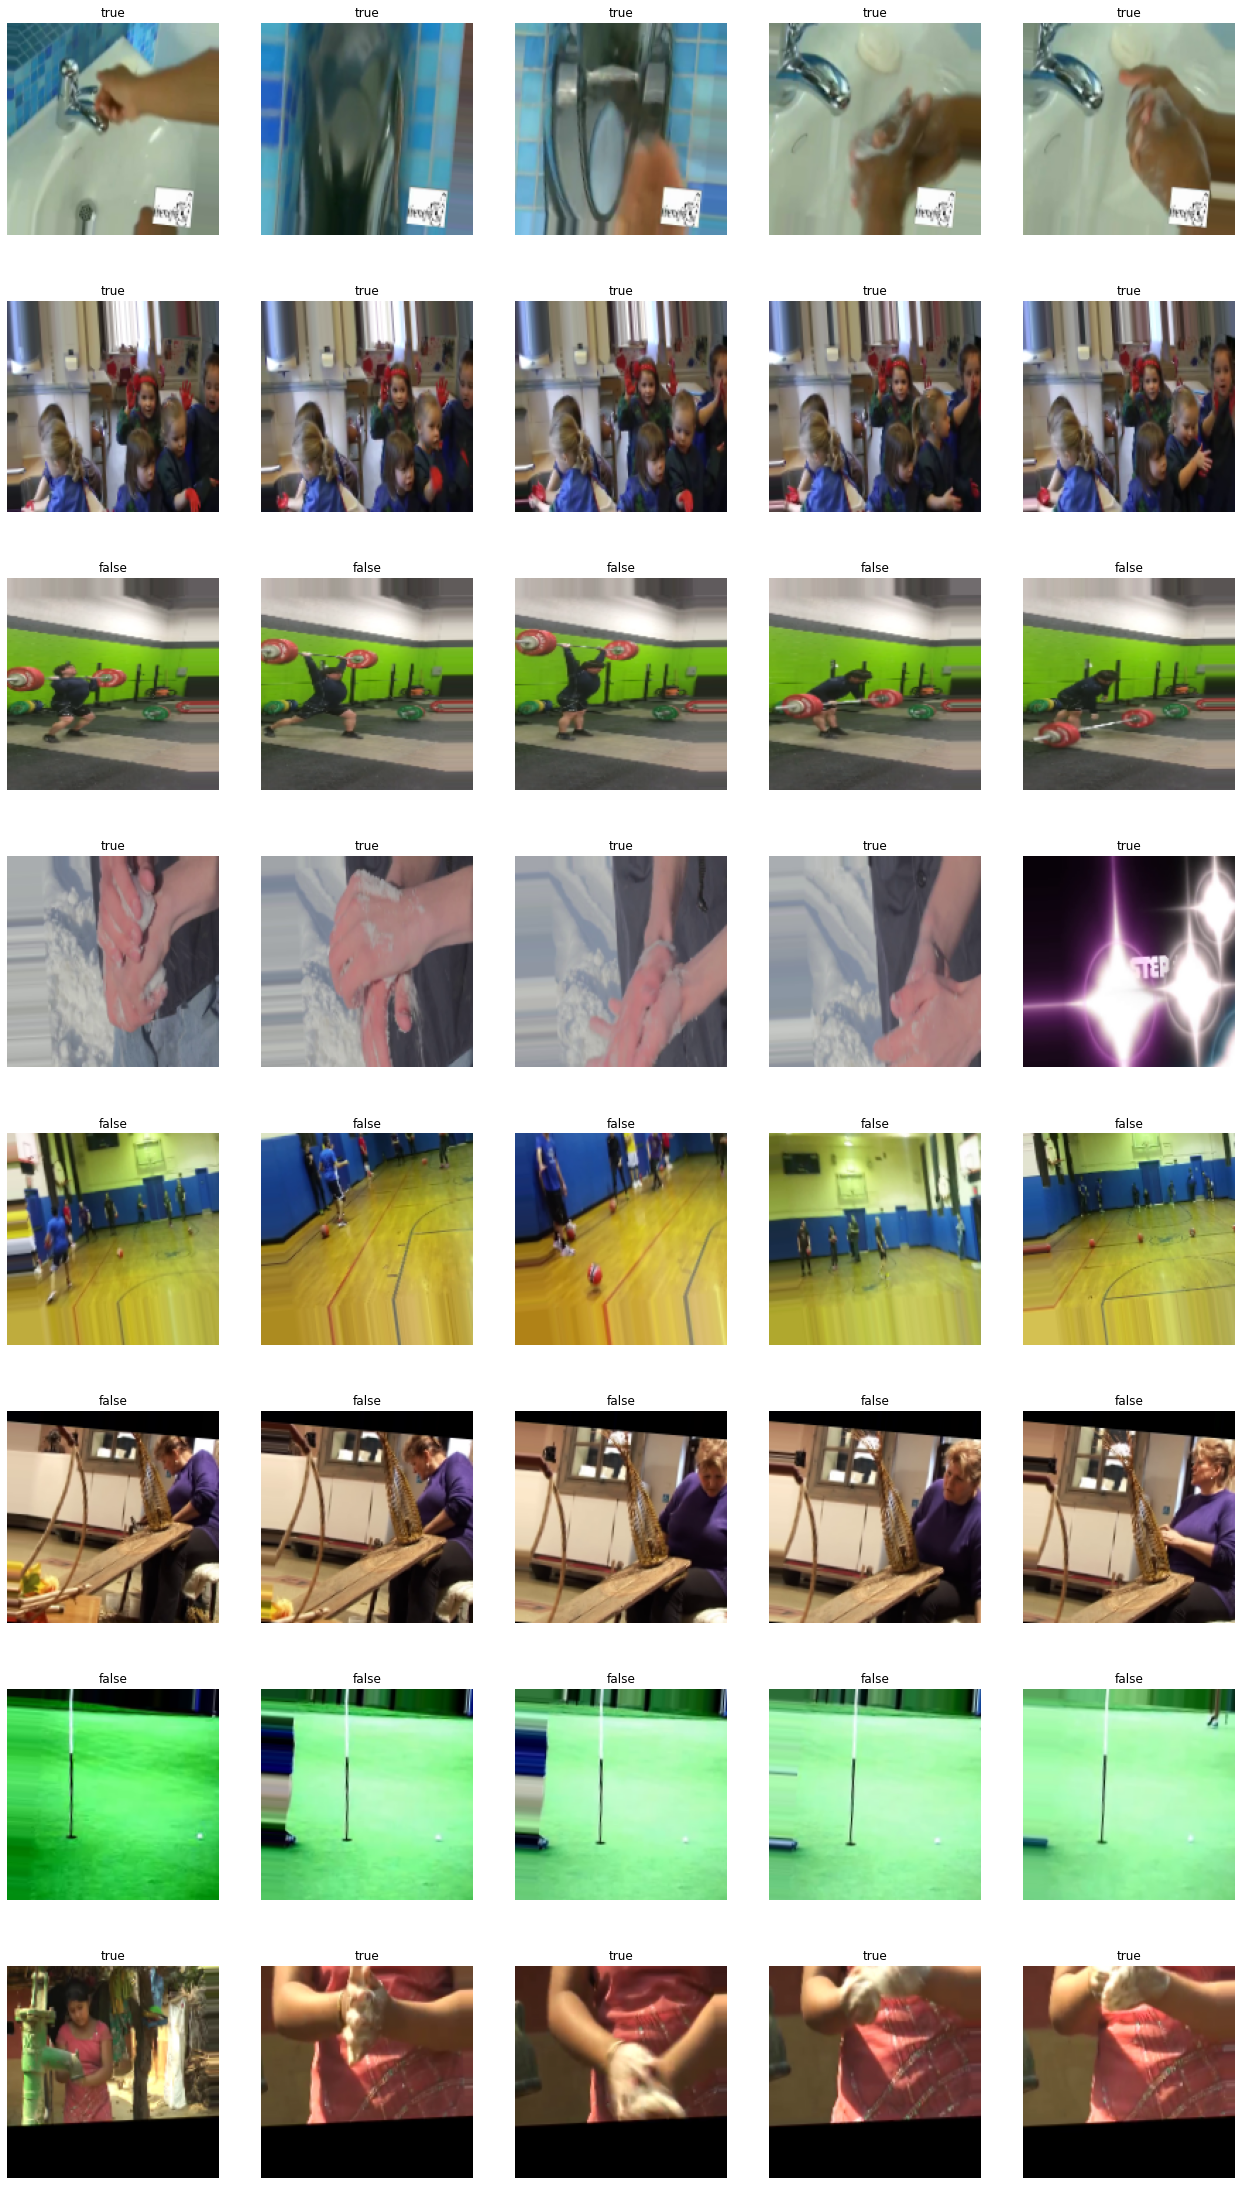

In [35]:
import keras_video.utils

keras_video.utils.show_sample(train)

Build my model

In [36]:
from keras.applications import VGG16
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import GlobalMaxPool2D
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.applications import Xception


In [37]:

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.trainable = False

def action_model(shape=(NBFRAME, 150, 150, 3), nbout=2):
    
    # Flatten output of conv_base
    mod = Sequential()
    mod.add(conv_base)
    mod.add(GlobalMaxPool2D())
    # Build our model for training
    model = Sequential()
    model.add(TimeDistributed(mod, input_shape=shape))
    # LSTM for time series
    model.add(LSTM(64))
    # Build the classifier
    # model.add(Dense(1024, activation='relu'))
    # model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
model = action_model(INSHAPE, len(classes))
model.summary()

83689472/83683744 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 2048)           20861480  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                540928    
_________________________________________________________________
dense (Dense)                (None, 512)               33280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_______________________________________________________

In [38]:
from keras.optimizers import Adam

optimizer= Adam(0.0001)
model.compile(optimizer=optimizer , 
              loss='binary_crossentropy',
              metrics=['accuracy'])

Train

Try 1: split_val=.2, Adam(0.001), steps_per_epoch = 20, epochs=35, validation_steps=10, NBFRAME = 15
, BS = 15. ACCURACY: 72




Try 1: split_val=.2, Adam(0.0001), steps_per_epoch = 20, epochs=30, validation_steps=10, NBFRAME = 5
, BS = 8. ACCURACY: 74.7

try 3: lr = 0.001 LSTM

In [39]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
                     filepath = 'washinghands_Xcep_sub5.h5',
                     monitor = 'val_loss',
                     save_best_only = True,
                 ),
]

history = model.fit(train,
                    steps_per_epoch = 30, #23 43
                    epochs=30, #can change
                   # batch_size=8,
                    callbacks=callbacks,
                    validation_data=val,
                    validation_steps=10)

Epoch 1/30
20/30 [===================>..........] - ETA: 28s - loss: 0.6934 - accuracy: 0.5100

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.168.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5199

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 126s 4s/step - loss: 0.6913 - accuracy: 0.5212 - val_loss: 0.6856 - val_accuracy: 0.5063
Epoch 2/30
23/30 [======================>.......] - ETA: 13s - loss: 0.7029 - accuracy: 0.4733

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.898.mp4, 0 total, 0 extracted


30/30 [==============================] - 81s 3s/step - loss: 0.7008 - accuracy: 0.4868 - val_loss: 0.6808 - val_accuracy: 0.4375
Epoch 3/30
 9/30 [========>.....................] - ETA: 44s - loss: 0.6953 - accuracy: 0.4921

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.696.mp4, 0 total, 0 extracted
Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.662.mp4, 0 total, 0 extracted


30/30 [==============================] - 72s 2s/step - loss: 0.6878 - accuracy: 0.5124 - val_loss: 0.6381 - val_accuracy: 0.7500
Epoch 4/30
17/30 [================>.............] - ETA: 17s - loss: 0.6440 - accuracy: 0.6393

Frame count is not OK for video /content/washinghands/content/kinetics700/train/true/washing hands.812.mp4, 4 total, 3 extracted


30/30 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.6295

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 59s 2s/step - loss: 0.6491 - accuracy: 0.6291 - val_loss: 0.6062 - val_accuracy: 0.7595
Epoch 5/30
17/30 [================>.............] - ETA: 15s - loss: 0.6428 - accuracy: 0.6966

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.662.mp4, 0 total, 0 extracted


20/30 [===================>..........] - ETA: 11s - loss: 0.6392 - accuracy: 0.7035

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.898.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.7086

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 45s 1s/step - loss: 0.6314 - accuracy: 0.7089 - val_loss: 0.5627 - val_accuracy: 0.7595
Epoch 6/30
12/30 [===========>..................] - ETA: 14s - loss: 0.5936 - accuracy: 0.7023

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.696.mp4, 0 total, 0 extracted


30/30 [==============================] - 38s 1s/step - loss: 0.5854 - accuracy: 0.7420 - val_loss: 0.5004 - val_accuracy: 0.7875
Epoch 7/30
26/30 [=========================>....] - ETA: 3s - loss: 0.5257 - accuracy: 0.8303

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.662.mp4, 0 total, 0 extracted


30/30 [==============================] - 35s 1s/step - loss: 0.5208 - accuracy: 0.8300 - val_loss: 0.4135 - val_accuracy: 0.8250
Epoch 8/30
30/30 [==============================] - ETA: 0s - loss: 0.5197 - accuracy: 0.7499

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 27s 900ms/step - loss: 0.5187 - accuracy: 0.7507 - val_loss: 0.3760 - val_accuracy: 0.8481
Epoch 9/30
 4/30 [===>..........................] - ETA: 19s - loss: 0.4258 - accuracy: 0.8828

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.539.mp4, 0 total, 0 extracted


30/30 [==============================] - 30s 997ms/step - loss: 0.4202 - accuracy: 0.8375 - val_loss: 0.3688 - val_accuracy: 0.8375
Epoch 10/30
 8/30 [=======>......................] - ETA: 13s - loss: 0.3807 - accuracy: 0.8394

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.423.mp4, 0 total, 0 extracted


30/30 [==============================] - 21s 712ms/step - loss: 0.3823 - accuracy: 0.8431 - val_loss: 0.3426 - val_accuracy: 0.8375
Epoch 11/30
26/30 [=========================>....] - ETA: 1s - loss: 0.4431 - accuracy: 0.8331

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.168.mp4, 0 total, 0 extracted


30/30 [==============================] - 16s 553ms/step - loss: 0.4331 - accuracy: 0.8358 - val_loss: 0.3233 - val_accuracy: 0.8500
Epoch 12/30
30/30 [==============================] - 16s 526ms/step - loss: 0.3427 - accuracy: 0.8708 - val_loss: 0.3802 - val_accuracy: 0.8375
Epoch 13/30
30/30 [==============================] - 16s 527ms/step - loss: 0.4143 - accuracy: 0.8228 - val_loss: 0.3259 - val_accuracy: 0.8750
Epoch 14/30
18/30 [=================>............] - ETA: 4s - loss: 0.4135 - accuracy: 0.8121

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.539.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3926 - accuracy: 0.8192

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 14s 445ms/step - loss: 0.3920 - accuracy: 0.8195 - val_loss: 0.3882 - val_accuracy: 0.7975
Epoch 15/30
19/30 [==================>...........] - ETA: 3s - loss: 0.4966 - accuracy: 0.7398

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.148.mp4, 0 total, 0 extracted


28/30 [===========================>..] - ETA: 0s - loss: 0.4797 - accuracy: 0.7613

Frame count is not OK for video /content/washinghands/content/kinetics700/train/true/washing hands.812.mp4, 4 total, 3 extracted


30/30 [==============================] - 9s 301ms/step - loss: 0.4747 - accuracy: 0.7667 - val_loss: 0.3279 - val_accuracy: 0.8500
Epoch 16/30
30/30 [==============================] - 10s 335ms/step - loss: 0.3911 - accuracy: 0.8863 - val_loss: 0.2998 - val_accuracy: 0.8500
Epoch 17/30
 9/30 [========>.....................] - ETA: 10s - loss: 0.3230 - accuracy: 0.8704

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.898.mp4, 0 total, 0 extracted


30/30 [==============================] - 10s 328ms/step - loss: 0.3132 - accuracy: 0.8812 - val_loss: 0.2220 - val_accuracy: 0.9125
Epoch 18/30
19/30 [==================>...........] - ETA: 3s - loss: 0.4399 - accuracy: 0.8137

Frame count is not OK for video /content/washinghands/content/kinetics700/train/true/washing hands.812.mp4, 4 total, 3 extracted


30/30 [==============================] - 9s 297ms/step - loss: 0.4143 - accuracy: 0.8243 - val_loss: 0.2673 - val_accuracy: 0.8875
Epoch 19/30
 6/30 [=====>........................] - ETA: 4s - loss: 0.2415 - accuracy: 0.9108

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.898.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 211ms/step - loss: 0.2748 - accuracy: 0.8961 - val_loss: 0.2191 - val_accuracy: 0.9375
Epoch 20/30
26/30 [=========================>....] - ETA: 0s - loss: 0.3429 - accuracy: 0.8721

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.898.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3480 - accuracy: 0.8675

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 235ms/step - loss: 0.3490 - accuracy: 0.8665 - val_loss: 0.3619 - val_accuracy: 0.8608
Epoch 21/30
11/30 [==========>...................] - ETA: 3s - loss: 0.3989 - accuracy: 0.8306

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.168.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 207ms/step - loss: 0.3800 - accuracy: 0.8404 - val_loss: 0.2814 - val_accuracy: 0.9000
Epoch 22/30
30/30 [==============================] - 6s 216ms/step - loss: 0.3008 - accuracy: 0.8952 - val_loss: 0.3525 - val_accuracy: 0.8375
Epoch 23/30
14/30 [=============>................] - ETA: 3s - loss: 0.2686 - accuracy: 0.8908

Frame count is not OK for video /content/washinghands/content/kinetics700/train/true/washing hands.812.mp4, 4 total, 3 extracted


30/30 [==============================] - ETA: 0s - loss: 0.2806 - accuracy: 0.8938

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 228ms/step - loss: 0.2815 - accuracy: 0.8934 - val_loss: 0.3298 - val_accuracy: 0.8861
Epoch 24/30
30/30 [==============================] - 6s 203ms/step - loss: 0.3749 - accuracy: 0.8537 - val_loss: 0.3239 - val_accuracy: 0.8625
Epoch 25/30
 3/30 [==>...........................] - ETA: 5s - loss: 0.3086 - accuracy: 0.8403

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.539.mp4, 0 total, 0 extracted


26/30 [=========================>....] - ETA: 0s - loss: 0.3576 - accuracy: 0.8338

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.423.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 223ms/step - loss: 0.3570 - accuracy: 0.8356 - val_loss: 0.2319 - val_accuracy: 0.8875
Epoch 26/30
30/30 [==============================] - 6s 210ms/step - loss: 0.3949 - accuracy: 0.8126 - val_loss: 0.3397 - val_accuracy: 0.8500
Epoch 27/30
26/30 [=========================>....] - ETA: 0s - loss: 0.3253 - accuracy: 0.8520

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.423.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3241 - accuracy: 0.8520

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 201ms/step - loss: 0.3240 - accuracy: 0.8521 - val_loss: 0.2440 - val_accuracy: 0.8734
Epoch 28/30
11/30 [==========>...................] - ETA: 3s - loss: 0.2778 - accuracy: 0.8999

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.662.mp4, 0 total, 0 extracted


30/30 [==============================] - 7s 223ms/step - loss: 0.2896 - accuracy: 0.8860 - val_loss: 0.2279 - val_accuracy: 0.9125
Epoch 29/30
 8/30 [=======>......................] - ETA: 6s - loss: 0.4081 - accuracy: 0.8486

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.148.mp4, 0 total, 0 extracted


20/30 [===================>..........] - ETA: 3s - loss: 0.3309 - accuracy: 0.8763

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.696.mp4, 0 total, 0 extracted


26/30 [=========================>....] - ETA: 1s - loss: 0.3275 - accuracy: 0.8741

Frame count is not OK for video /content/washinghands/content/kinetics700/train/true/washing hands.812.mp4, 4 total, 3 extracted


30/30 [==============================] - 9s 292ms/step - loss: 0.3237 - accuracy: 0.8737 - val_loss: 0.2877 - val_accuracy: 0.8500

Epoch 00029: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 30/30
15/30 [==============>...............] - ETA: 2s - loss: 0.4143 - accuracy: 0.8501

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.539.mp4, 0 total, 0 extracted


30/30 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8590

Frame count is not OK for video /content/washinghands/content/kinetics700/train/false/not washing hands.131.mp4, 0 total, 0 extracted


30/30 [==============================] - 6s 210ms/step - loss: 0.3898 - accuracy: 0.8597 - val_loss: 0.2614 - val_accuracy: 0.8987


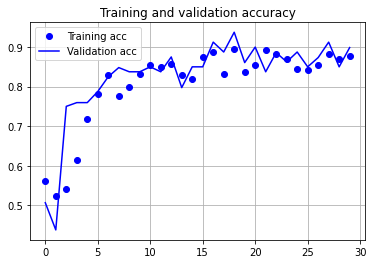

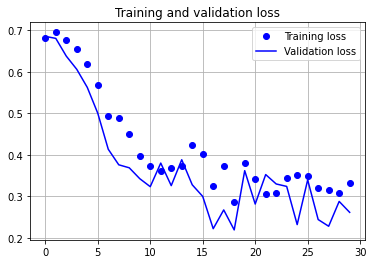

In [40]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

In [41]:
import keras
import keras_video.utils
from keras_video import VideoFrameGenerator

classes = ['true' , 'false']
SIZE = (150, 150)
CHANNELS = 3
NBFRAME = 5
BS = 8
glob_pattern='/content/washinghands/content/kinetics700/test/{classname}/*.mp4'

# make video frame generator
test = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    shuffle=False,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    use_frame_cache=True)

Total data: 2 classes for 84 files for train


In [42]:
model.evaluate(test)

10/10 [==============================] - 19s 2s/step - loss: 0.3398 - accuracy: 0.8375


[0.339783638715744, 0.8374999761581421]

In [43]:
!cp -a '/content/washinghands_Xcep_sub5.h5' '/content/drive/MyDrive/Colab Notebooks/Submission 5'